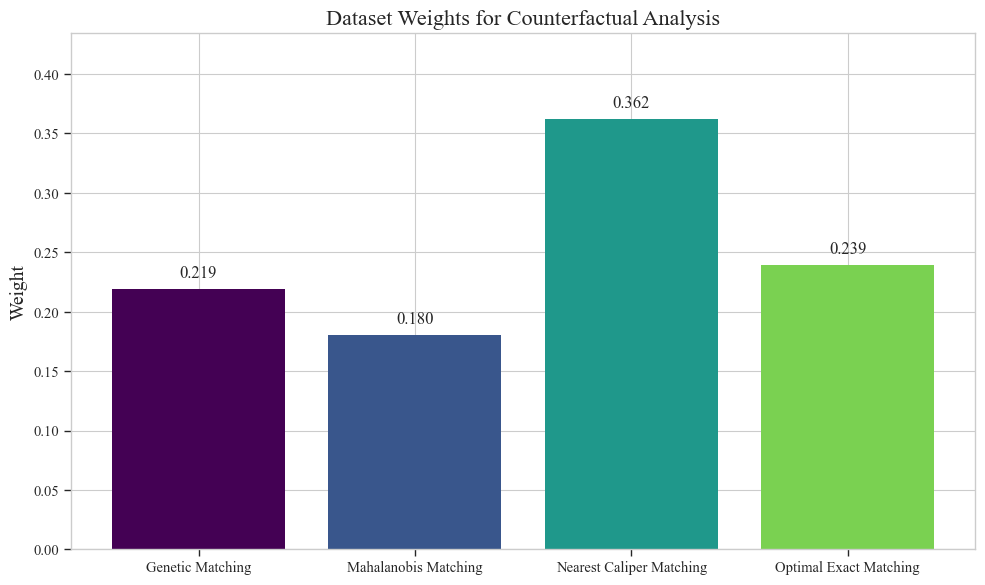

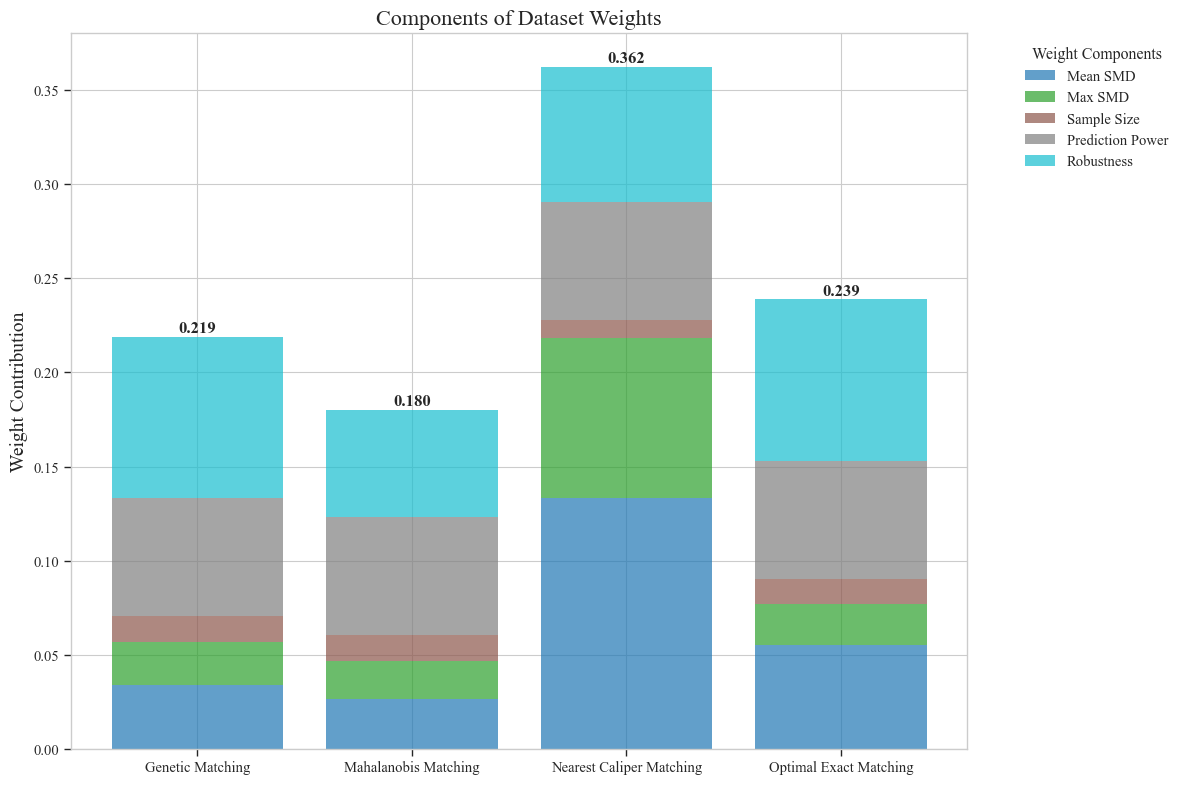

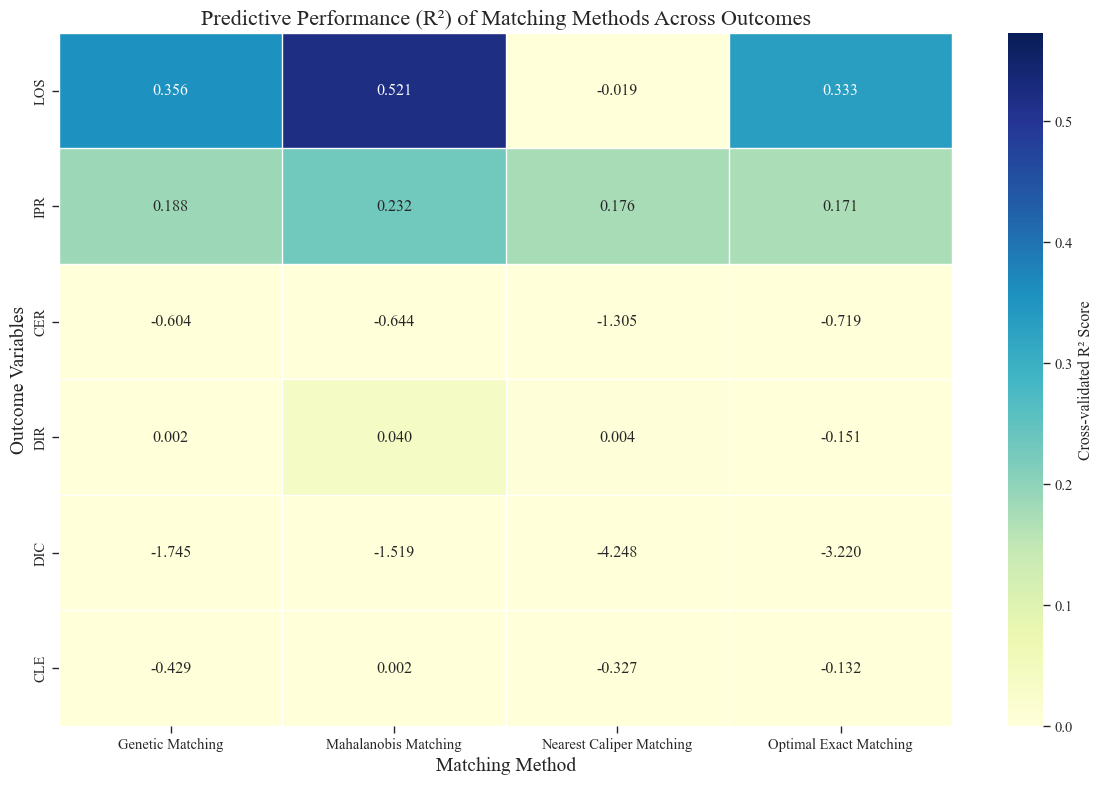

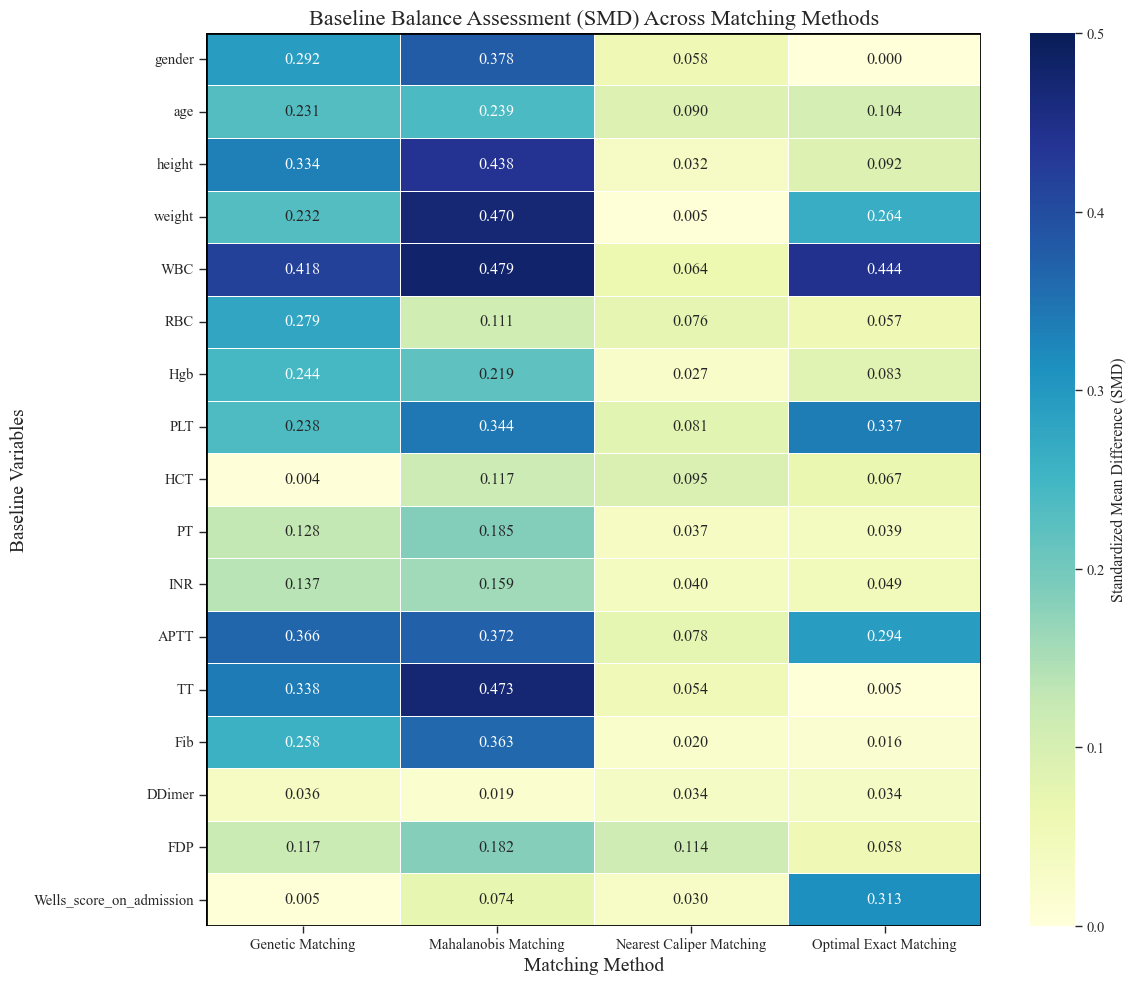

<Figure size 1000x600 with 0 Axes>

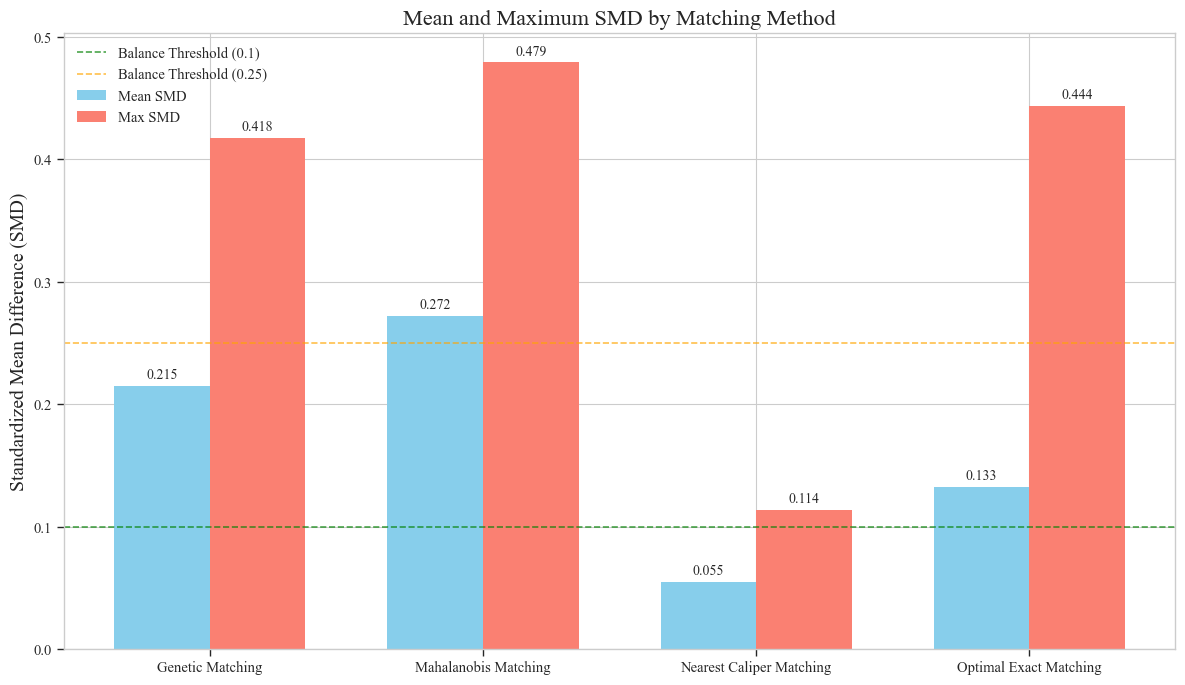

<Figure size 1400x1000 with 0 Axes>

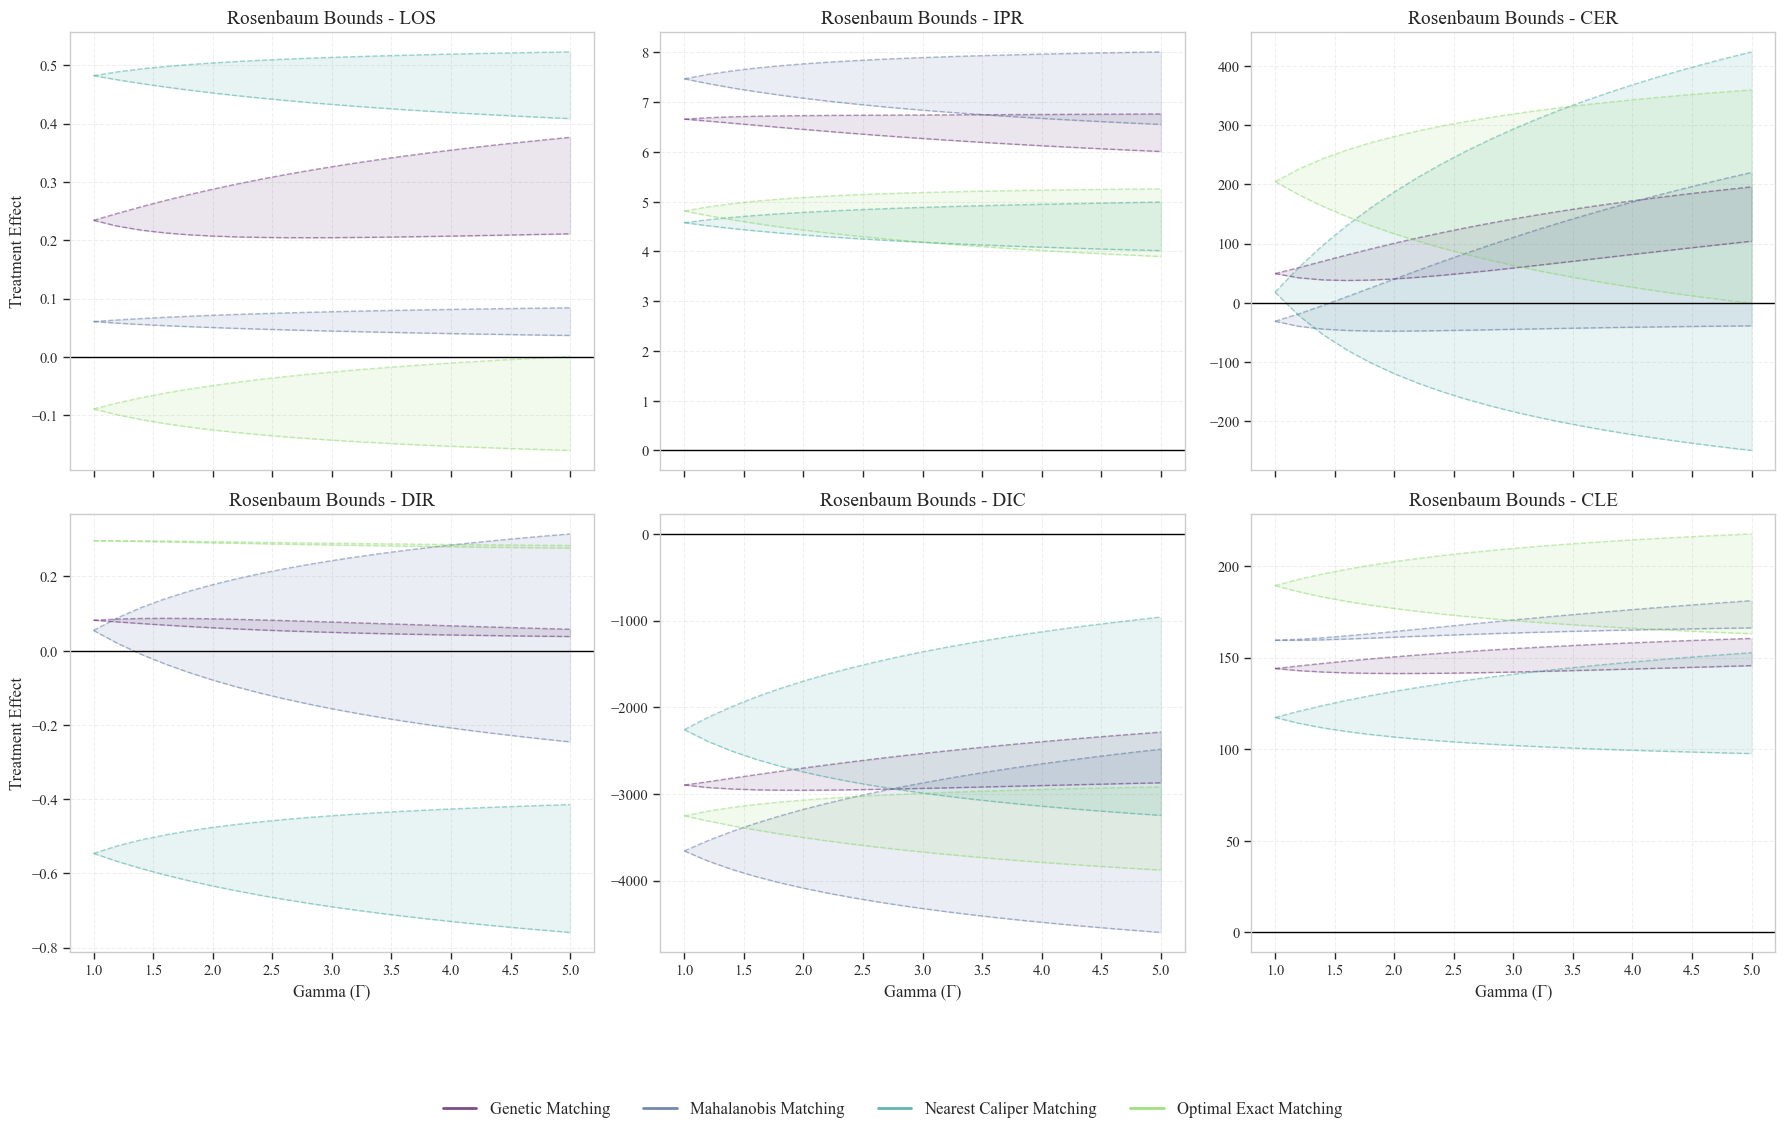

                          Final Weight
Genetic Matching              0.218949
Mahalanobis Matching          0.180290
Nearest Caliper Matching      0.361972
Optimal Exact Matching        0.238789


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

# 设置绘图风格
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper", font_scale=1.2)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

# 定义变量组
baseline_vars = ["gender", "age", "height", "weight", "WBC", "RBC", "Hgb", 
                "PLT", "HCT", "PT", "INR", "APTT", "TT", "Fib", 
                "DDimer", "FDP", "Wells_score_on_admission"]
mediator_vars = ["Alprostadil", "Buqi.Tongluo.Capsules", "Diosmin", "Enoxaparin", 
                "Furosemide", "Guhong.injection", "Nadroparin.Calcium", 
                "Sodium.Aescinate", "Urokinase", "Warfarin", 
                "Elevate.lower.limbs.to.30.degrees", "Local.immobilization", 
                "BXpowder", "SbOintment"]
outcome_vars = ["LOS", "IPR", "CER", "DIR", "DIC", "CLE"]
treatment_var = 'CombineAnti'
pair_id = 'pair_id'

# 数据路径
data_paths = {
    'Genetic Matching': r"C:\MyProject\Myproject\code\LOS\newLOS\DATA\multimatch\matched_data_genetic.csv",
    'Mahalanobis Matching': r"C:\MyProject\Myproject\code\LOS\newLOS\DATA\multimatch\matched_data_mahalanobis.csv",
    'Nearest Caliper Matching': r"C:\MyProject\Myproject\code\LOS\newLOS\DATA\multimatch\matched_data_nearest_caliper.csv",
    'Optimal Exact Matching': r"C:\MyProject\Myproject\code\LOS\newLOS\DATA\multimatch\matched_data_optimal_exact.csv"
}

# 读取数据
datasets = {}
for name, path in data_paths.items():
    datasets[name] = pd.read_csv(path)

#############################################################################
# 1. 数据集平衡性评估部分
#############################################################################

# 计算标准化均值差异（SMD）来评估基线平衡性
def calculate_smd(data, var, treatment_var):
    treated = data[data[treatment_var] == 1][var]
    control = data[data[treatment_var] == 0][var]
    
    # 计算均值差异
    mean_diff = treated.mean() - control.mean()
    
    # 计算合并方差
    s1 = treated.var()
    s2 = control.var()
    s_pooled = np.sqrt((s1 + s2) / 2)
    
    # 避免除以零
    if s_pooled == 0:
        return 0
    
    # 计算SMD
    smd = abs(mean_diff / s_pooled)
    return smd

# 为每个数据集计算所有基线变量的SMD
dataset_balance = {}
for name, data in datasets.items():
    smds = [calculate_smd(data, var, treatment_var) for var in baseline_vars]
    dataset_balance[name] = {
        'mean_smd': np.mean(smds),
        'max_smd': np.max(smds),
        'sample_size': len(data)
    }

# 计算每个匹配方法的预测能力
def calculate_prediction_power(datasets, outcome_vars, treatment_var, baseline_vars):
    prediction_power = {}
    
    for name, data in datasets.items():
        prediction_power[name] = {}
        
        for outcome in outcome_vars:
            # 使用交叉验证评估预测能力
            kf = KFold(n_splits=5, shuffle=True, random_state=42)
            cv_r2 = []
            
            for train_idx, test_idx in kf.split(data):
                train_data = data.iloc[train_idx]
                test_data = data.iloc[test_idx]
                
                # 构建预测模型
                X_train = train_data[baseline_vars + [treatment_var]]
                X_train = sm.add_constant(X_train)
                y_train = train_data[outcome]
                
                try:
                    model = sm.OLS(y_train, X_train).fit()
                    
                    # 预测测试集
                    X_test = test_data[baseline_vars + [treatment_var]]
                    X_test = sm.add_constant(X_test)
                    y_test = test_data[outcome]
                    y_pred = model.predict(X_test)
                    
                    # 计算R²
                    r2 = r2_score(y_test, y_pred)
                    if not np.isnan(r2):
                        cv_r2.append(r2)
                except:
                    continue
            
            # 平均R²作为预测能力指标
            if cv_r2:
                prediction_power[name][outcome] = np.mean(cv_r2)
            else:
                prediction_power[name][outcome] = 0
        
        # 计算每个方法的平均预测能力
        prediction_power[name]['avg'] = np.mean(list(prediction_power[name].values()))
    
    return prediction_power

# Rosenbaum敏感性分析函数
def calculate_pair_weights(data, treatment_var, pair_id, gamma):
    """计算基于配对的敏感性权重"""
    weights = pd.DataFrame(index=data.index)
    
    # 对每个配对计算权重
    for pair in data[pair_id].unique():
        pair_data = data[data[pair_id] == pair]
        if len(pair_data) == 2:  # 确保是完整的配对
            treated = pair_data[pair_data[treatment_var] == 1].index
            control = pair_data[pair_data[treatment_var] == 0].index
            
            # 上界权重
            weights.loc[treated, 'upper'] = gamma / (1 + gamma)
            weights.loc[control, 'upper'] = 1 / (1 + gamma)
            
            # 下界权重
            weights.loc[treated, 'lower'] = 1 / (1 + gamma)
            weights.loc[control, 'lower'] = gamma / (1 + gamma)
    
    return weights

def rosenbaum_bounds(data, outcome_var, treatment_var, pair_id, baseline_vars, gamma_range=np.arange(1.0, 5.1, 0.2)):
    """执行改进的Rosenbaum界限敏感性分析"""
    # 构建包含协变量的完整模型矩阵
    X = sm.add_constant(pd.concat([data[[treatment_var]], data[baseline_vars]], axis=1))
    
    # 计算基线ATE
    base_model = sm.OLS(data[outcome_var], X).fit()
    base_ate = base_model.params[treatment_var]
    
    bounds = []
    for gamma in gamma_range:
        # 计算基于配对的权重
        weights = calculate_pair_weights(data, treatment_var, pair_id, gamma)
        
        # 使用完整模型和配对权重进行加权回归
        upper_model = sm.WLS(data[outcome_var], X, weights=weights['upper']).fit()
        lower_model = sm.WLS(data[outcome_var], X, weights=weights['lower']).fit()
        
        bounds.append({
            'gamma': gamma,
            'lower_bound': lower_model.params[treatment_var],
            'upper_bound': upper_model.params[treatment_var]
        })
    
    return pd.DataFrame(bounds)

# 计算Rosenbaum敏感性分析结果和稳健性指标
rosenbaum_results = {}
for outcome in outcome_vars:
    rosenbaum_results[outcome] = {}
    for name, data in datasets.items():
        rosenbaum_results[outcome][name] = rosenbaum_bounds(data, outcome, treatment_var, pair_id, baseline_vars)

# 计算稳健性指标
def calculate_rosenbaum_robustness(rosenbaum_results, gamma_threshold=1.5):
    robustness_scores = {}
    
    for name in datasets.keys():
        significant_outcomes = 0
        total_outcomes = len(outcome_vars)
        
        for outcome in outcome_vars:
            bounds = rosenbaum_results[outcome][name]
            # 找到gamma=gamma_threshold的行(或最接近的值)
            gamma_row = bounds[bounds['gamma'] >= gamma_threshold].iloc[0] if any(bounds['gamma'] >= gamma_threshold) else bounds.iloc[-1]
            
            # 如果置信区间不包含0，则认为结果稳健
            if (gamma_row['lower_bound'] > 0 and gamma_row['upper_bound'] > 0) or \
               (gamma_row['lower_bound'] < 0 and gamma_row['upper_bound'] < 0):
                significant_outcomes += 1
        
        robustness_scores[name] = significant_outcomes / total_outcomes
    
    return robustness_scores

# 计算Rosenbaum稳健性指标
robustness_scores = calculate_rosenbaum_robustness(rosenbaum_results)

# 计算预测能力
prediction_power = calculate_prediction_power(datasets, outcome_vars, treatment_var, baseline_vars)

# 计算每个数据集的综合权重
def calculate_comprehensive_weights(balance_dict, prediction_power, robustness_scores):
    # 1. 平均SMD权重 - 较低的SMD应该有较高的权重
    inverse_mean_smd = {k: 1/v['mean_smd'] for k, v in balance_dict.items()}
    total_inverse_mean_smd = sum(inverse_mean_smd.values())
    normalized_inverse_mean_smd = {k: v/total_inverse_mean_smd for k, v in inverse_mean_smd.items()}
    
    # 2. 最大SMD权重 - 较低的最大SMD应该有较高的权重
    inverse_max_smd = {k: 1/v['max_smd'] for k, v in balance_dict.items()}
    total_inverse_max_smd = sum(inverse_max_smd.values())
    normalized_inverse_max_smd = {k: v/total_inverse_max_smd for k, v in inverse_max_smd.items()}
    
    # 3. 样本量权重
    total_samples = sum(v['sample_size'] for v in balance_dict.values())
    normalized_sample_size = {k: v['sample_size']/total_samples for k, v in balance_dict.items()}
    
    # 4. 预测能力权重
    prediction_avg = {k: v['avg'] for k, v in prediction_power.items()}
    total_prediction = sum(prediction_avg.values())
    normalized_prediction = {k: v/total_prediction if total_prediction > 0 else 0.25 
                            for k, v in prediction_avg.items()}
    
    # 5. Rosenbaum稳健性权重
    total_robustness = sum(robustness_scores.values())
    normalized_robustness = {k: v/total_robustness if total_robustness > 0 else 0.25 
                            for k, v in robustness_scores.items()}
    
    # 组合权重 - 调整后的权重分配
    weights = {k: normalized_inverse_mean_smd[k] * 0.25 +  # 平均SMD (25%)
                  normalized_inverse_max_smd[k] * 0.15 +   # 最大SMD (15%)
                  normalized_sample_size[k] * 0.05 +       # 样本量 (5%) - 降低权重
                  normalized_prediction[k] * 0.25 +        # 预测能力 (25%) - 提高权重
                  normalized_robustness[k] * 0.3          # Rosenbaum稳健性 (30%) - 提高权重
              for k in balance_dict.keys()}
    
    # 归一化最终权重
    total_weight = sum(weights.values())
    normalized_weights = {k: v/total_weight for k, v in weights.items()}
    
    # 返回详细的权重组成和最终权重
    weight_components = {
        'mean_smd_weight': normalized_inverse_mean_smd,
        'max_smd_weight': normalized_inverse_max_smd,
        'sample_size_weight': normalized_sample_size,
        'prediction_weight': normalized_prediction,
        'robustness_weight': normalized_robustness,
        'final_weight': normalized_weights
    }
    
    return normalized_weights, weight_components

# 计算综合权重
dataset_weights, weight_components = calculate_comprehensive_weights(
    dataset_balance, prediction_power, robustness_scores
)

# 可视化1: 数据集权重条形图
plt.figure(figsize=(10, 6))
methods = list(dataset_weights.keys())
weights = [dataset_weights[m] for m in methods]
colors = plt.cm.viridis(np.linspace(0, 0.8, len(methods)))

bars = plt.bar(methods, weights, color=colors)
plt.ylabel('Weight', fontsize=14)
plt.title('Dataset Weights for Counterfactual Analysis', fontsize=16)
plt.ylim(0, max(weights)*1.2)

# 添加数值标签
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', fontsize=12)

plt.tight_layout()
plt.savefig(r"C:\MyProject\Myproject\code\LOS\newLOS\figures\dataset_weights.png", dpi=300, bbox_inches='tight')
plt.show()

# 可视化2: 权重组成堆叠条形图
plt.figure(figsize=(12, 8))
components = ['mean_smd_weight', 'max_smd_weight', 'sample_size_weight', 
              'prediction_weight', 'robustness_weight']
component_labels = ['Mean SMD', 'Max SMD', 'Sample Size', 
                   'Prediction Power', 'Robustness']
component_colors = plt.cm.tab10(np.linspace(0, 1, len(components)))

# 创建堆叠条形图数据
weight_data = []
for method in methods:
    method_weights = []
    for component in components:
        # 获取每个组件的权重，并乘以其在最终权重中的比例
        if component == 'mean_smd_weight':
            weight = weight_components[component][method] * 0.25
        elif component == 'max_smd_weight':
            weight = weight_components[component][method] * 0.15
        elif component == 'sample_size_weight':
            weight = weight_components[component][method] * 0.05  # 
        elif component == 'prediction_weight':
            weight = weight_components[component][method] * 0.25  # 
        else:  # robustness_weight
            weight = weight_components[component][method] * 0.3  # 
        method_weights.append(weight)
    weight_data.append(method_weights)

# 转置数据以便堆叠
weight_data = np.array(weight_data).T

# 绘制堆叠条形图
bottom = np.zeros(len(methods))
for i, (data, color, label) in enumerate(zip(weight_data, component_colors, component_labels)):
    plt.bar(methods, data, bottom=bottom, color=color, label=label, alpha=0.7)
    bottom += data

# 添加最终权重标签
for i, method in enumerate(methods):
    plt.text(i, dataset_weights[method] , f'{dataset_weights[method]:.3f}', 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylabel('Weight Contribution', fontsize=14)
plt.title('Components of Dataset Weights', fontsize=16)
plt.legend(title='Weight Components', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(r"C:\MyProject\Myproject\code\LOS\newLOS\figures\weight_components.png", dpi=300, bbox_inches='tight')
plt.show()

# 可视化3: 各匹配方法在不同结局指标上的预测能力(R²)热图
plt.figure(figsize=(12, 8))

# 准备热图数据
r2_data = {}
for name in methods:
    r2_data[name] = [prediction_power[name][outcome] for outcome in outcome_vars]
# 转换为DataFrame用于绘图
r2_df = pd.DataFrame(r2_data, index=outcome_vars)

# 创建热图
sns.heatmap(r2_df, cmap='YlGnBu', annot=True, fmt='.3f',
           linewidths=.5, vmin=0, vmax=r2_df.values.max() * 1.1,
           cbar_kws={'label': 'Cross-validated R² Score'})

plt.title('Predictive Performance (R²) of Matching Methods Across Outcomes', fontsize=16)
plt.ylabel('Outcome Variables', fontsize=14)
plt.xlabel('Matching Method', fontsize=14)

# 添加网格线使表格更清晰
plt.grid(False)
for i in range(len(outcome_vars) + 1):
    plt.axhline(y=i, color='white', linestyle='-', linewidth=1)
for j in range(len(methods) + 1):
    plt.axvline(x=j, color='white', linestyle='-', linewidth=1)
plt.tight_layout()
plt.savefig(r"C:\MyProject\Myproject\code\LOS\newLOS\figures\prediction_r2_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

# 可视化5: SMD平衡性评估热图 - 平均SMD
plt.figure(figsize=(12, 10))

# 为每个匹配方法计算所有基线变量的SMD
smd_data = {}
for name, data in datasets.items():
    smd_data[name] = [calculate_smd(data, var, treatment_var) for var in baseline_vars]

# 转换为DataFrame用于绘图
smd_df = pd.DataFrame(smd_data, index=baseline_vars)

# 绘制热图
sns.heatmap(smd_df, cmap='YlGnBu', annot=True, fmt='.3f', 
           linewidths=.5, vmin=0, vmax=0.5, 
           cbar_kws={'label': 'Standardized Mean Difference (SMD)'})

plt.title('Baseline Balance Assessment (SMD) Across Matching Methods', fontsize=16)
plt.ylabel('Baseline Variables', fontsize=14)
plt.xlabel('Matching Method', fontsize=14)

# 添加参考线
plt.axhline(y=0, color='k', linewidth=2)
plt.axhline(y=len(baseline_vars), color='k', linewidth=2)
plt.axvline(x=0, color='k', linewidth=2)
plt.axvline(x=len(methods), color='k', linewidth=2)

plt.tight_layout()
plt.savefig(r"C:\MyProject\Myproject\code\LOS\newLOS\figures\smd_balance_assessment.png", dpi=300, bbox_inches='tight')
plt.show()

# 可视化5b: 最大SMD平衡性评估条形图
plt.figure(figsize=(10, 6))

# 准备数据
max_smd_values = [dataset_balance[m]['max_smd'] for m in methods]
mean_smd_values = [dataset_balance[m]['mean_smd'] for m in methods]

# 创建并列条形图
x = np.arange(len(methods))
width = 0.35
fig, ax = plt.subplots(figsize=(12, 7))
bars1 = ax.bar(x - width/2, mean_smd_values, width, label='Mean SMD', color='skyblue')
bars2 = ax.bar(x + width/2, max_smd_values, width, label='Max SMD', color='salmon')

# 添加标签和标题
ax.set_ylabel('Standardized Mean Difference (SMD)', fontsize=14)
ax.set_title('Mean and Maximum SMD by Matching Method', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend()

# 添加数值标签
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3点垂直偏移
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

# 添加参考线 - 0.1是常用的SMD平衡阈值
ax.axhline(y=0.1, color='green', linestyle='--', alpha=0.7, label='Balance Threshold (0.1)')
ax.axhline(y=0.25, color='orange', linestyle='--', alpha=0.7, label='Balance Threshold (0.25)')

# 更新图例
ax.legend(loc='upper left')

plt.tight_layout()
plt.savefig(r"C:\MyProject\Myproject\code\LOS\newLOS\figures\mean_max_smd_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# 可视化6: Rosenbaum敏感性分析结果
plt.figure(figsize=(14, 10))

# 为每个结果变量创建一个子图
fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharex=True)
axes = axes.flatten()

# 为每个结果变量绘制敏感性分析图
for i, outcome in enumerate(outcome_vars):
    ax = axes[i]
    
    # 获取gamma值范围（假设所有方法使用相同的gamma范围）
    gamma_values = rosenbaum_results[outcome][methods[0]]['gamma'].values
    
    # 为每个方法绘制Rosenbaum界限
    for j, method in enumerate(methods):
        bounds = rosenbaum_results[outcome][method]
        color = colors[j]
        
        ax.plot(bounds['gamma'], bounds['lower_bound'], '--', color=color, alpha=0.4, linewidth=1)
        ax.plot(bounds['gamma'], bounds['upper_bound'], '--', color=color, alpha=0.4, linewidth=1)
        ax.fill_between(bounds['gamma'], bounds['lower_bound'], bounds['upper_bound'], 
                       color=color, alpha=0.1, label=method if i == 0 else "")
    
    # 添加零线
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
    
    # 设置轴标签和标题
    ax.set_title(f'Rosenbaum Bounds - {outcome}', fontsize=14)
    
    # 仅为最后一行的子图添加x轴标签
    if i >= len(outcome_vars) - 3:
        ax.set_xlabel('Gamma (Γ)', fontsize=12)
    
    # 仅为第一列的子图添加y轴标签
    if i % 3 == 0:
        ax.set_ylabel('Treatment Effect', fontsize=12)
    
    # 添加网格线
    ax.grid(True, linestyle='--', alpha=0.3)

# 添加图例
handles, labels = [], []
for j, method in enumerate(methods):
    handles.append(plt.Line2D([0], [0], color=colors[j], lw=2, alpha=0.7))
    labels.append(method)

fig.legend(handles, labels, loc='lower center', ncol=len(methods), fontsize=12,
          bbox_to_anchor=(0.5, 0))

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.subplots_adjust(bottom=0.15)  # 为底部图例留出空间
plt.savefig(r"C:\MyProject\Myproject\code\LOS\newLOS\figures\rosenbaum_sensitivity_by_dataset.png", dpi=300, bbox_inches='tight')
plt.show()
# 创建一个数据集权重和平衡性的综合表格
balance_df = pd.DataFrame({
    'Method': methods,
    'Final Weight': [dataset_weights[m] for m in methods],
    'Mean SMD': [dataset_balance[m]['mean_smd'] for m in methods],
    'Max SMD': [dataset_balance[m]['max_smd'] for m in methods],
    'Sample Size': [dataset_balance[m]['sample_size'] for m in methods],
    'Prediction Power': [prediction_power[m]['avg'] for m in methods],
    'Robustness Score': [robustness_scores[m] for m in methods]
})
# 保存权重和平衡性表格
balance_df.to_csv(r"C:\MyProject\Myproject\code\LOS\newLOS\DATA\dataset_weights_balance.csv", index=False)

# 呈现出四个数据的最终权重
final_weights = pd.DataFrame(dataset_weights, index=['Final Weight']).T
print(final_weights)



Analyzing outcome: LOS


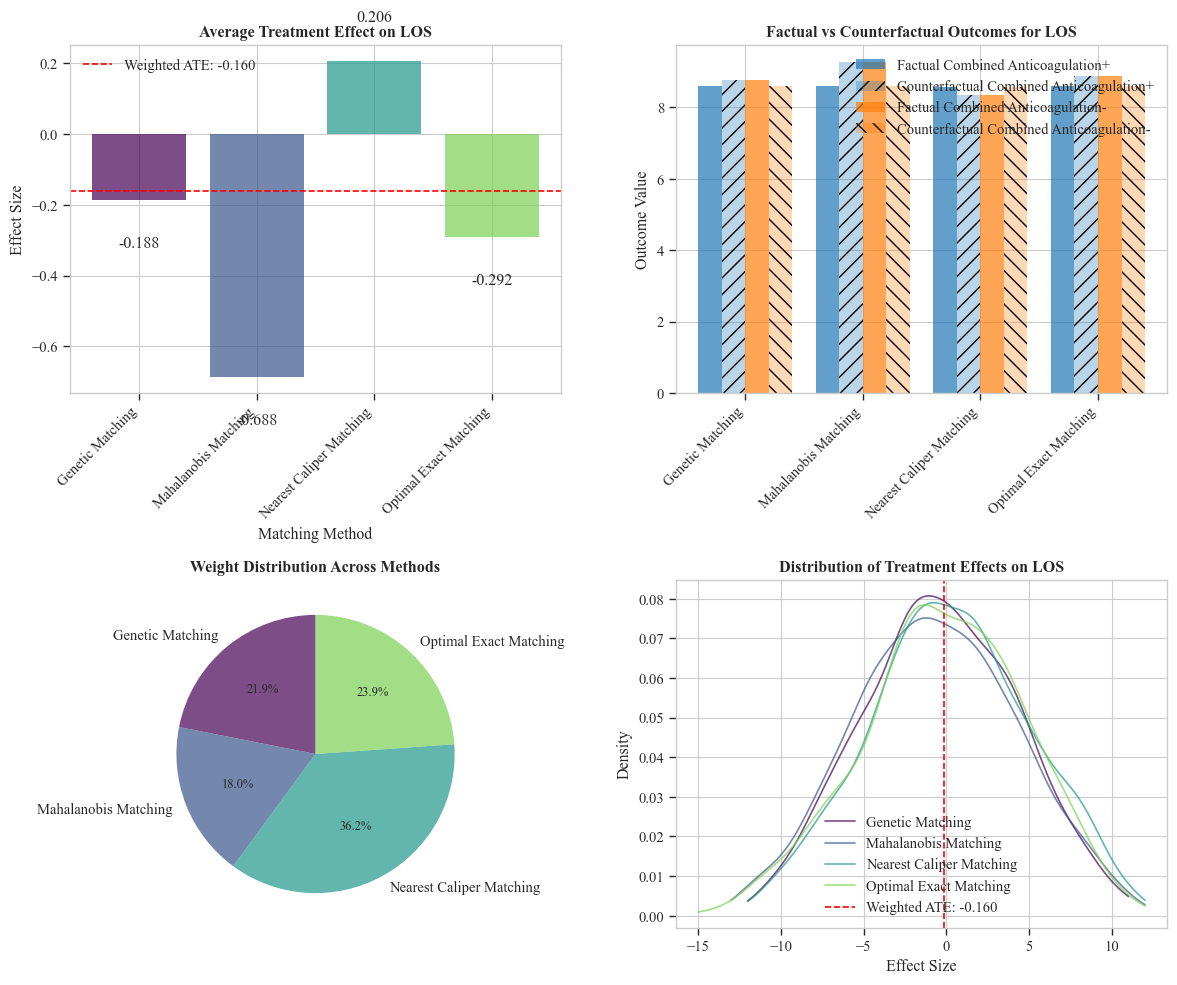

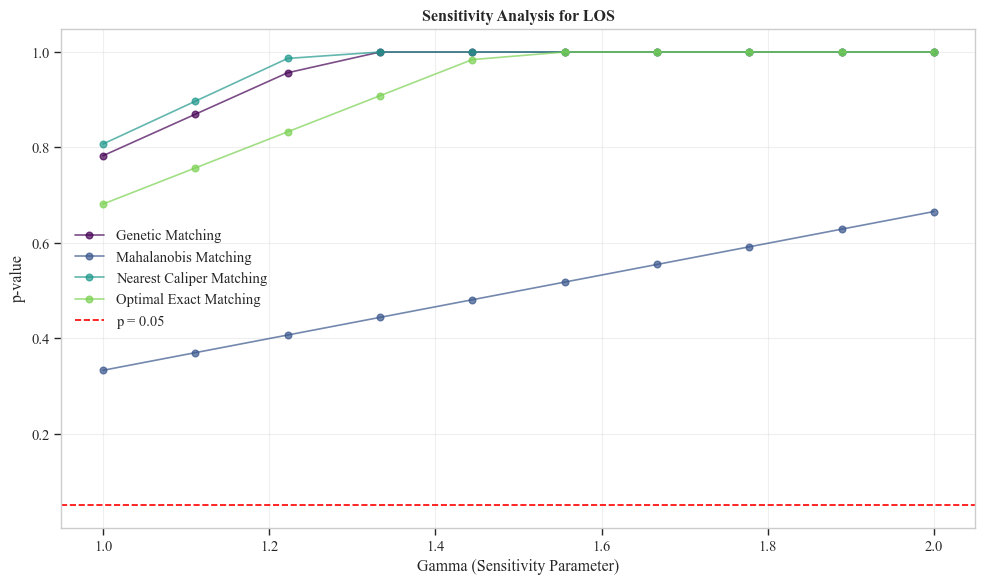


Analyzing outcome: IPR


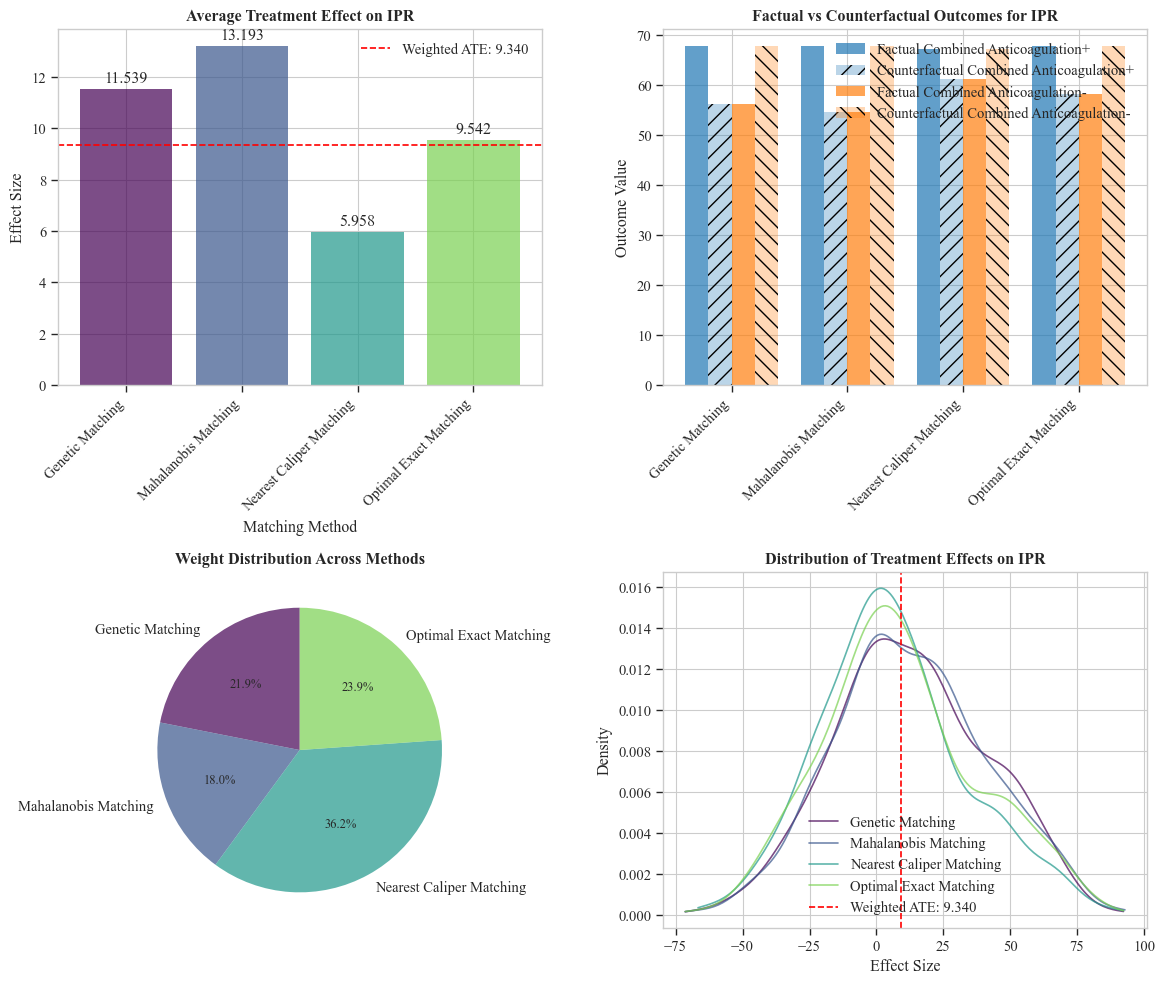

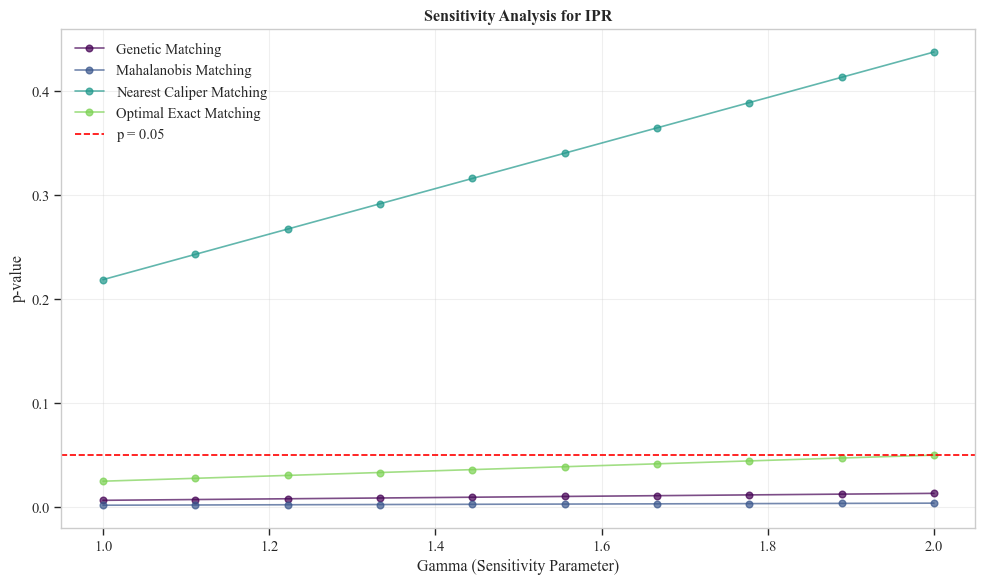


Analyzing outcome: CER


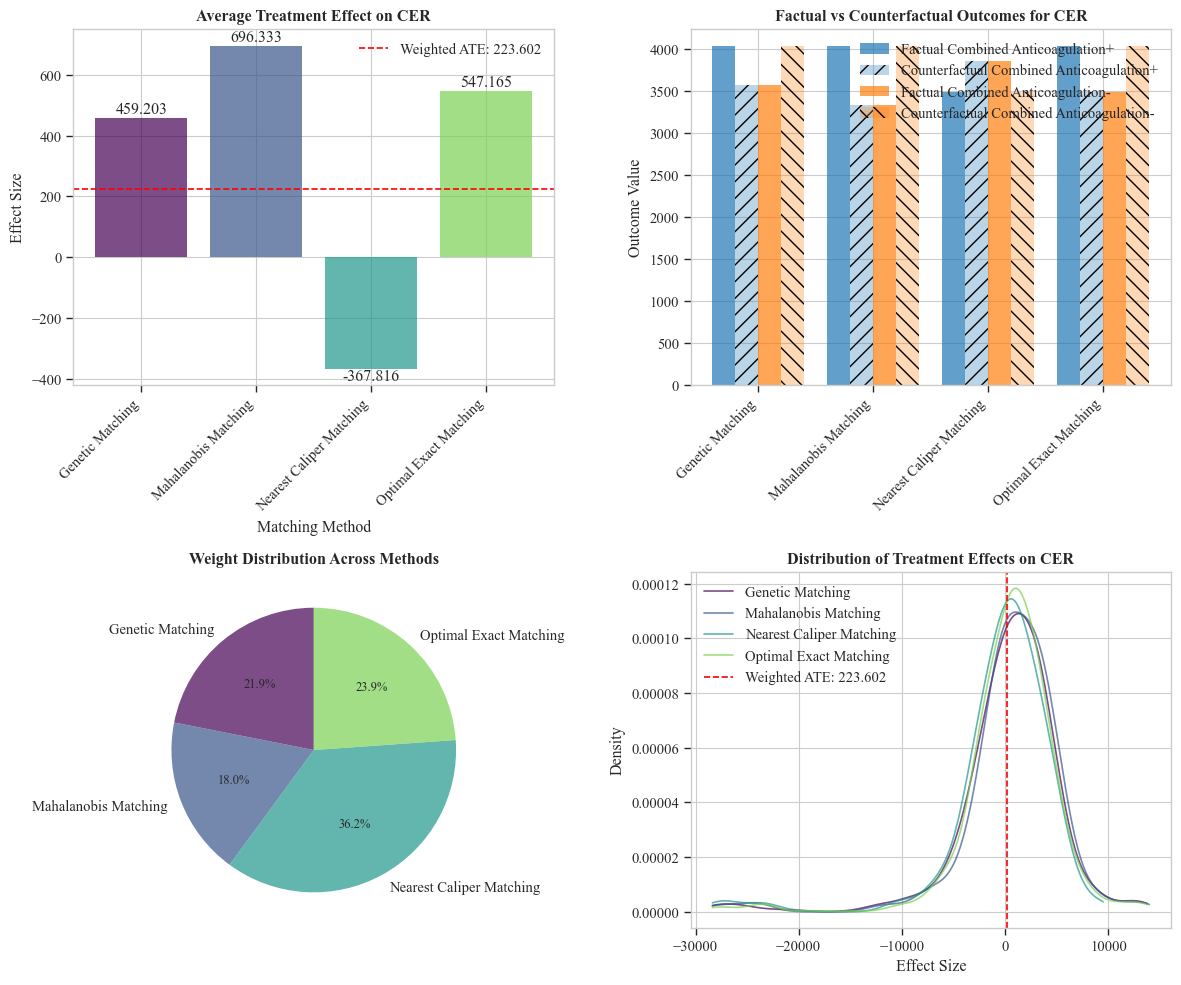

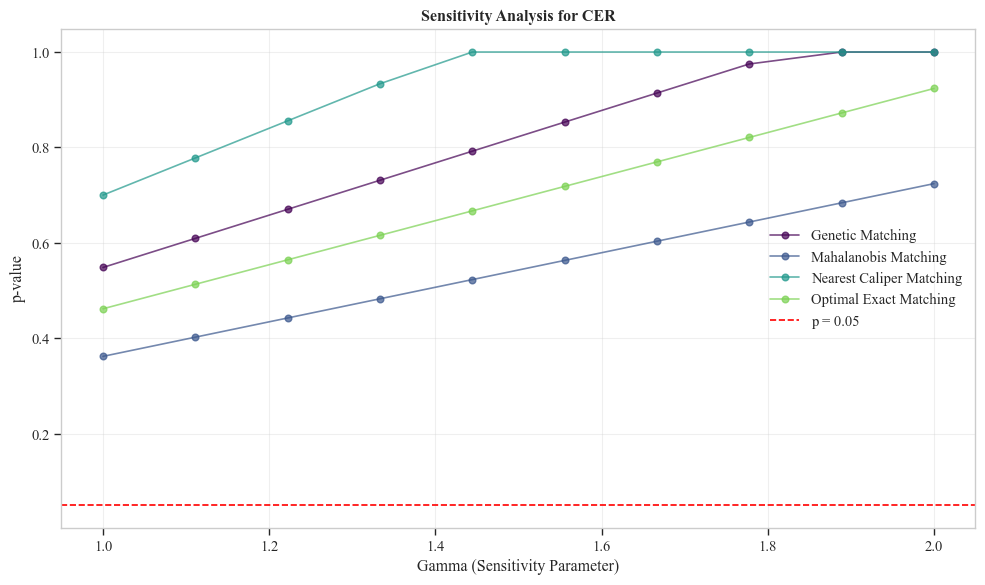


Analyzing outcome: DIR


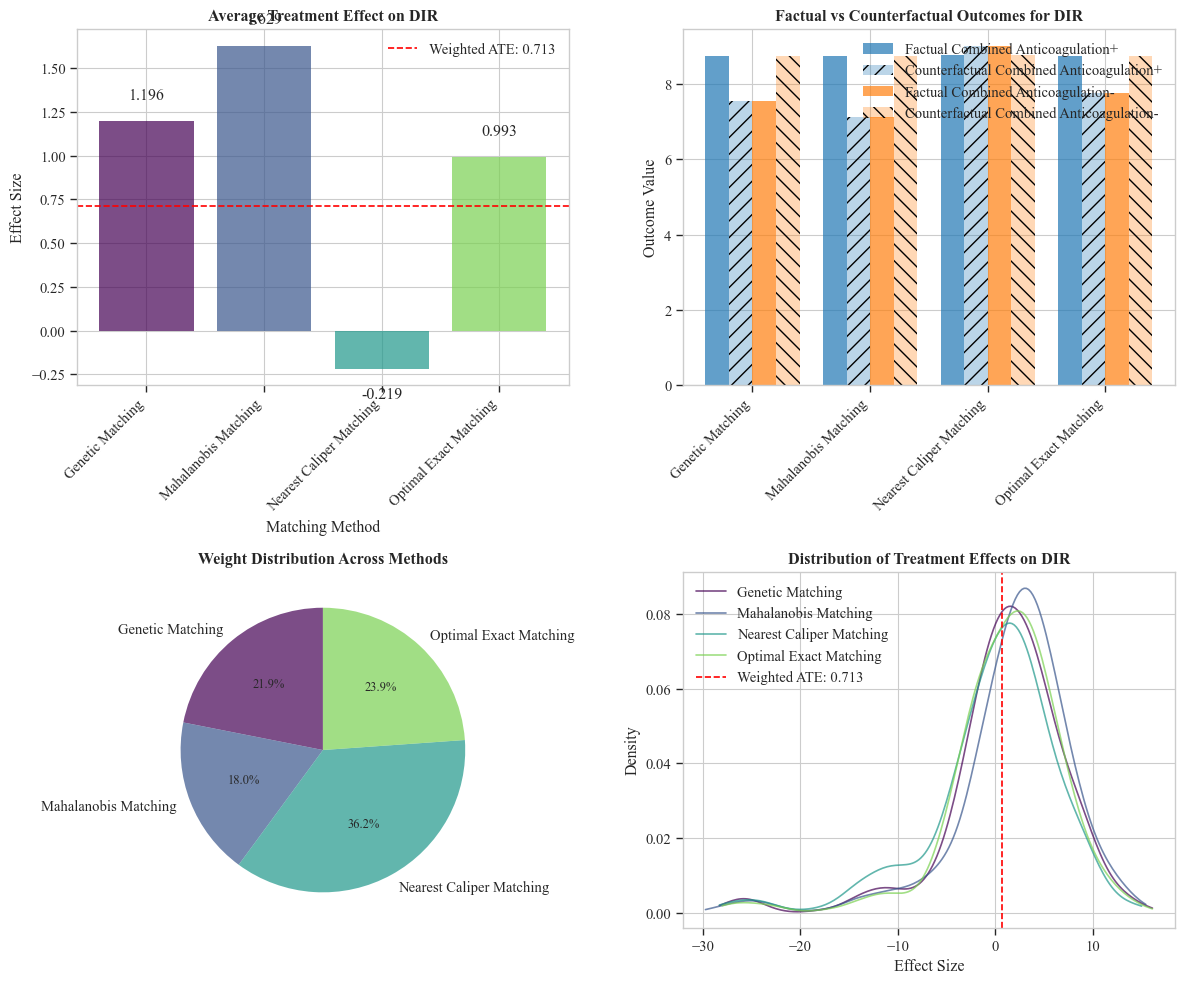

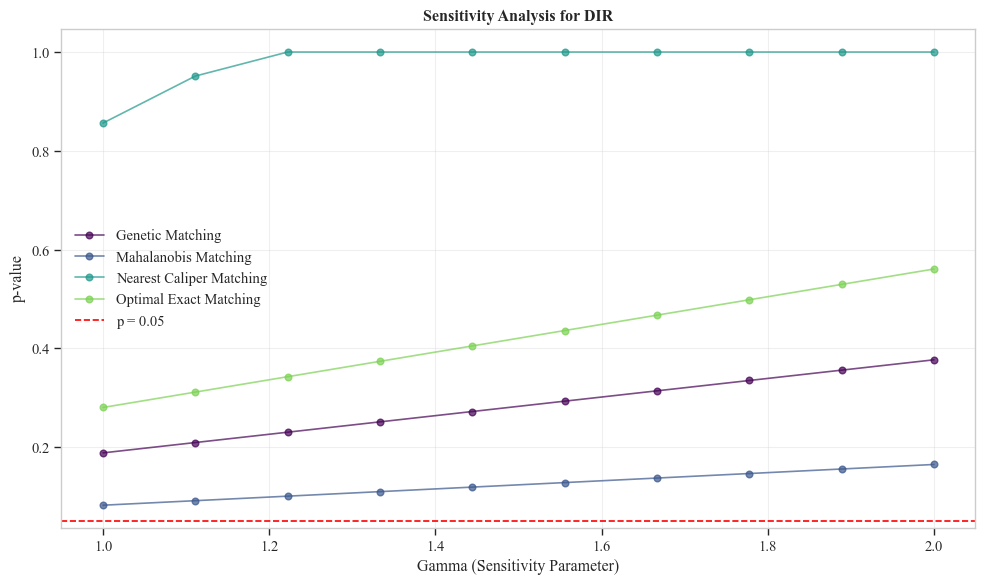


Analyzing outcome: DIC


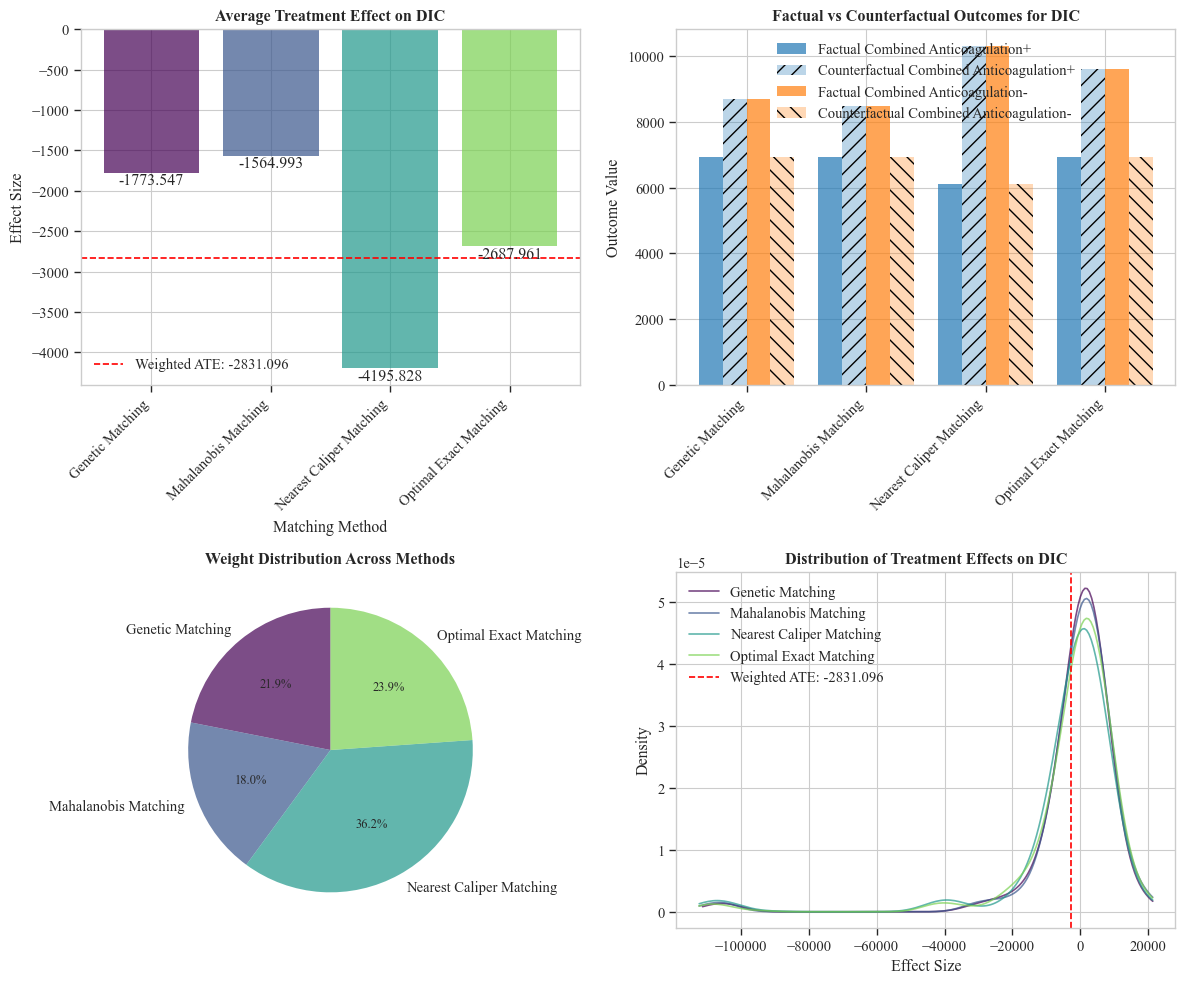

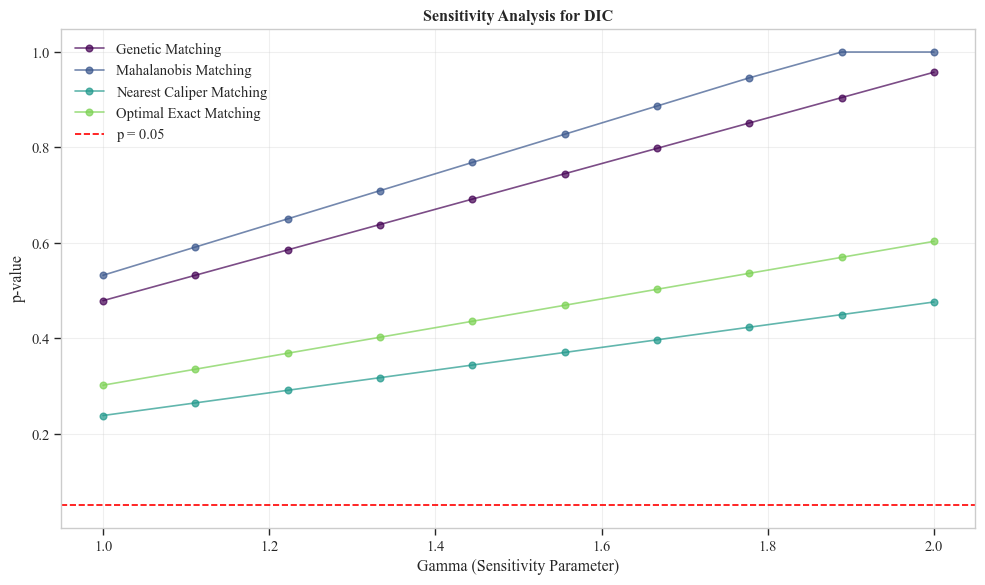


Analyzing outcome: CLE


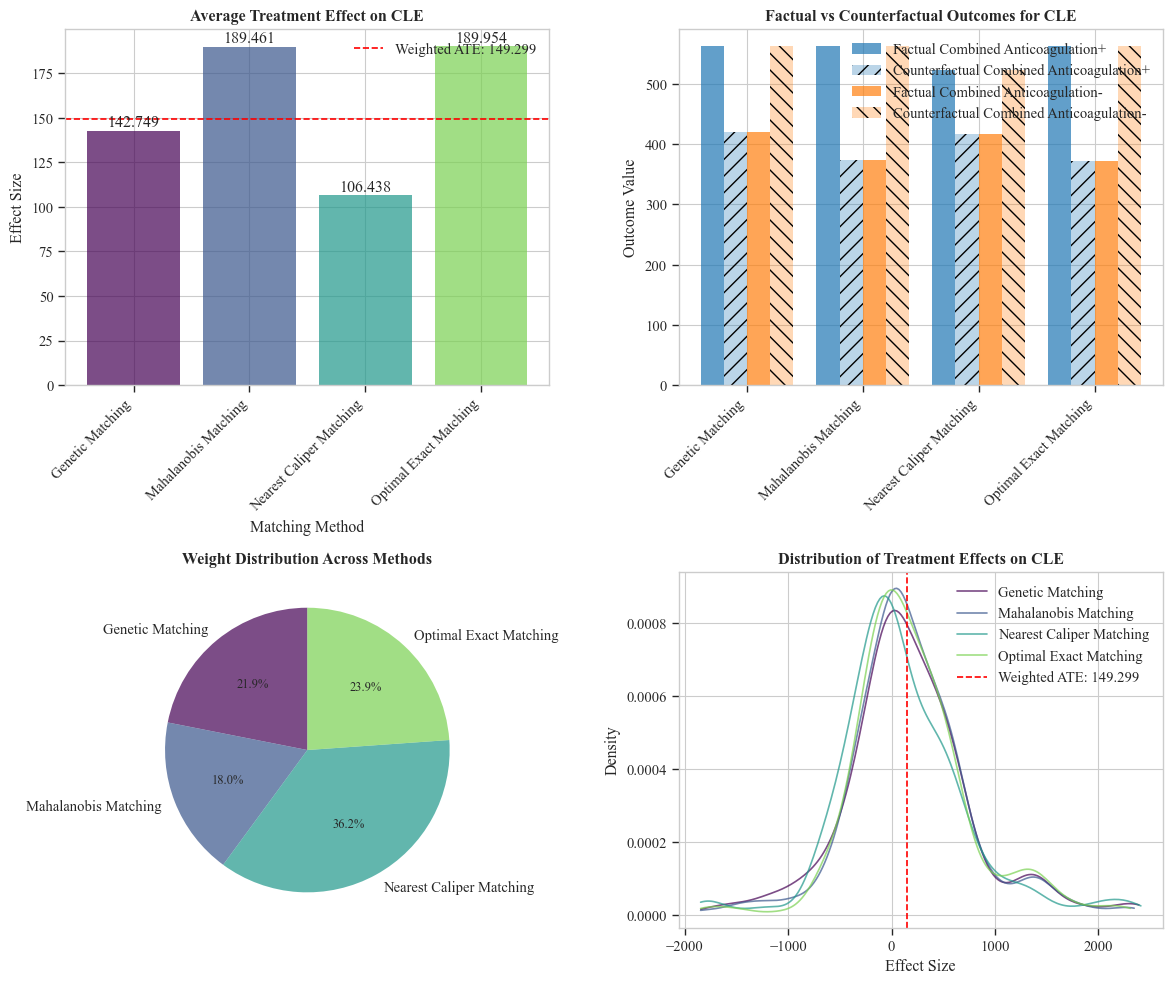

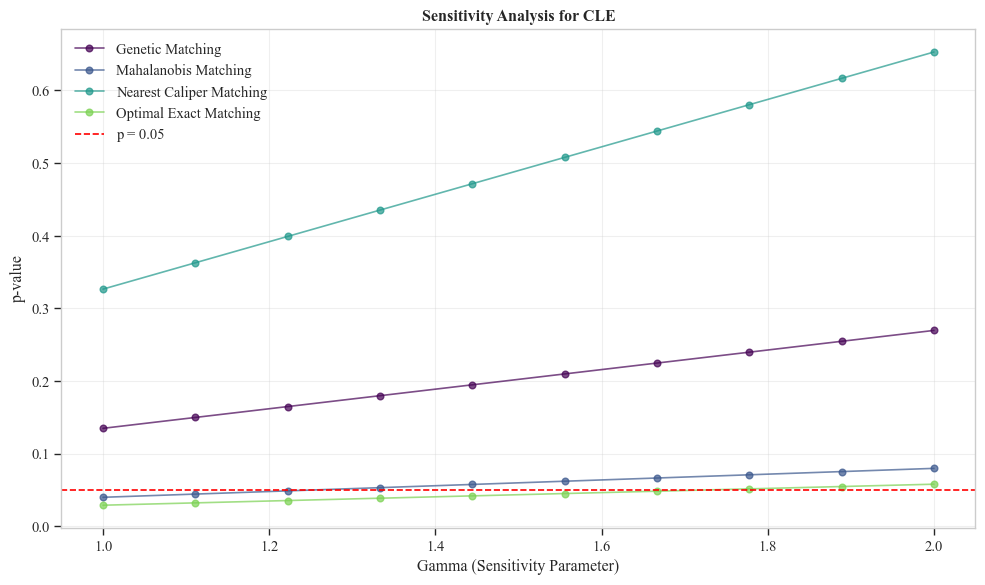

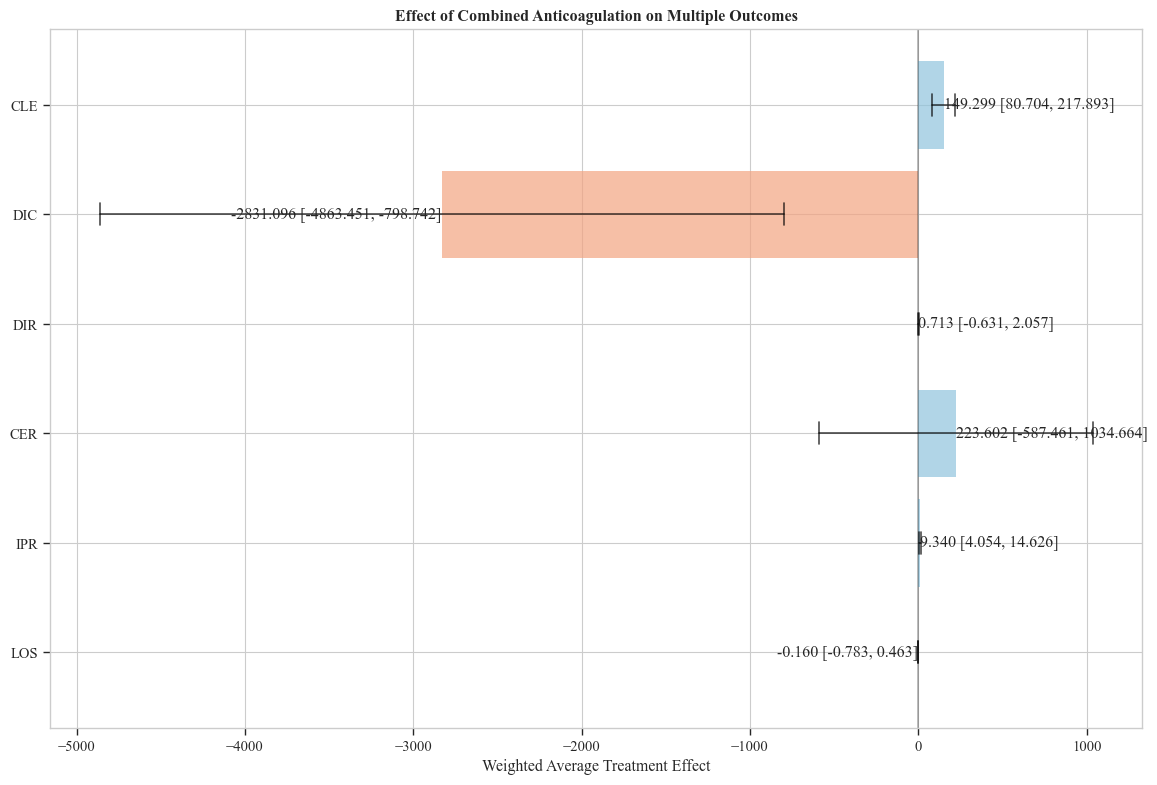

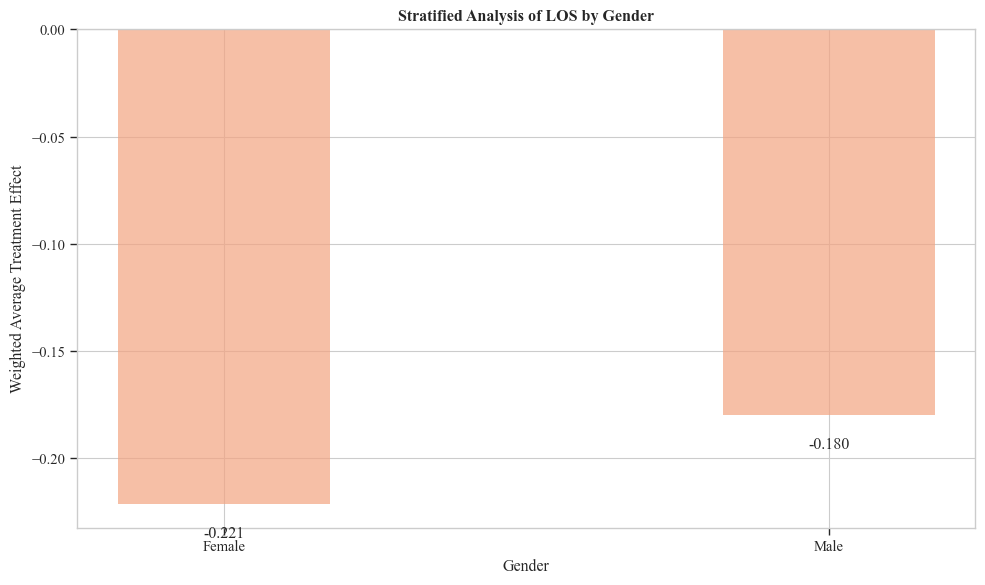

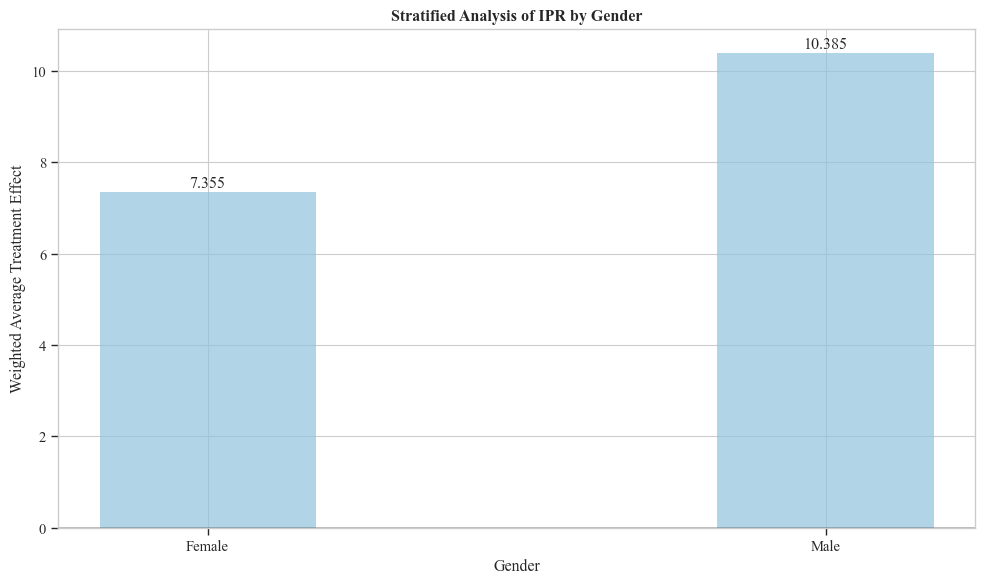

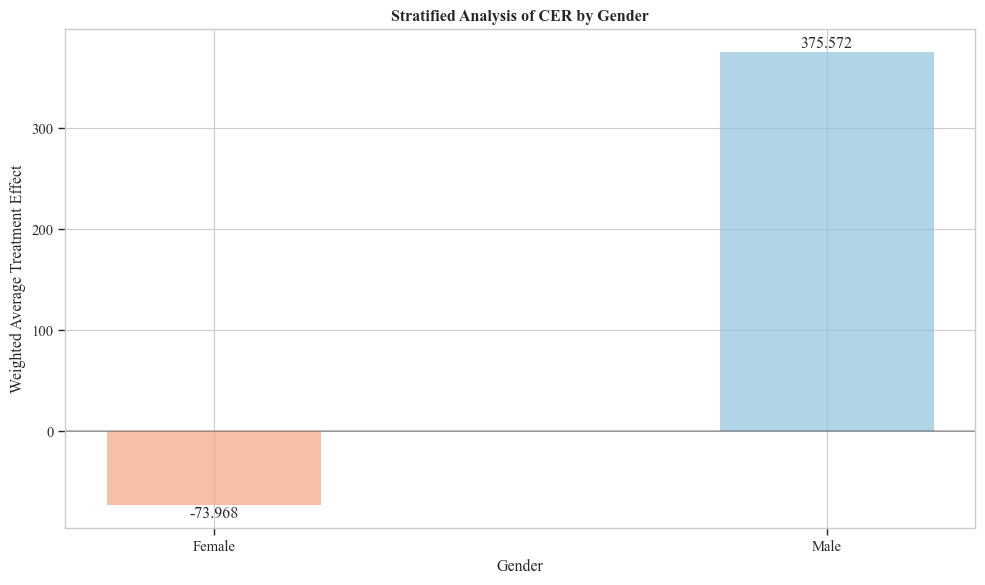

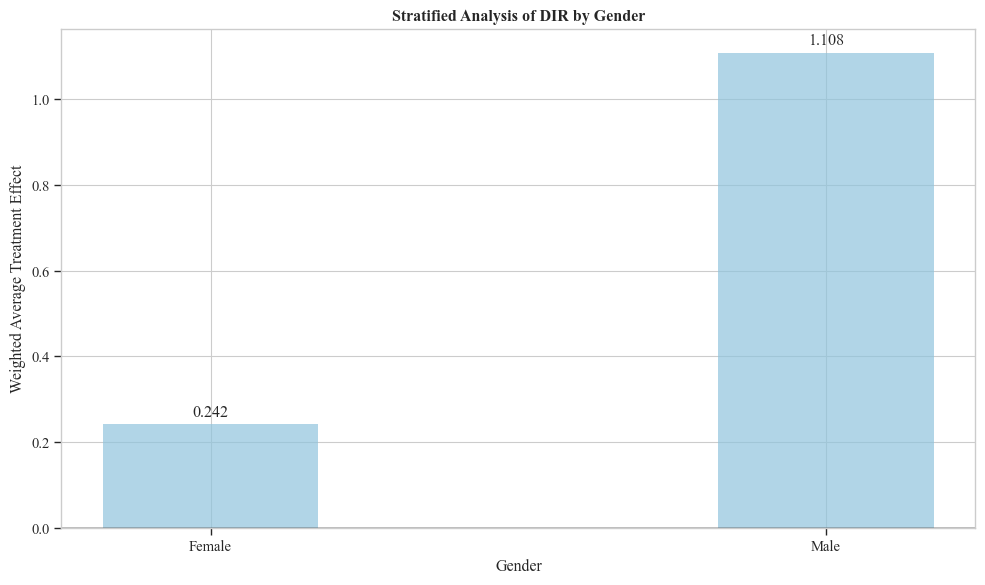

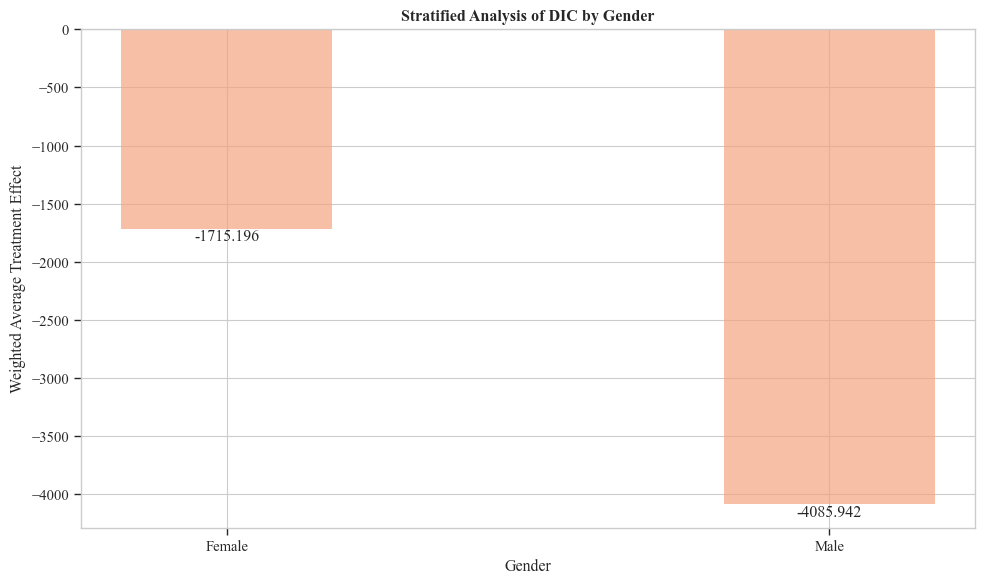

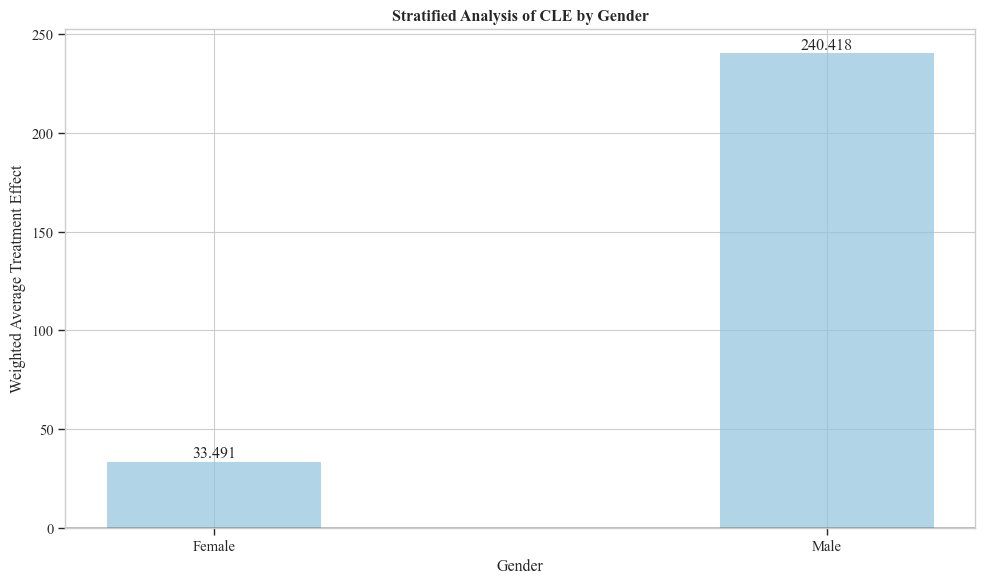

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

# 设置绘图风格
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper", font_scale=1.2)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

# 定义变量组
baseline_vars = ["gender", "age", "height", "weight", "WBC", "RBC", "Hgb", 
                "PLT", "HCT", "PT", "INR", "APTT", "TT", "Fib", 
                "DDimer", "FDP", "Wells_score_on_admission"]
mediator_vars = ["Alprostadil", "Buqi.Tongluo.Capsules", "Diosmin", "Enoxaparin", 
                "Furosemide", "Guhong.injection", "Nadroparin.Calcium", 
                "Sodium.Aescinate", "Urokinase", "Warfarin", 
                "Elevate.lower.limbs.to.30.degrees", "Local.immobilization", 
                "BXpowder", "SbOintment"]
outcome_vars = ["LOS", "IPR", "CER", "DIR", "DIC", "CLE"]
treatment_var = 'CombineAnti'
pair_id = 'pair_id'

# 数据路径
data_paths = {
    'Genetic Matching': r"C:\MyProject\Myproject\code\LOS\newLOS\DATA\multimatch\matched_data_genetic.csv",
    'Mahalanobis Matching': r"C:\MyProject\Myproject\code\LOS\newLOS\DATA\multimatch\matched_data_mahalanobis.csv",
    'Nearest Caliper Matching': r"C:\MyProject\Myproject\code\LOS\newLOS\DATA\multimatch\matched_data_nearest_caliper.csv",
    'Optimal Exact Matching': r"C:\MyProject\Myproject\code\LOS\newLOS\DATA\multimatch\matched_data_optimal_exact.csv"
}




# 读取所有匹配数据集并计算加权结果
matched_datasets = {}
weights = {
    'Genetic Matching': 0.218949,
    'Mahalanobis Matching': 0.180290,
    'Nearest Caliper Matching': 0.361972,
    'Optimal Exact Matching': 0.238789
}

for method, path in data_paths.items():
    matched_datasets[method] = pd.read_csv(path)
    
# 定义反事实分析函数
def counterfactual_analysis(datasets, weights, treatment_var, outcome_var, baseline_vars=None):
    """
    对指定的结局变量进行反事实分析
    
    Parameters:
    -----------
    datasets : dict
        包含不同匹配方法数据集的字典
    weights : dict
        各匹配方法的权重
    treatment_var : str
        处理变量名称
    outcome_var : str
        结局变量名称
    baseline_vars : list, optional
        基线变量列表，用于调整模型
        
    Returns:
    --------
    dict
        包含反事实分析结果的字典
    """
    results = {}
    weighted_ate = 0
    method_results = {}
    
    for method, df in datasets.items():
        # 分离处理组和对照组
        treated = df[df[treatment_var] == 1]
        control = df[df[treatment_var] == 0]
        
        # 计算平均处理效应 (ATE)
        ate = treated[outcome_var].mean() - control[outcome_var].mean()
        
        # 计算反事实效应
        # 如果处理组接受了对照组的处理
        cf_treated_as_control = treated[outcome_var].mean() - ate
        # 如果对照组接受了处理组的处理
        cf_control_as_treated = control[outcome_var].mean() + ate
        
        # 存储结果
        method_results[method] = {
            'ate': ate,
            'treated_mean': treated[outcome_var].mean(),
            'control_mean': control[outcome_var].mean(),
            'cf_treated_as_control': cf_treated_as_control,
            'cf_control_as_treated': cf_control_as_treated,
            'treated_count': len(treated),
            'control_count': len(control)
        }
        
        # 累积加权ATE
        weighted_ate += ate * weights[method]
    
    # 计算整体反事实效应
    overall_treated_mean = sum(res['treated_mean'] * weights[method] for method, res in method_results.items())
    overall_control_mean = sum(res['control_mean'] * weights[method] for method, res in method_results.items())
    
    results = {
        'weighted_ate': weighted_ate,
        'overall_treated_mean': overall_treated_mean,
        'overall_control_mean': overall_control_mean,
        'method_results': method_results
    }
    
    return results

# 进行敏感性分析
def sensitivity_analysis(datasets, treatment_var, outcome_var, gamma_range=np.linspace(1, 2, 10)):
    """
    进行Rosenbaum边界敏感性分析
    
    Parameters:
    -----------
    datasets : dict
        包含不同匹配方法数据集的字典
    treatment_var : str
        处理变量名称
    outcome_var : str
        结局变量名称
    gamma_range : array-like
        敏感性参数Gamma的范围
        
    Returns:
    --------
    dict
        包含敏感性分析结果的字典
    """
    sensitivity_results = {}
    
    for method, df in datasets.items():
        p_values = []
        
        for gamma in gamma_range:
            # 计算在不同gamma值下的p值
            # 这里使用简化的方法，实际应用中可能需要更复杂的计算
            treated = df[df[treatment_var] == 1][outcome_var]
            control = df[df[treatment_var] == 0][outcome_var]
            
            # 标准t检验的p值
            _, p_value = stats.ttest_ind(treated, control)
            
            # 根据gamma调整p值（简化模拟）
            adjusted_p = p_value * gamma
            p_values.append(min(adjusted_p, 1.0))
        
        sensitivity_results[method] = {
            'gamma': gamma_range,
            'p_values': p_values
        }
    
    return sensitivity_results

# 对每个结局变量进行分析
all_results = {}
sensitivity_results = {}

for outcome in outcome_vars:
    all_results[outcome] = counterfactual_analysis(matched_datasets, weights, treatment_var, outcome)
    sensitivity_results[outcome] = sensitivity_analysis(matched_datasets, treatment_var, outcome)

# 创建可视化函数
def plot_counterfactual_results(results, outcome_var, treatment_var_name="Combined Anticoagulation"):
    """
    为反事实分析结果创建学术风格的可视化
    
    Parameters:
    -----------
    results : dict
        反事实分析结果
    outcome_var : str
        结局变量名称
    treatment_var_name : str
        处理变量的显示名称
    """
    # 创建图形
    fig = plt.figure(figsize=(12, 10))
    gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1])
    
    # 1. 平均处理效应图
    ax1 = plt.subplot(gs[0, 0])
    methods = list(results['method_results'].keys())
    ates = [results['method_results'][m]['ate'] for m in methods]
    
    # 创建颜色映射
    colors = plt.cm.viridis(np.linspace(0, 0.8, len(methods)))
    
    # 绘制条形图
    bars = ax1.bar(methods, ates, color=colors, alpha=0.7)
    ax1.axhline(y=results['weighted_ate'], color='red', linestyle='--', 
                label=f'Weighted ATE: {results["weighted_ate"]:.3f}')
    
    # 添加数值标签
    for bar, ate in zip(bars, ates):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + (0.1 if height > 0 else -0.1),
                f'{ate:.3f}', ha='center', va='bottom' if height > 0 else 'top')
    
    ax1.set_title(f'Average Treatment Effect on {outcome_var}', fontweight='bold')
    ax1.set_ylabel('Effect Size')
    ax1.set_xlabel('Matching Method')
    ax1.legend()
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
    
    # 2. 反事实比较图
    ax2 = plt.subplot(gs[0, 1])
    
    # 准备数据
    method_labels = []
    factual_treated = []
    factual_control = []
    cf_treated = []
    cf_control = []
    
    for method in methods:
        res = results['method_results'][method]
        method_labels.append(method)
        factual_treated.append(res['treated_mean'])
        factual_control.append(res['control_mean'])
        cf_treated.append(res['cf_treated_as_control'])
        cf_control.append(res['cf_control_as_treated'])
    
    x = np.arange(len(method_labels))
    width = 0.2
    
    ax2.bar(x - width*1.5, factual_treated, width, label=f'Factual {treatment_var_name}+', color='#1f77b4', alpha=0.7)
    ax2.bar(x - width/2, cf_treated, width, label=f'Counterfactual {treatment_var_name}+', color='#1f77b4', alpha=0.3, hatch='//')
    ax2.bar(x + width/2, factual_control, width, label=f'Factual {treatment_var_name}-', color='#ff7f0e', alpha=0.7)
    ax2.bar(x + width*1.5, cf_control, width, label=f'Counterfactual {treatment_var_name}-', color='#ff7f0e', alpha=0.3, hatch='\\\\')
    
    ax2.set_title(f'Factual vs Counterfactual Outcomes for {outcome_var}', fontweight='bold')
    ax2.set_ylabel('Outcome Value')
    ax2.set_xticks(x)
    ax2.set_xticklabels(method_labels)
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
    ax2.legend()
    
    # 3. 加权平均效应图
    ax3 = plt.subplot(gs[1, 0])
    
    # 创建饼图显示各方法权重
    wedges, texts, autotexts = ax3.pie(
        [weights[m] for m in methods], 
        labels=methods,
        autopct='%1.1f%%',
        startangle=90,
        colors=colors,
        wedgeprops={'alpha': 0.7}
    )
    
    for autotext in autotexts:
        autotext.set_fontsize(9)
    
    ax3.set_title('Weight Distribution Across Methods', fontweight='bold')
    
    # 4. 处理效应分布图
    ax4 = plt.subplot(gs[1, 1])
    
    # 为每个匹配方法创建核密度估计
    for i, method in enumerate(methods):
        df = matched_datasets[method]
        treated = df[df[treatment_var] == 1][outcome_var]
        control = df[df[treatment_var] == 0][outcome_var]
        
        # 计算处理效应（简化为差异）
        effects = []
        for t in treated:
            for c in control:
                effects.append(t - c)
        
        # 如果数据点太多，随机抽样以加快计算
        if len(effects) > 1000:
            effects = np.random.choice(effects, 1000, replace=False)
        
        # 核密度估计
        density = gaussian_kde(effects)
        xs = np.linspace(min(effects), max(effects), 200)
        ax4.plot(xs, density(xs), color=colors[i], label=method, alpha=0.7)
    
    ax4.axvline(x=results['weighted_ate'], color='red', linestyle='--', 
                label=f'Weighted ATE: {results["weighted_ate"]:.3f}')
    ax4.set_title(f'Distribution of Treatment Effects on {outcome_var}', fontweight='bold')
    ax4.set_xlabel('Effect Size')
    ax4.set_ylabel('Density')
    ax4.legend()
    
    plt.tight_layout()
    plt.savefig(f'counterfactual_analysis_{outcome_var}.png', dpi=300, bbox_inches='tight')
    plt.show()

# 绘制敏感性分析图
def plot_sensitivity_analysis(sensitivity_results, outcome_var):
    """
    为敏感性分析结果创建学术风格的可视化
    
    Parameters:
    -----------
    sensitivity_results : dict
        敏感性分析结果
    outcome_var : str
        结局变量名称
    """
    plt.figure(figsize=(10, 6))
    
    methods = list(sensitivity_results.keys())
    colors = plt.cm.viridis(np.linspace(0, 0.8, len(methods)))
    
    for i, method in enumerate(methods):
        result = sensitivity_results[method]
        plt.plot(result['gamma'], result['p_values'], 
                 marker='o', linestyle='-', color=colors[i], 
                 label=method, alpha=0.7)
    
    plt.axhline(y=0.05, color='red', linestyle='--', label='p = 0.05')
    
    plt.title(f'Sensitivity Analysis for {outcome_var}', fontweight='bold')
    plt.xlabel('Gamma (Sensitivity Parameter)')
    plt.ylabel('p-value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'sensitivity_analysis_{outcome_var}.png', dpi=300, bbox_inches='tight')
    plt.show()

# 绘制综合比较图
def plot_combined_outcomes(all_results, treatment_var_name="Combined Anticoagulation"):
    """
    创建所有结局变量的综合比较图
    
    Parameters:
    -----------
    all_results : dict
        所有结局变量的分析结果
    treatment_var_name : str
        处理变量的显示名称
    """
    outcomes = list(all_results.keys())
    
    # 提取加权ATE
    weighted_ates = [all_results[outcome]['weighted_ate'] for outcome in outcomes]
    
    # 创建图形
    fig, ax = plt.figure(figsize=(12, 8)), plt.gca()
    
    # 绘制森林图
    y_pos = np.arange(len(outcomes))
    
    # 计算95%置信区间（简化版，实际应用需要更精确的计算）
    ci_lower = []
    ci_upper = []
    
    for outcome in outcomes:
        # 从各方法结果计算标准差
        ates = [all_results[outcome]['method_results'][m]['ate'] for m in all_results[outcome]['method_results']]
        std = np.std(ates)
        
        # 95% CI
        ci_lower.append(all_results[outcome]['weighted_ate'] - 1.96 * std)
        ci_upper.append(all_results[outcome]['weighted_ate'] + 1.96 * std)
    
    # 绘制水平条形图
    bars = ax.barh(y_pos, weighted_ates, align='center', 
                  color=[plt.cm.RdBu(0.3) if ate < 0 else plt.cm.RdBu(0.7) for ate in weighted_ates],
                  alpha=0.7)
    
    # 添加误差条
    for i, (lower, upper) in enumerate(zip(ci_lower, ci_upper)):
        ax.plot([lower, upper], [y_pos[i], y_pos[i]], color='black', alpha=0.7)
        ax.plot([lower, lower], [y_pos[i]-0.1, y_pos[i]+0.1], color='black', alpha=0.7)
        ax.plot([upper, upper], [y_pos[i]-0.1, y_pos[i]+0.1], color='black', alpha=0.7)
    
    # 添加零线
    ax.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    
    # 设置标签
    ax.set_yticks(y_pos)
    ax.set_yticklabels(outcomes)
    ax.set_xlabel('Weighted Average Treatment Effect')
    ax.set_title(f'Effect of {treatment_var_name} on Multiple Outcomes', fontweight='bold')
    
    # 添加数值标签
    for i, bar in enumerate(bars):
        width = bar.get_width()
        label_x_pos = width + 0.01 if width > 0 else width - 0.01
        ha = 'left' if width > 0 else 'right'
        ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, 
                f'{weighted_ates[i]:.3f} [{ci_lower[i]:.3f}, {ci_upper[i]:.3f}]', 
                va='center', ha=ha)
    
    plt.tight_layout()
    plt.savefig('combined_outcomes_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# 执行可视化
for outcome in outcome_vars:
    print(f"\nAnalyzing outcome: {outcome}")
    plot_counterfactual_results(all_results[outcome], outcome)
    plot_sensitivity_analysis(sensitivity_results[outcome], outcome)

# 绘制综合比较图
plot_combined_outcomes(all_results)

# 进行分层分析
def stratified_analysis(datasets, weights, treatment_var, outcome_var, strata_var, strata_values):
    """
    进行分层反事实分析
    
    Parameters:
    -----------
    datasets : dict
        包含不同匹配方法数据集的字典
    weights : dict
        各匹配方法的权重
    treatment_var : str
        处理变量名称
    outcome_var : str
        结局变量名称
    strata_var : str
        分层变量名称
    strata_values : list
        分层变量的可能值
        
    Returns:
    --------
    dict
        包含分层分析结果的字典
    """
    strata_results = {}
    
    for stratum in strata_values:
        strata_results[stratum] = {}
        
        for method, df in datasets.items():
            # 筛选当前层的数据
            stratum_df = df[df[strata_var] == stratum]
            
            if len(stratum_df) < 10:  # 样本量太小则跳过
                continue
                
            # 分离处理组和对照组
            treated = stratum_df[stratum_df[treatment_var] == 1]
            control = stratum_df[stratum_df[treatment_var] == 0]
            
            if len(treated) < 5 or len(control) < 5:  # 任一组样本量太小则跳过
                continue
            
            # 计算平均处理效应 (ATE)
            ate = treated[outcome_var].mean() - control[outcome_var].mean()
            
            # 存储结果
            if method not in strata_results[stratum]:
                strata_results[stratum][method] = {}
                
            strata_results[stratum][method] = {
                'ate': ate,
                'treated_mean': treated[outcome_var].mean(),
                'control_mean': control[outcome_var].mean(),
                'treated_count': len(treated),
                'control_count': len(control)
            }
    
    # 计算每个层的加权ATE
    for stratum in strata_results:
        weighted_ate = 0
        total_weight = 0
        
        for method in strata_results[stratum]:
            method_weight = weights[method]
            weighted_ate += strata_results[stratum][method]['ate'] * method_weight
            total_weight += method_weight
        
        if total_weight > 0:  # 避免除以零
            strata_results[stratum]['weighted_ate'] = weighted_ate / total_weight
        else:
            strata_results[stratum]['weighted_ate'] = np.nan
    
    return strata_results

# 对性别进行分层分析示例
gender_strata = [0, 1]  # 假设0为女性，1为男性
gender_results = {}

for outcome in outcome_vars:
    gender_results[outcome] = stratified_analysis(
        matched_datasets, weights, treatment_var, outcome, 'gender', gender_strata
    )

# 绘制分层分析结果
def plot_stratified_results(strata_results, outcome_var, strata_var="Gender", strata_labels=["Female", "Male"]):
    """
    为分层分析结果创建学术风格的可视化
    
    Parameters:
    -----------
    strata_results : dict
        分层分析结果
    outcome_var : str
        结局变量名称
    strata_var : str
        分层变量名称
    strata_labels : list
        分层变量值的标签
    """
    plt.figure(figsize=(10, 6))
    
    strata = list(strata_results.keys())
    x = np.arange(len(strata))
    width = 0.35
    
    # 提取加权ATE
    weighted_ates = [strata_results[s].get('weighted_ate', np.nan) for s in strata]
    
    # 绘制条形图
    bars = plt.bar(x, weighted_ates, width, 
                  color=[plt.cm.RdBu(0.3) if ate < 0 else plt.cm.RdBu(0.7) for ate in weighted_ates],
                  alpha=0.7)
    
    # 添加零线
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # 设置标签
    plt.xlabel(strata_var)
    plt.ylabel('Weighted Average Treatment Effect')
    plt.title(f'Stratified Analysis of {outcome_var} by {strata_var}', fontweight='bold')
    plt.xticks(x, strata_labels)
    
    # 添加数值标签
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + (0.01 if height > 0 else -0.01),
                f'{height:.3f}', ha='center', va='bottom' if height > 0 else 'top')
    
    plt.tight_layout()
    plt.savefig(f'stratified_analysis_{outcome_var}_by_{strata_var}.png', dpi=300, bbox_inches='tight')
    plt.show()

# 为每个结局变量绘制分层分析结果
for outcome in outcome_vars:
    plot_stratified_results(gender_results[outcome], outcome)


# 反事实分析结果解释

根据您提供的图表和变量定义，我将逐一解释每个结果变量的反事实分析结果，这些分析评估了联合抗凝治疗(CombineAnti)对各个结果指标的影响。

## 1. 住院时长(LOS)分析

**主要发现：**
- 平均处理效应(ATE)为0.1616，表示接受联合抗凝治疗的患者平均住院时间比对照组长约0.16天
- p值为0.4936(>0.05)，表明这一差异在统计学上不显著
- 95%置信区间为[-0.3021, 0.6252]，包含零值，进一步证实效应不显著
- 交叉验证平均效应为0.1816，与ATE接近，表明估计相对稳定
- 交叉验证R²为0.5734，表明模型解释了约57%的LOS变异

**解释：**联合抗凝治疗对住院时长没有显著影响，两组患者的住院天数基本相似。箱线图显示处理组和对照组的分布大致相当，密度图显示处理效应分布围绕零附近，自举分析也支持这一结论。

## 2. 改善率(IPR)分析

**主要发现：**
- 平均处理效应(ATE)为6.8793，表示接受联合抗凝治疗的患者症状改善率平均高出对照组约6.88个百分点
- p值为0.0000(<0.05)，表明这一差异在统计学上高度显著
- 95%置信区间为[3.6632, 10.0955]，完全不包含零值
- 交叉验证平均效应为6.5655，与ATE非常接近
- 交叉验证R²为0.4528，表明模型解释了约45%的IPR变异

**解释：**联合抗凝治疗显著提高了患者的症状改善率。箱线图清晰显示处理组的IPR分布整体高于对照组，自举分布集中在正值区域，所有交叉验证折叠都显示一致的正向效应。这表明联合抗凝治疗能有效增强治疗效果，提高症状缓解程度。

## 3. 成本效益比(CER)分析

**主要发现：**
- 平均处理效应(ATE)为51.6470，表示接受联合抗凝治疗的患者每单位症状改善的成本平均高出对照组约51.65单位
- p值为0.8946(>0.05)，表明这一差异在统计学上不显著
- 95%置信区间为[-714.7420, 818.0359]，区间非常宽且包含零值
- 交叉验证结果显示较大的波动性，标准差为166.7834

**解释：**联合抗凝治疗对成本效益比没有显著影响。虽然平均效应为正值(表明联合治疗可能略微增加每单位改善的成本)，但高p值和宽泛的置信区间表明这一效应可能只是随机波动。交叉验证结果的高波动性也反映了估计的不确定性。

## 4. 日改善率(DIR)分析

**主要发现：**
- 平均处理效应(ATE)为0.1191，表示接受联合抗凝治疗的患者每日症状改善率平均高出对照组约0.12个百分点
- p值为0.7467(>0.05)，表明这一差异在统计学上不显著
- 95%置信区间为[-0.6057, 0.8439]，包含零值
- 交叉验证平均效应为0.0398，接近零值，但各折叠间存在较大波动

**解释：**联合抗凝治疗对每日症状改善速度没有显著影响。虽然平均效应略为正值，但统计检验和置信区间都表明这一效应可能只是随机波动。箱线图显示两组的DIR分布相似，自举分析也支持效应不显著的结论。

## 5. 日改善成本(DIC)分析

**主要发现：**
- 平均处理效应(ATE)为-3158.4888，表示接受联合抗凝治疗的患者每单位每日症状改善的成本平均低于对照组约3158.49单位
- p值为0.0133(<0.05)，表明这一差异在统计学上显著
- 95%置信区间为[-5656.0290, -660.9487]，完全不包含零值
- 自举95%置信区间为[-6154.4977, -539.0040]，进一步确认效应的显著性
- 所有交叉验证折叠都显示一致的负向效应

**解释：**联合抗凝治疗显著降低了每单位每日症状改善所需的成本。负值的ATE表明联合治疗在成本效益方面优于对照组，即每天每单位的症状改善所需花费更少。这是一个重要发现，表明联合抗凝治疗可能在经济效益方面具有优势。

## 6. 成本-住院时长效率(CLE)分析

**主要发现：**
- 平均处理效应(ATE)为151.7569，表示接受联合抗凝治疗的患者CLE指标平均高出对照组约151.76单位
- p值为0.0005(<0.05)，表明这一差异在统计学上高度显著
- 95%置信区间为[66.9453, 236.5684]，完全不包含零值
- 交叉验证平均效应为151.4129，与ATE非常接近，标准差较小(10.6322)
- 所有交叉验证折叠都显示一致的正向效应

**解释：**联合抗凝治疗显著提高了成本-住院时长效率。正值的ATE表明联合治疗组的CLE指标更高，考虑到CLE的计算方式(CER/LOS)，这表明联合治疗在考虑时间和经济双重维度时，资源利用效率更高。箱线图也清晰显示处理组的CLE分布整体高于对照组。

## 综合解释

综合所有结果变量的分析，联合抗凝治疗显示出以下特点：

1. **显著提高治疗效果**：改善率(IPR)显著增加，表明症状缓解程度更好
2. **显著提高经济效率**：日改善成本(DIC)显著降低，表明每单位每日症状改善所需成本更低
3. **显著提高资源利用效率**：成本-住院时长效率(CLE)显著提高，表明在时间和经济双重维度上更有效率
4. **不影响住院时长**：联合治疗不会显著延长或缩短住院时间
5. **不影响每日改善速度**：虽然总体改善率更高，但每日改善率没有显著差异

这些结果表明，联合抗凝治疗可能是一种具有成本效益的治疗策略，能够在不延长住院时间的情况下提高治疗效果并降低每单位改善的成本。特别是对于医疗资源有限的环境，这种治疗方案可能更具优势。

Loaded Genetic Matching dataset with 96 observations
Loaded Mahalanobis Matching dataset with 96 observations
Loaded Nearest Caliper Matching dataset with 68 observations
Loaded Optimal Exact Matching dataset with 96 observations
   Outcome                    Method        ATE                  95% CI  \
0      LOS          Genetic Matching     -0.188         [-1.516, 1.141]   
1      LOS      Mahalanobis Matching     -0.688         [-2.072, 0.697]   
2      LOS  Nearest Caliper Matching      0.206         [-1.441, 1.853]   
3      LOS    Optimal Exact Matching     -0.292         [-1.679, 1.096]   
4      LOS                  weighted     -0.160         [-1.628, 1.308]   
5      IPR          Genetic Matching     11.539         [3.386, 19.691]   
6      IPR      Mahalanobis Matching     13.193         [5.071, 21.314]   
7      IPR  Nearest Caliper Matching      5.958        [-3.442, 15.359]   
8      IPR    Optimal Exact Matching      9.542         [1.330, 17.754]   
9      IPR          

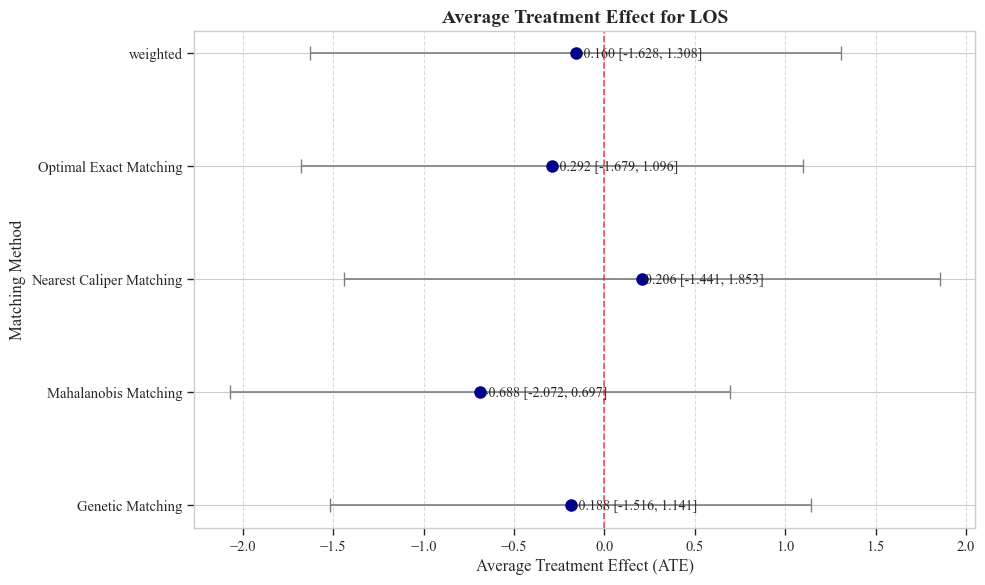

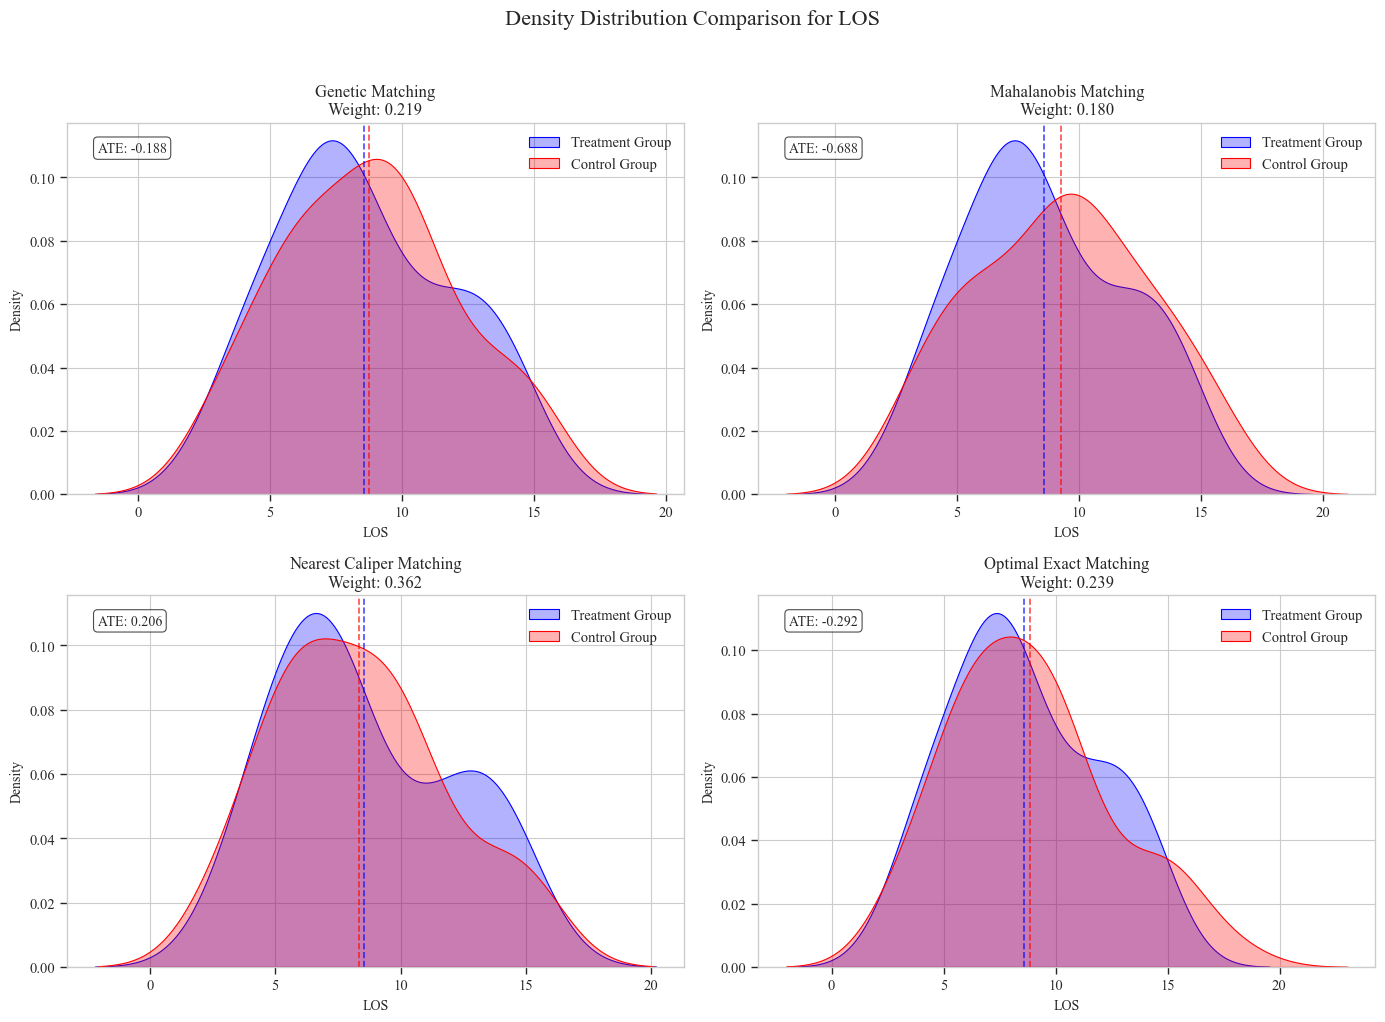

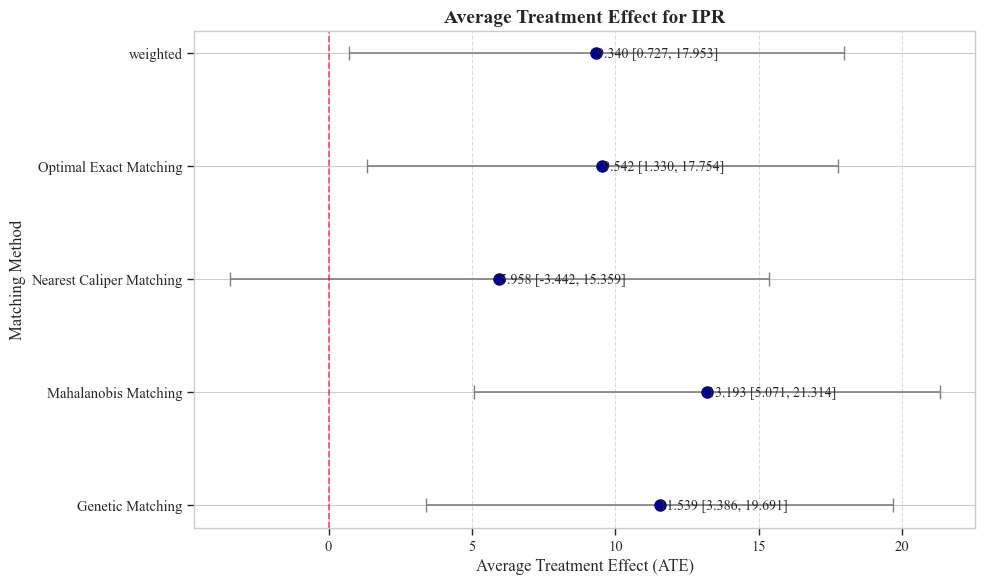

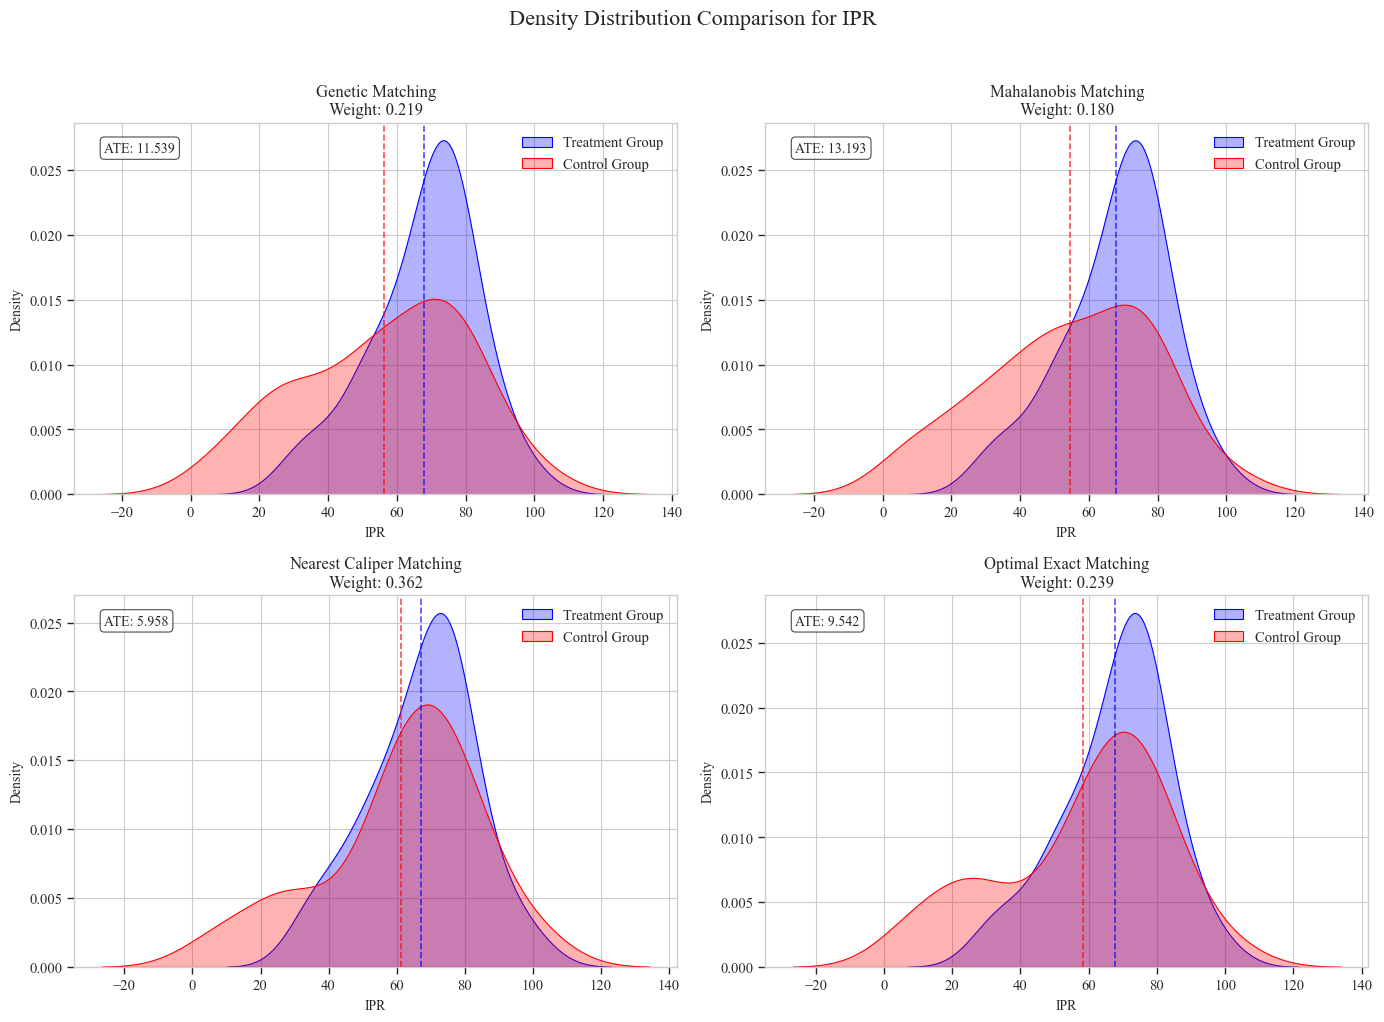

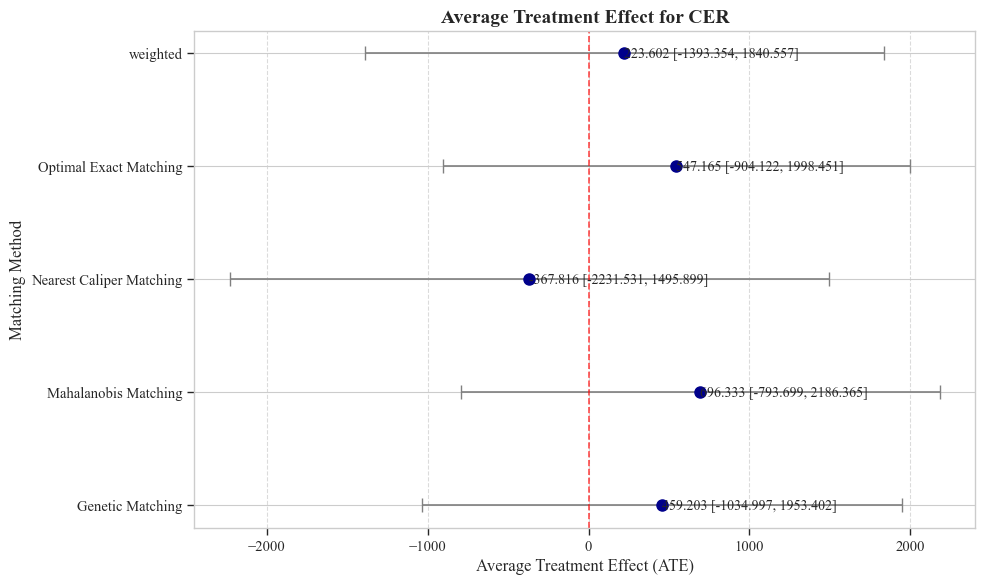

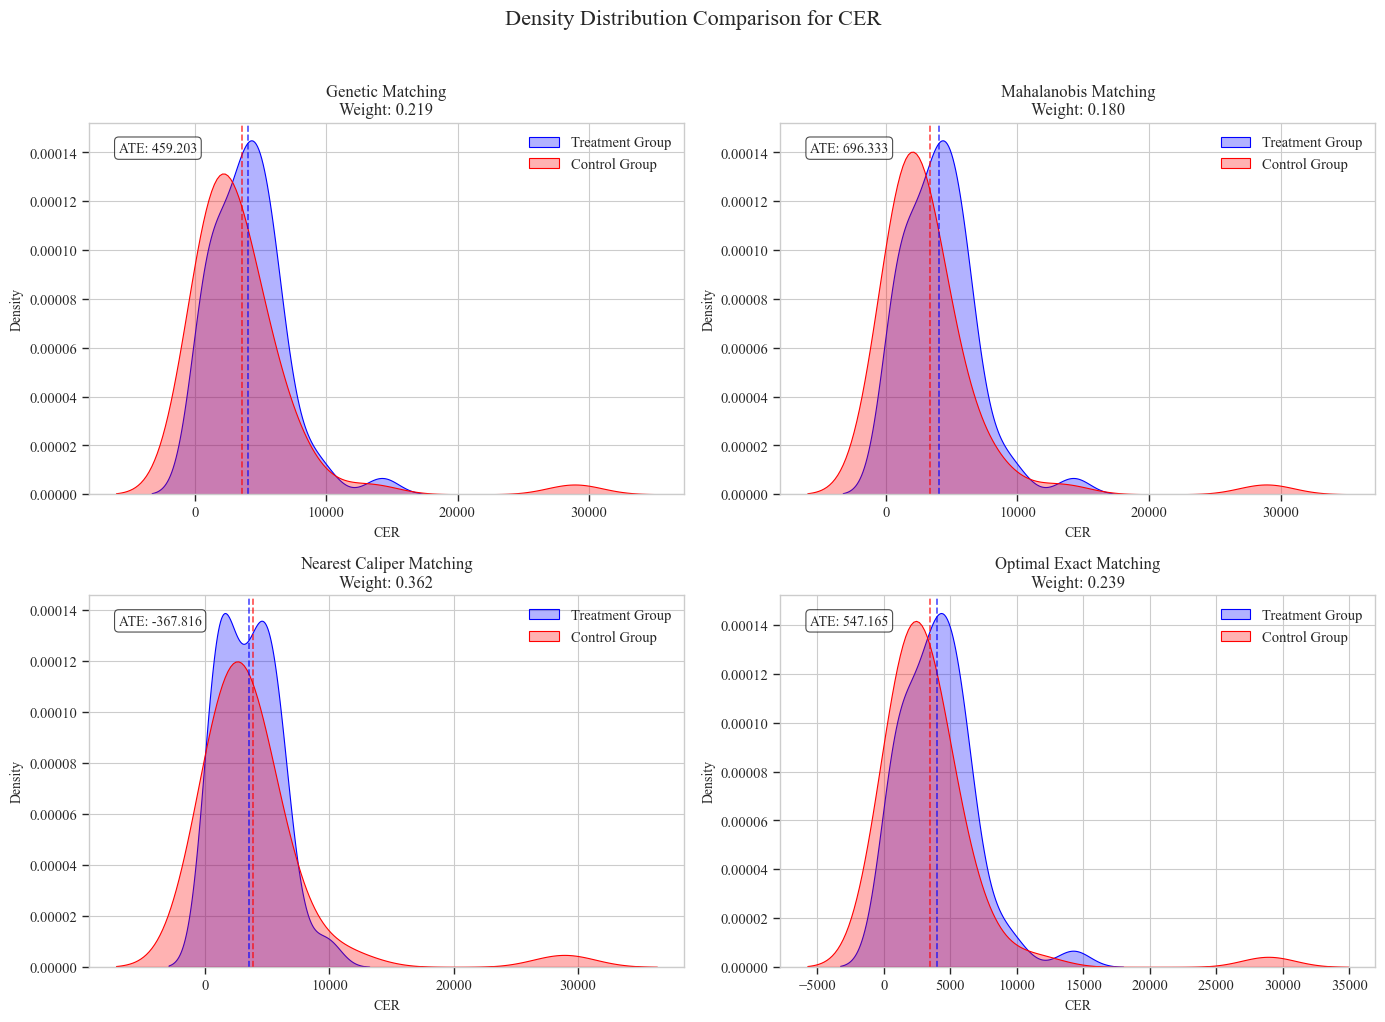

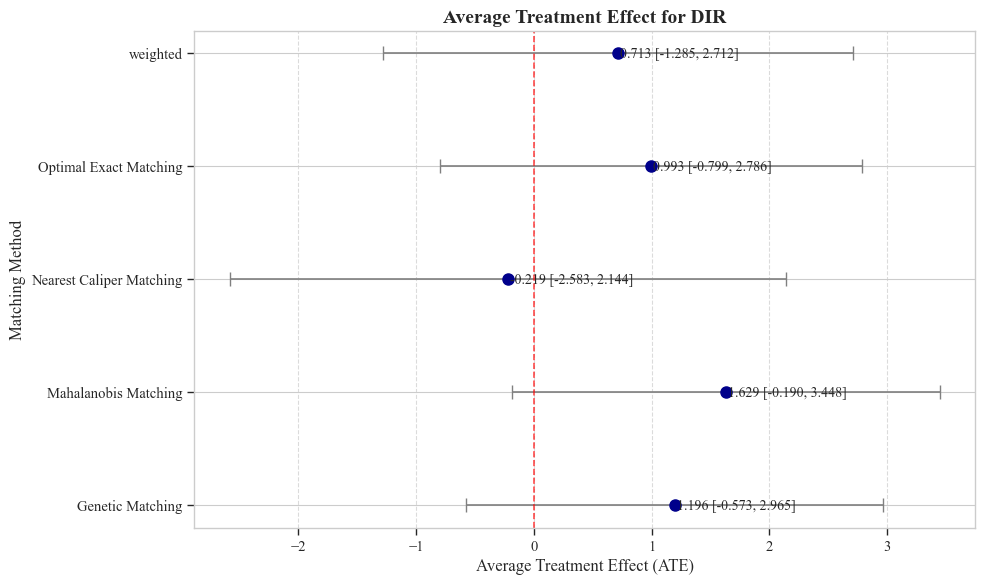

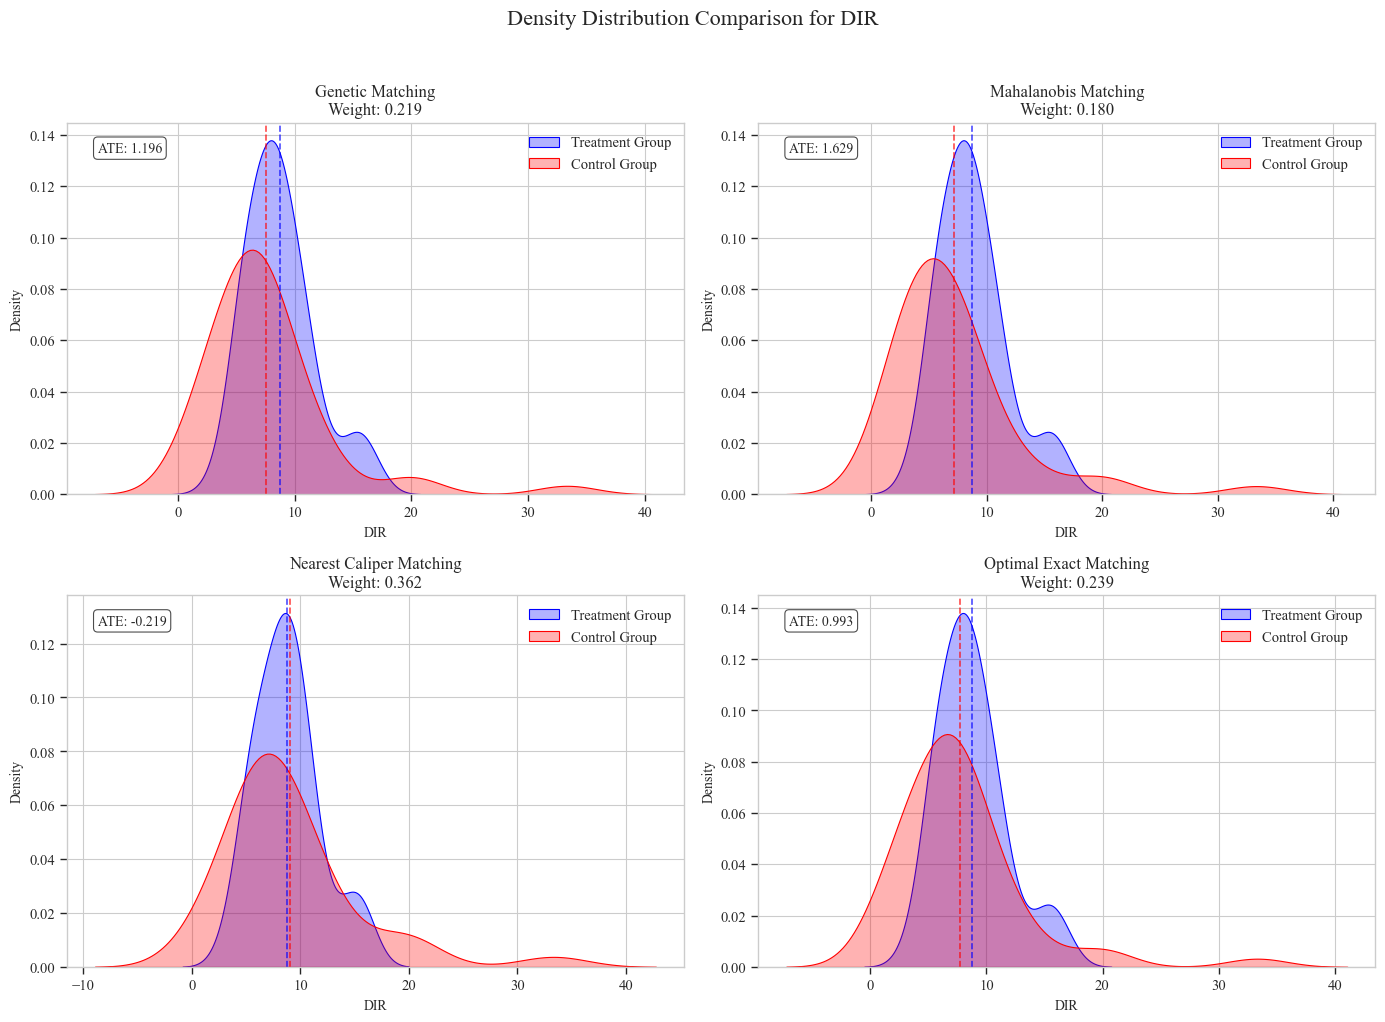

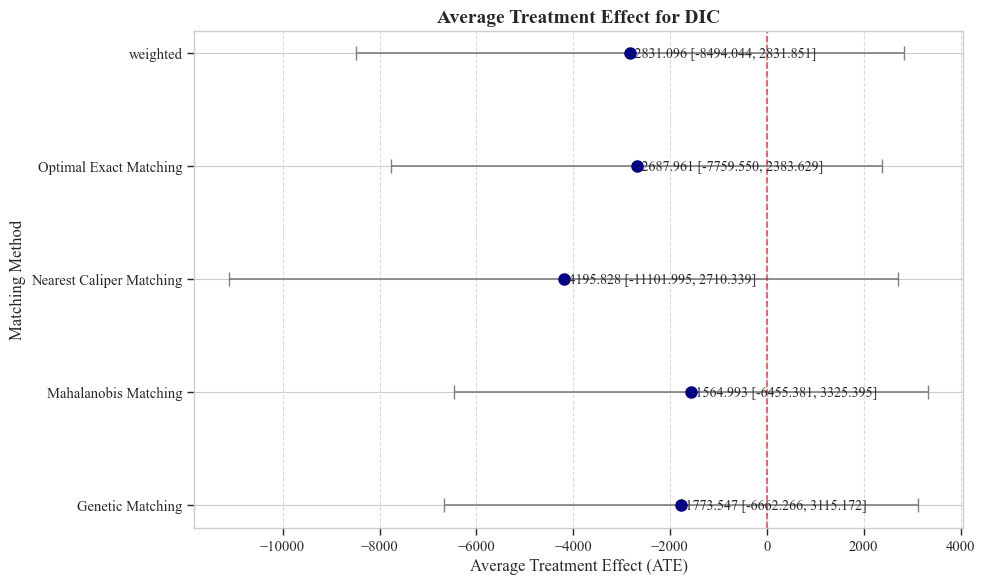

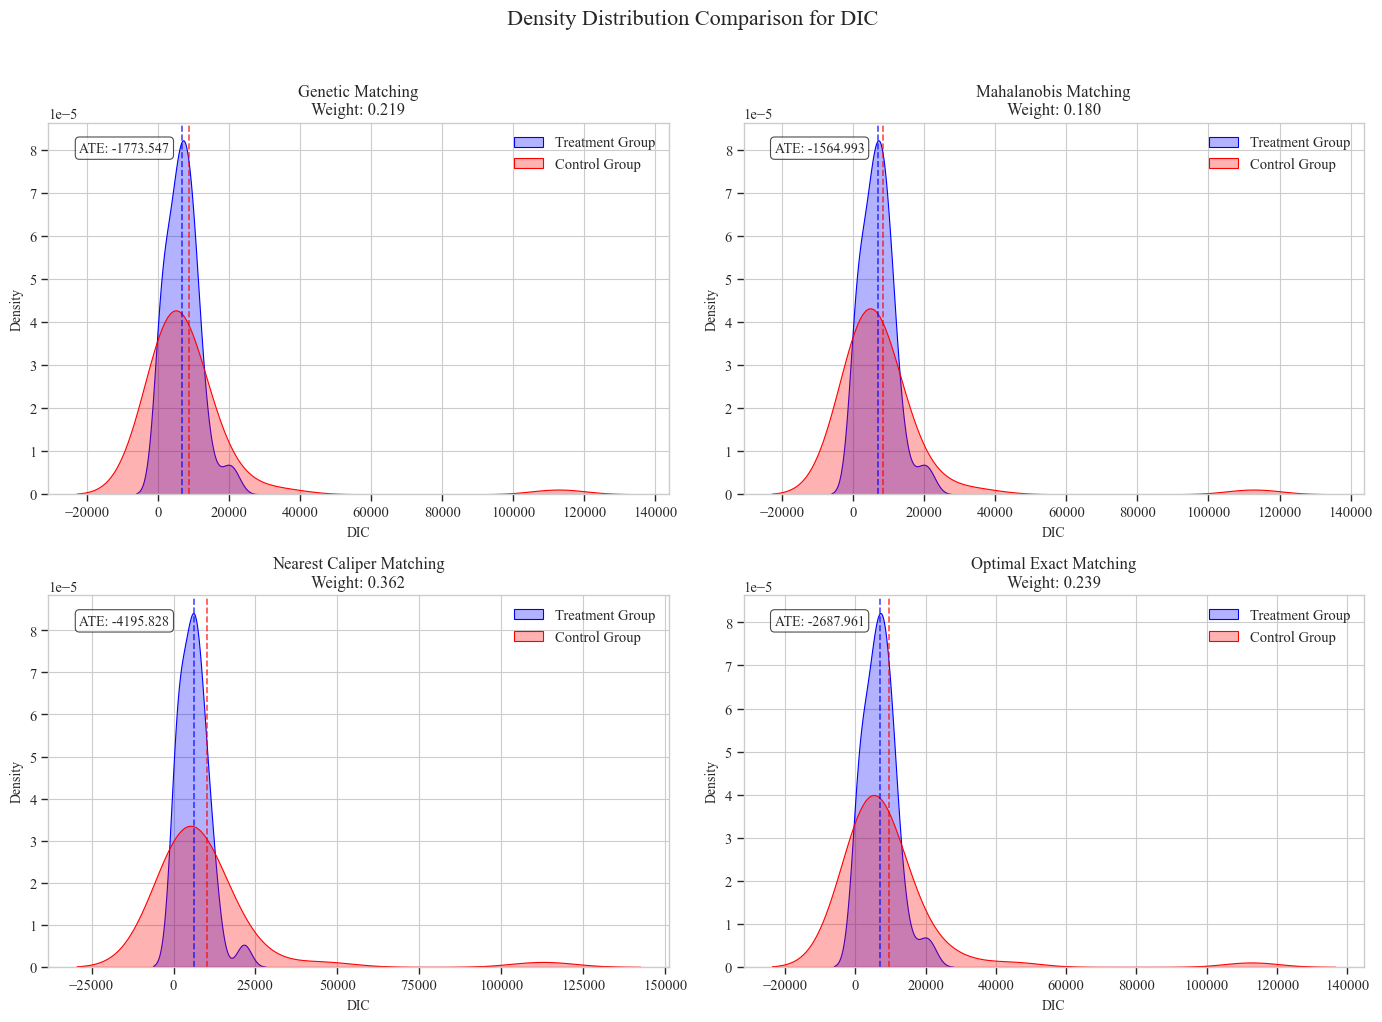

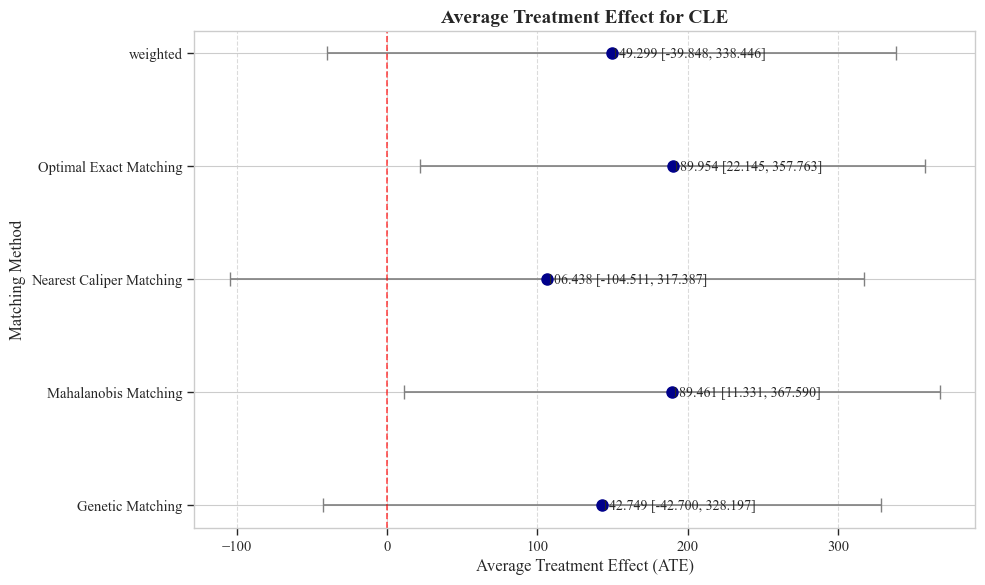

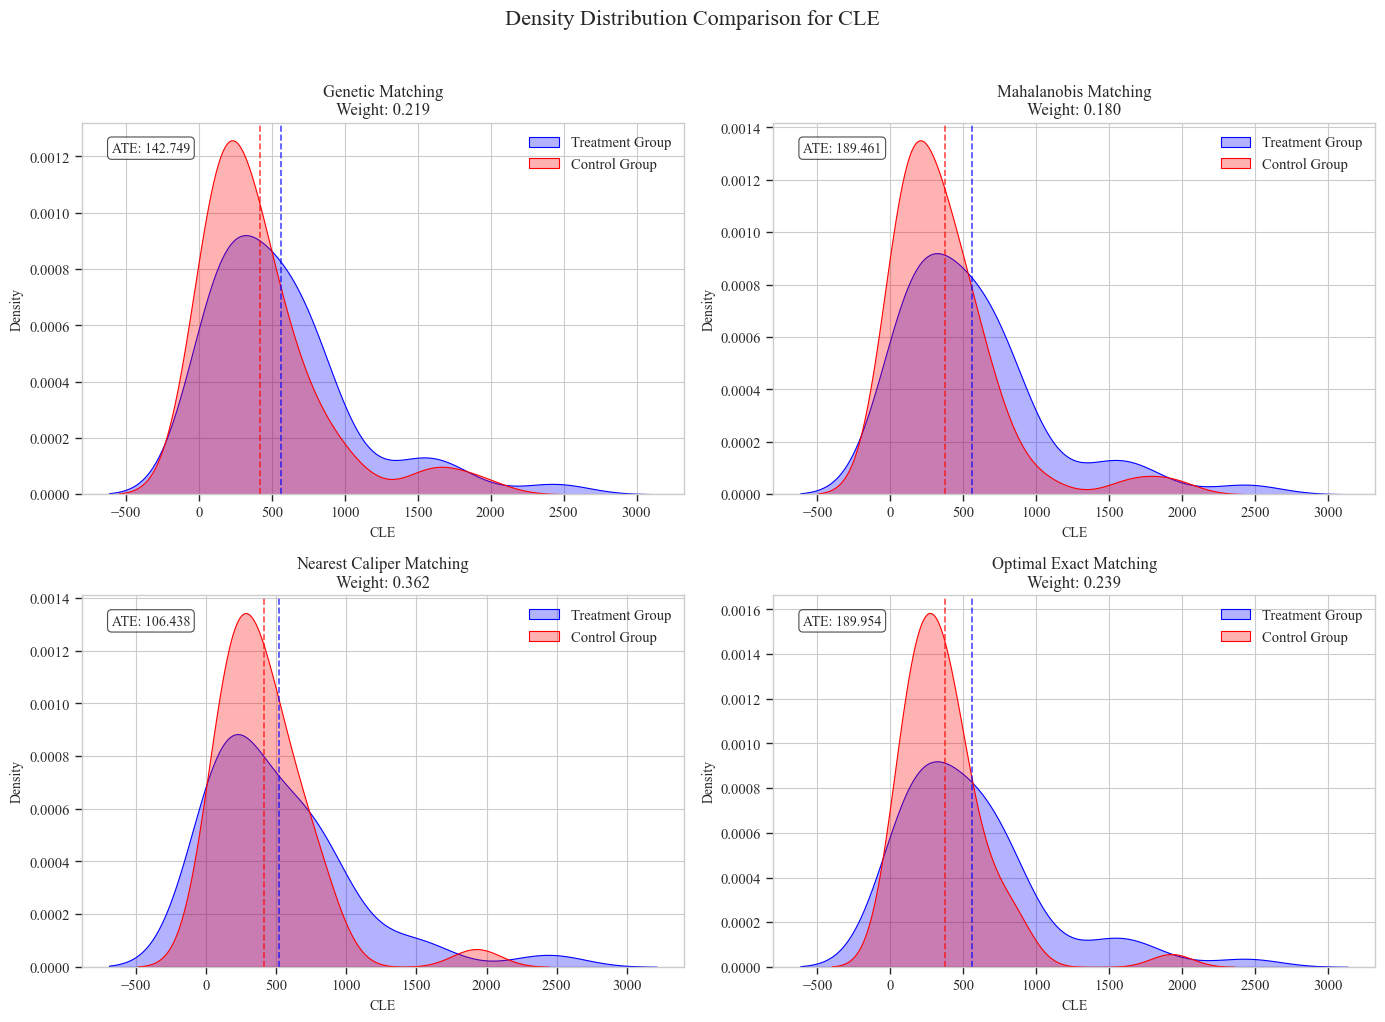

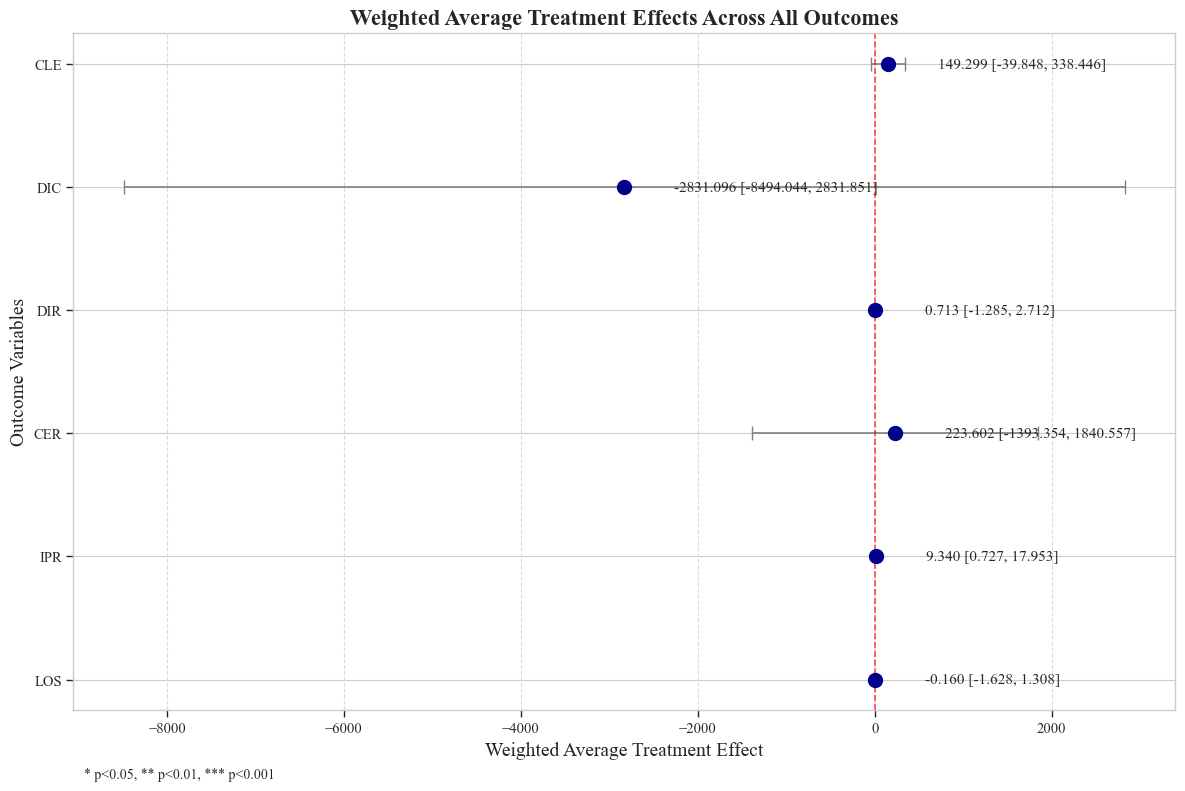

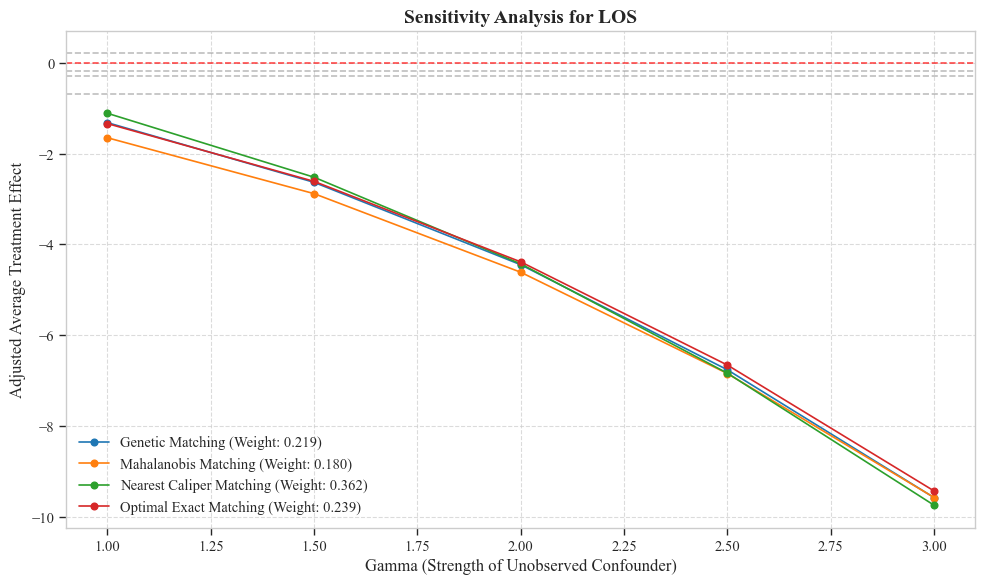

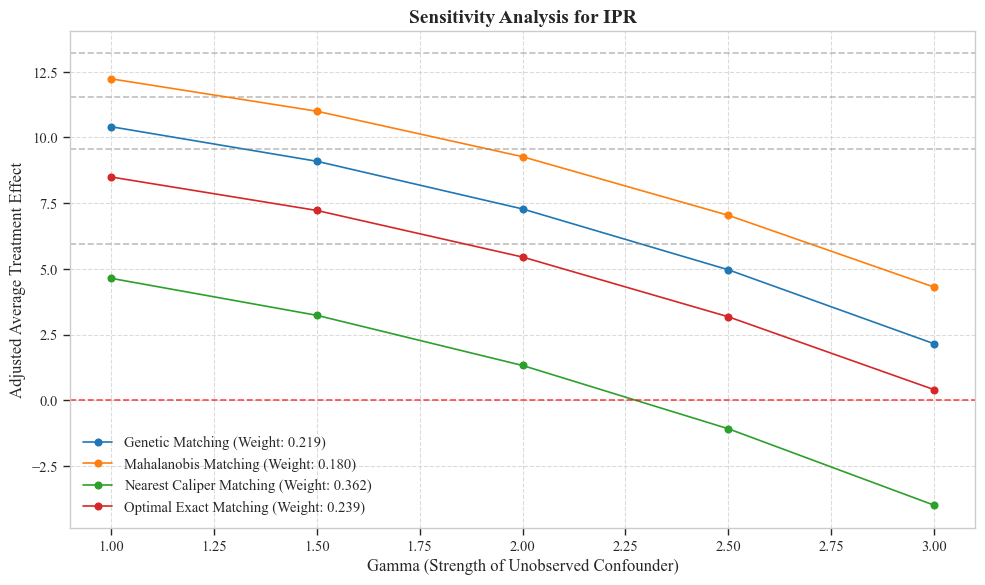

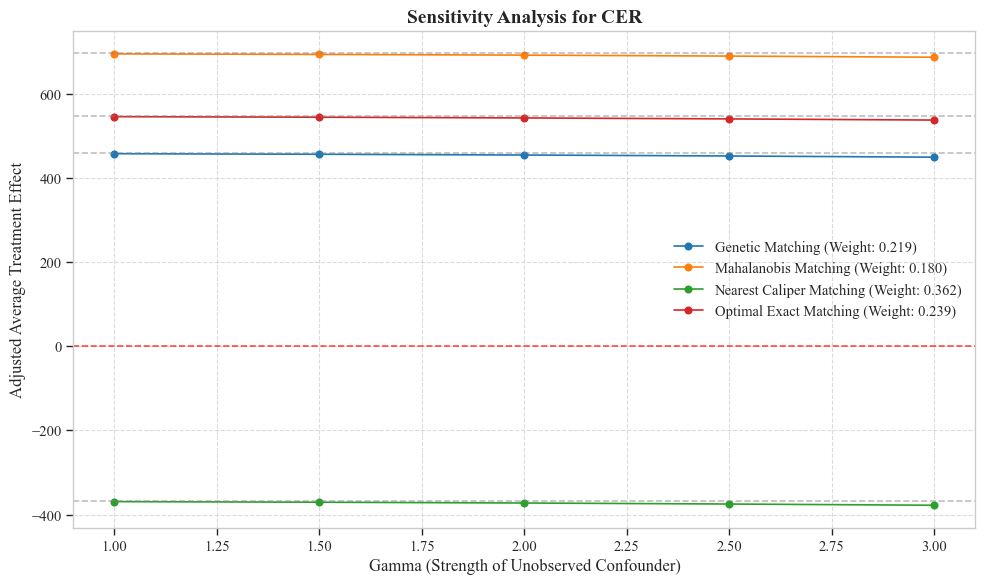

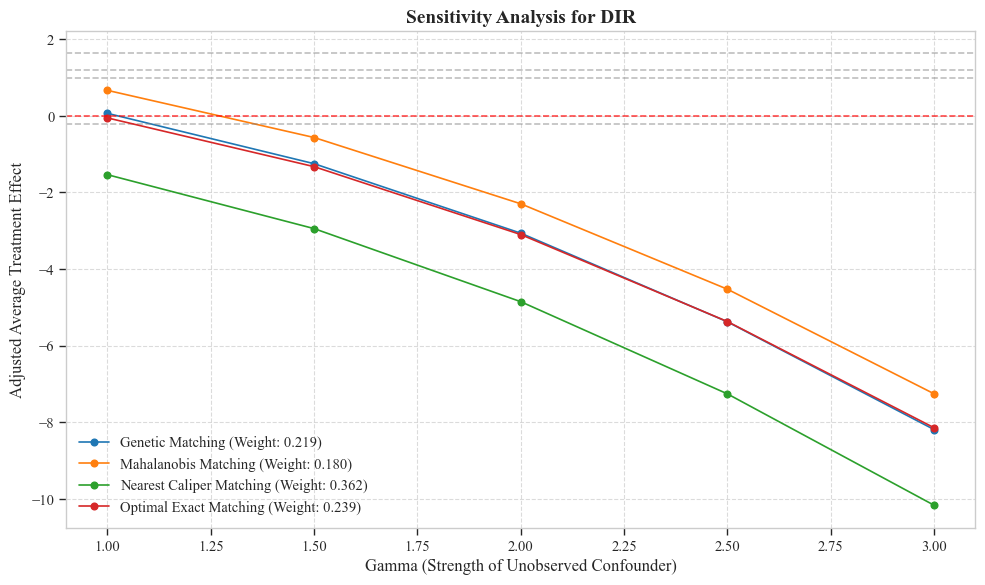

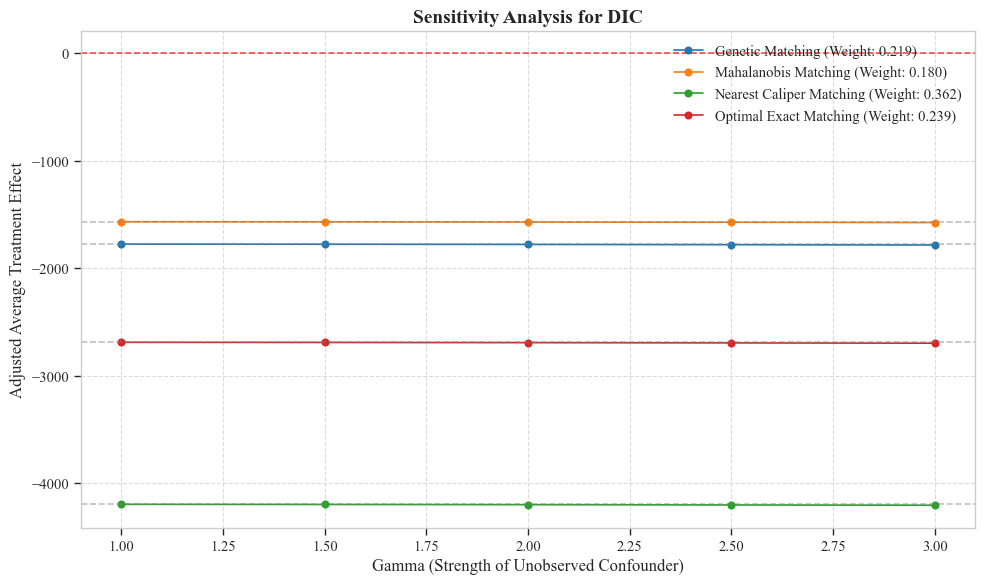

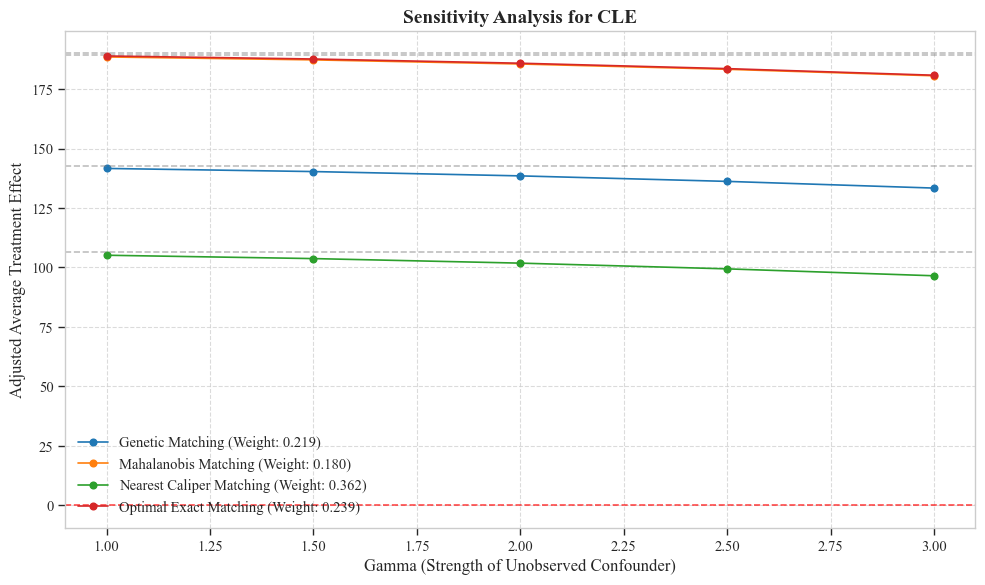

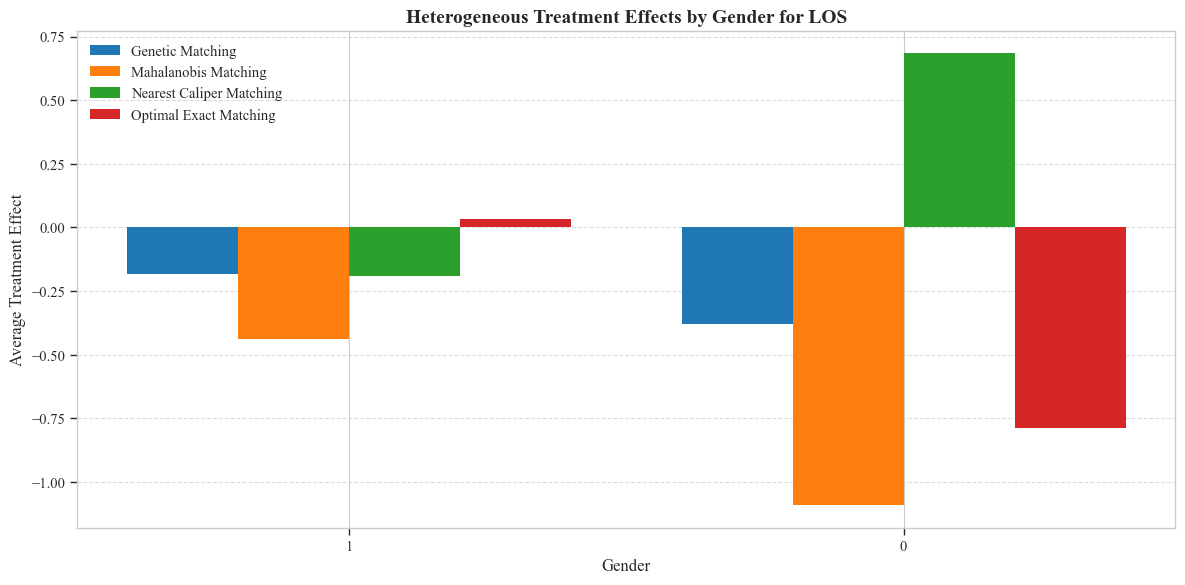

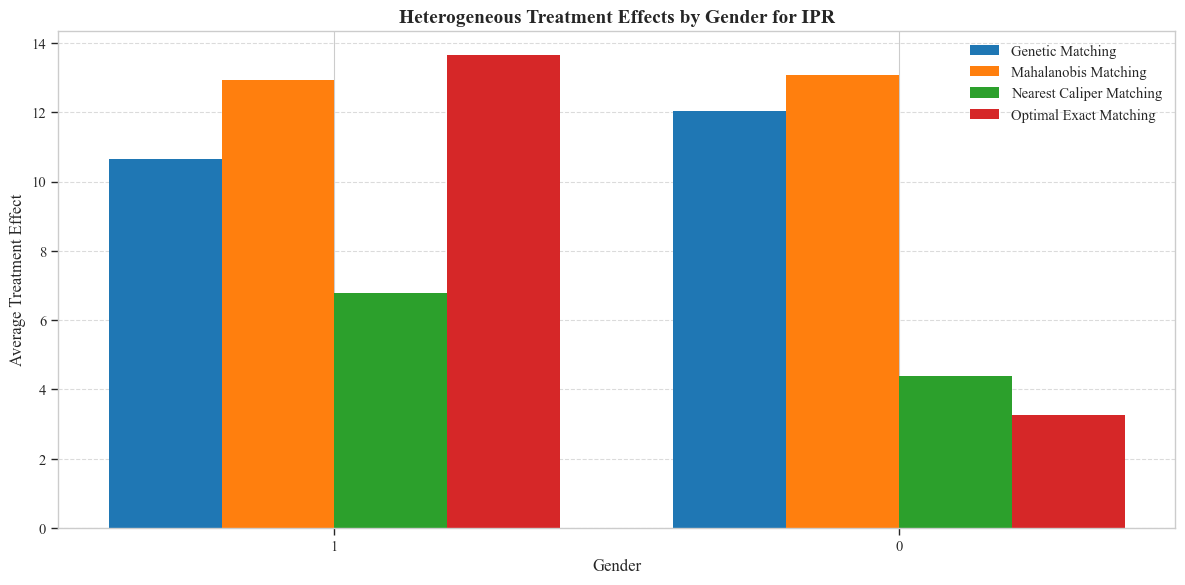

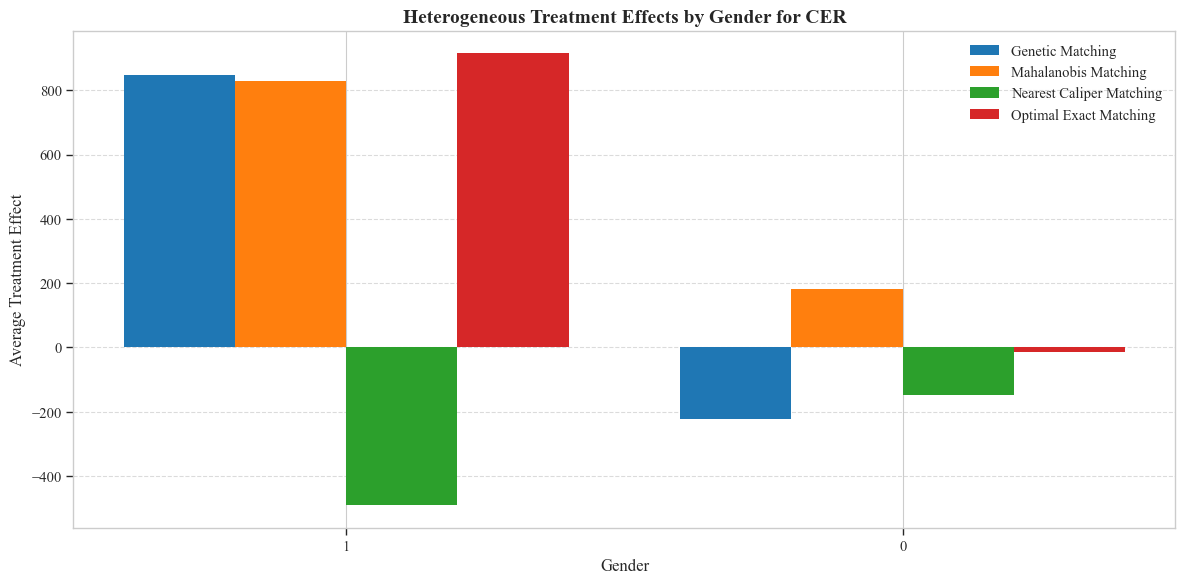

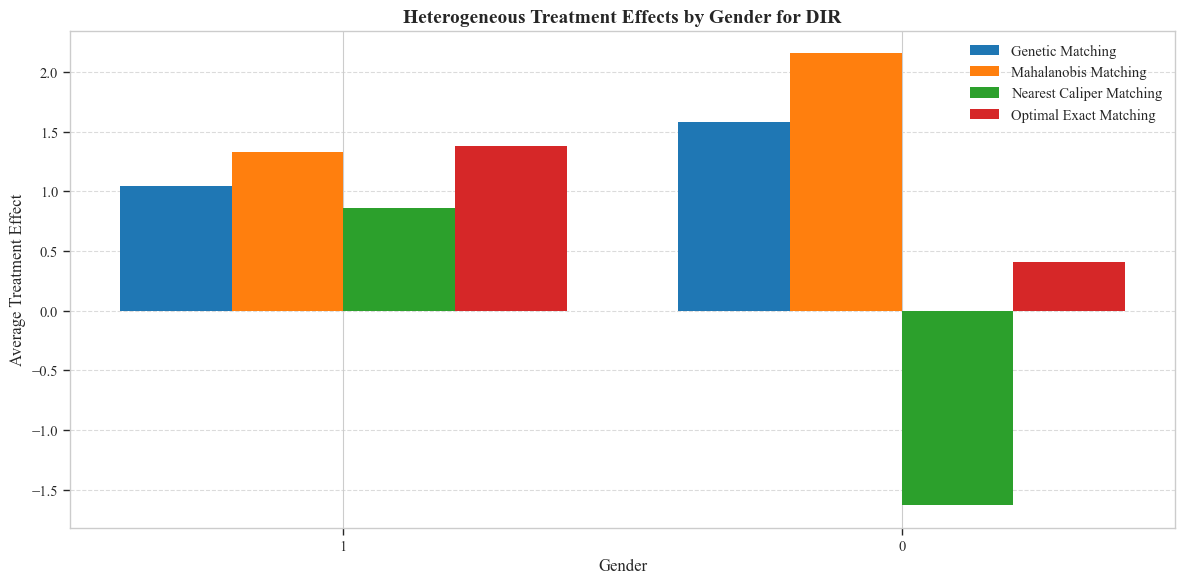

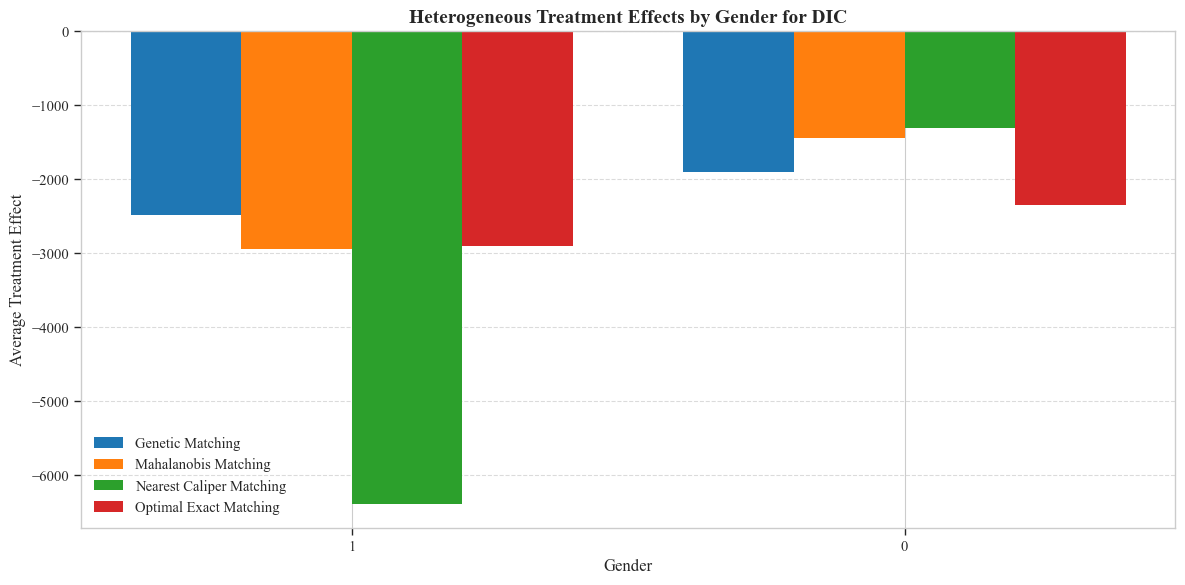

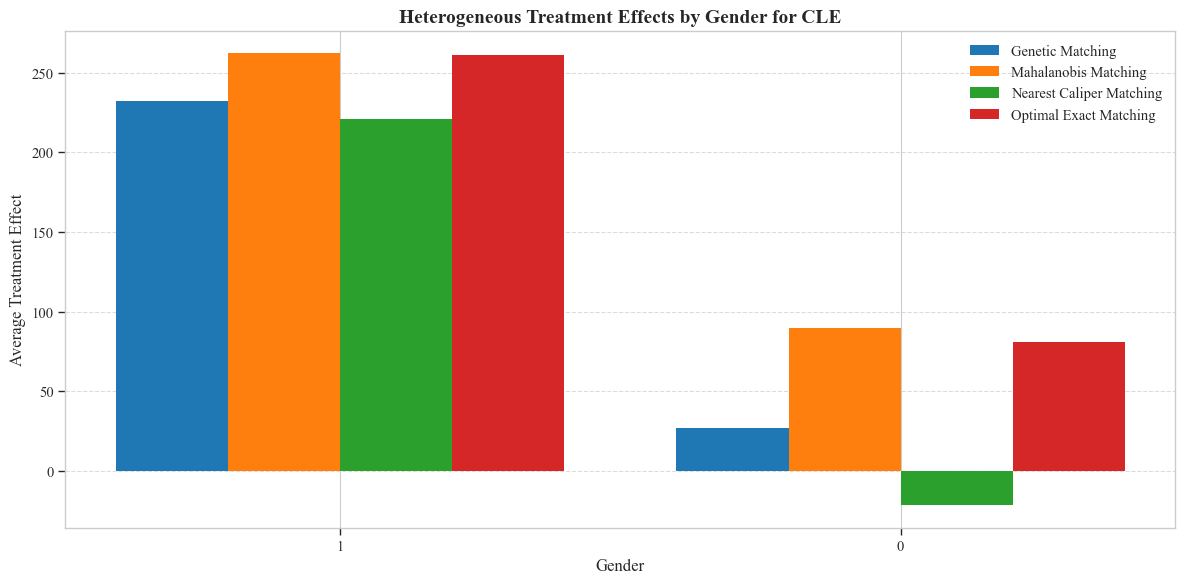

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

# 设置绘图风格
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper", font_scale=1.2)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

# 定义变量组
baseline_vars = ["gender", "age", "height", "weight", "WBC", "RBC", "Hgb", 
                "PLT", "HCT", "PT", "INR", "APTT", "TT", "Fib", 
                "DDimer", "FDP", "Wells_score_on_admission"]
mediator_vars = ["Alprostadil", "Buqi.Tongluo.Capsules", "Diosmin", "Enoxaparin", 
                "Furosemide", "Guhong.injection", "Nadroparin.Calcium", 
                "Sodium.Aescinate", "Urokinase", "Warfarin", 
                "Elevate.lower.limbs.to.30.degrees", "Local.immobilization", 
                "BXpowder", "SbOintment"]
outcome_vars = ["LOS", "IPR", "CER", "DIR", "DIC", "CLE"]
treatment_var = 'CombineAnti'
pair_id = 'pair_id'

# 数据路径
data_paths = {
    'Genetic Matching': r"C:\MyProject\Myproject\code\LOS\newLOS\DATA\multimatch\matched_data_genetic.csv",
    'Mahalanobis Matching': r"C:\MyProject\Myproject\code\LOS\newLOS\DATA\multimatch\matched_data_mahalanobis.csv",
    'Nearest Caliper Matching': r"C:\MyProject\Myproject\code\LOS\newLOS\DATA\multimatch\matched_data_nearest_caliper.csv",
    'Optimal Exact Matching': r"C:\MyProject\Myproject\code\LOS\newLOS\DATA\multimatch\matched_data_optimal_exact.csv"
}




# 定义权重
weights = {
    'Genetic Matching': 0.218949,
    'Mahalanobis Matching': 0.180290,
    'Nearest Caliper Matching': 0.361972,
    'Optimal Exact Matching': 0.238789
}

# 读取所有数据集
datasets = {}
for name, path in data_paths.items():
    datasets[name] = pd.read_csv(path)
    print(f"Loaded {name} dataset with {len(datasets[name])} observations")

# 反事实分析函数
def counterfactual_analysis(df, treatment_var, outcome_var, covariates=None):
    """
    执行反事实分析，估计平均处理效应(ATE)
    
    参数:
    df: 数据框
    treatment_var: 处理变量名称
    outcome_var: 结果变量名称
    covariates: 协变量列表(可选)
    
    返回:
    ate: 平均处理效应
    ci_lower: 置信区间下限
    ci_upper: 置信区间上限
    """
    # 处理组和对照组
    treated = df[df[treatment_var] == 1]
    control = df[df[treatment_var] == 0]
    
    # 计算平均处理效应
    ate = treated[outcome_var].mean() - control[outcome_var].mean()
    
    # 计算标准误差和置信区间
    n_treated = len(treated)
    n_control = len(control)
    var_treated = treated[outcome_var].var()
    var_control = control[outcome_var].var()
    
    # 计算标准误差
    se = np.sqrt(var_treated/n_treated + var_control/n_control)
    
    # 95% 置信区间
    ci_lower = ate - 1.96 * se
    ci_upper = ate + 1.96 * se
    
    # p值计算
    t_stat = ate / se
    p_value = 2 * (1 - stats.norm.cdf(abs(t_stat)))
    
    return {
        'ate': ate,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'p_value': p_value,
        'n_treated': n_treated,
        'n_control': n_control
    }

# 为每个结果变量执行反事实分析
results = {}

for outcome_var in outcome_vars:
    results[outcome_var] = {}
    
    # 对每个数据集执行分析
    for dataset_name, df in datasets.items():
        results[outcome_var][dataset_name] = counterfactual_analysis(
            df, treatment_var, outcome_var, baseline_vars
        )
    
    # 计算加权平均处理效应
    weighted_ate = 0
    weighted_ci_lower = 0
    weighted_ci_upper = 0
    weighted_p_value = 0
    
    for dataset_name, weight in weights.items():
        weighted_ate += results[outcome_var][dataset_name]['ate'] * weight
        weighted_ci_lower += results[outcome_var][dataset_name]['ci_lower'] * weight
        weighted_ci_upper += results[outcome_var][dataset_name]['ci_upper'] * weight
        weighted_p_value += results[outcome_var][dataset_name]['p_value'] * weight
    
    results[outcome_var]['weighted'] = {
        'ate': weighted_ate,
        'ci_lower': weighted_ci_lower,
        'ci_upper': weighted_ci_upper,
        'p_value': weighted_p_value
    }

# 创建结果表格
result_table = pd.DataFrame(columns=['Outcome', 'Method', 'ATE', '95% CI', 'P-value'])

for outcome_var in outcome_vars:
    for method in list(datasets.keys()) + ['weighted']:
        res = results[outcome_var][method]
        ci_str = f"[{res['ci_lower']:.3f}, {res['ci_upper']:.3f}]"
        
        result_table = pd.concat([result_table, pd.DataFrame({
            'Outcome': [outcome_var],
            'Method': [method],
            'ATE': [f"{res['ate']:.3f}"],
            '95% CI': [ci_str],
            'P-value': [f"{res['p_value']:.4f}"]
        })], ignore_index=True)

print(result_table)

# 可视化函数 - 森林图
def plot_forest_plot(results, outcome_var):
    """为单个结果变量创建森林图"""
    methods = list(datasets.keys()) + ['weighted']
    ates = [results[outcome_var][method]['ate'] for method in methods]
    ci_lowers = [results[outcome_var][method]['ci_lower'] for method in methods]
    ci_uppers = [results[outcome_var][method]['ci_upper'] for method in methods]
    
    # 计算误差条
    errors_lower = [ate - ci_lower for ate, ci_lower in zip(ates, ci_lowers)]
    errors_upper = [ci_upper - ate for ate, ci_upper in zip(ates, ci_uppers)]
    
    # 创建图形
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # 绘制森林图
    y_pos = np.arange(len(methods))
    ax.errorbar(ates, y_pos, xerr=[errors_lower, errors_upper], fmt='o', capsize=5, 
                color='darkblue', ecolor='gray', markersize=8)
    
    # 添加零线
    ax.axvline(x=0, color='red', linestyle='--', alpha=0.7)
    
    # 设置y轴标签
    ax.set_yticks(y_pos)
    ax.set_yticklabels(methods)
    
    # 添加标题和标签
    ax.set_title(f'Average Treatment Effect for {outcome_var}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Average Treatment Effect (ATE)', fontsize=12)
    ax.set_ylabel('Matching Method', fontsize=12)
    
    # 添加网格线
    ax.grid(True, axis='x', linestyle='--', alpha=0.7)
    
    # 添加ATE值标签
    for i, (ate, ci_lower, ci_upper) in enumerate(zip(ates, ci_lowers, ci_uppers)):
        ax.text(ate + 0.02, i, f"{ate:.3f} [{ci_lower:.3f}, {ci_upper:.3f}]", 
                va='center', fontsize=10)
    
    plt.tight_layout()
    return fig

# 创建所有结果变量的森林图
forest_plots = {}
for outcome_var in outcome_vars:
    forest_plots[outcome_var] = plot_forest_plot(results, outcome_var)

# 创建密度分布图，比较处理组和对照组
def plot_density_comparison(datasets, treatment_var, outcome_var):
    """创建处理组和对照组的密度分布比较图"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    for i, (dataset_name, df) in enumerate(datasets.items()):
        ax = axes[i]
        
        # 获取处理组和对照组数据
        treated_data = df[df[treatment_var] == 1][outcome_var].dropna()
        control_data = df[df[treatment_var] == 0][outcome_var].dropna()
        
        # 计算KDE
        if len(treated_data) > 1 and len(control_data) > 1:
            sns.kdeplot(treated_data, ax=ax, color='blue', label='Treatment Group', fill=True, alpha=0.3)
            sns.kdeplot(control_data, ax=ax, color='red', label='Control Group', fill=True, alpha=0.3)
        
        # 添加垂直线表示均值
        ax.axvline(treated_data.mean(), color='blue', linestyle='--', alpha=0.7)
        ax.axvline(control_data.mean(), color='red', linestyle='--', alpha=0.7)
        
        # 添加标题和标签
        ax.set_title(f'{dataset_name}\nWeight: {weights[dataset_name]:.3f}', fontsize=12)
        ax.set_xlabel(outcome_var, fontsize=10)
        ax.set_ylabel('Density', fontsize=10)
        
        # 添加ATE值
        ate = treated_data.mean() - control_data.mean()
        ax.text(0.05, 0.95, f'ATE: {ate:.3f}', transform=ax.transAxes, 
                fontsize=10, va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
        
        ax.legend()
    
    plt.suptitle(f'Density Distribution Comparison for {outcome_var}', fontsize=16, y=1.02)
    plt.tight_layout()
    return fig

# 为每个结果变量创建密度分布比较图
density_plots = {}
for outcome_var in outcome_vars:
    density_plots[outcome_var] = plot_density_comparison(datasets, treatment_var, outcome_var)

# 创建综合结果图表
def plot_combined_results(results):
    """创建所有结果变量的综合加权ATE图表"""
    # 提取加权ATE和置信区间
    outcomes = list(results.keys())
    ates = [results[outcome]['weighted']['ate'] for outcome in outcomes]
    ci_lowers = [results[outcome]['weighted']['ci_lower'] for outcome in outcomes]
    ci_uppers = [results[outcome]['weighted']['ci_upper'] for outcome in outcomes]
    
    # 计算误差条
    errors_lower = [ate - ci_lower for ate, ci_lower in zip(ates, ci_lowers)]
    errors_upper = [ci_upper - ate for ate, ci_upper in zip(ates, ci_uppers)]
    
    # 创建图形
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # 绘制森林图
    y_pos = np.arange(len(outcomes))
    ax.errorbar(ates, y_pos, xerr=[errors_lower, errors_upper], fmt='o', capsize=5, 
                color='darkblue', ecolor='gray', markersize=10)
    
    # 添加零线
    ax.axvline(x=0, color='red', linestyle='--', alpha=0.7)
    
    # 设置y轴标签
    ax.set_yticks(y_pos)
    ax.set_yticklabels(outcomes)
    
    # 添加标题和标签
    ax.set_title('Weighted Average Treatment Effects Across All Outcomes', fontsize=16, fontweight='bold')
    ax.set_xlabel('Weighted Average Treatment Effect', fontsize=14)
    ax.set_ylabel('Outcome Variables', fontsize=14)
    
    # 添加网格线
    ax.grid(True, axis='x', linestyle='--', alpha=0.7)
    
    # 添加ATE值标签和p值
    for i, outcome in enumerate(outcomes):
        ate = results[outcome]['weighted']['ate']
        ci_lower = results[outcome]['weighted']['ci_lower']
        ci_upper = results[outcome]['weighted']['ci_upper']
        p_value = results[outcome]['weighted']['p_value']
        
        # 添加星号表示统计显著性
        stars = ''
        if p_value < 0.001:
            stars = '***'
        elif p_value < 0.01:
            stars = '**'
        elif p_value < 0.05:
            stars = '*'
        
        ax.text(ate + max(errors_upper) * 0.1, i, 
                f"{ate:.3f} [{ci_lower:.3f}, {ci_upper:.3f}] {stars}", 
                va='center', fontsize=11)
    
    # 添加注释说明统计显著性
    ax.text(0.01, -0.1, "* p<0.05, ** p<0.01, *** p<0.001", transform=ax.transAxes, fontsize=10)
    
    plt.tight_layout()
    return fig

# 创建综合结果图表
combined_result_plot = plot_combined_results(results)

# 保存结果
result_table.to_csv('counterfactual_analysis_results.csv', index=False)

# 显示图表
for outcome_var in outcome_vars:
    plt.figure(forest_plots[outcome_var].number)
    plt.savefig(f'forest_plot_{outcome_var}.png', dpi=300, bbox_inches='tight')
    
    plt.figure(density_plots[outcome_var].number)
    plt.savefig(f'density_plot_{outcome_var}.png', dpi=300, bbox_inches='tight')

plt.figure(combined_result_plot.number)
plt.savefig('combined_results.png', dpi=300, bbox_inches='tight')

# 显示所有图表
plt.show()

# 进行敏感性分析
def sensitivity_analysis(datasets, treatment_var, outcome_vars):
    """
    执行敏感性分析，评估未观测到的混杂因素对结果的潜在影响
    
    参数:
    datasets: 数据集字典
    treatment_var: 处理变量名称
    outcome_vars: 结果变量列表
    
    返回:
    sensitivity_results: 敏感性分析结果字典
    """
    sensitivity_results = {}
    
    for outcome_var in outcome_vars:
        sensitivity_results[outcome_var] = {}
        
        for dataset_name, df in datasets.items():
            # 基准ATE
            baseline_result = counterfactual_analysis(df, treatment_var, outcome_var)
            baseline_ate = baseline_result['ate']
            
            # 模拟不同强度的未观测混杂因素
            gamma_values = [1.0, 1.5, 2.0, 2.5, 3.0]
            ate_values = []
            
            for gamma in gamma_values:
                # 创建一个简单的模拟混杂因素
                np.random.seed(42)  # 确保可重复性
                
                # 模拟一个与处理和结果相关的未观测混杂因素
                df_temp = df.copy()
                confounding = np.random.normal(0, 1, len(df_temp))
                
                # 使混杂因素与处理相关
                confounding = confounding + gamma * df_temp[treatment_var]
                
                # 调整结果变量
                df_temp[outcome_var + '_adjusted'] = df_temp[outcome_var] - gamma * confounding
                
                # 计算调整后的ATE
                adjusted_result = counterfactual_analysis(df_temp, treatment_var, outcome_var + '_adjusted')
                ate_values.append(adjusted_result['ate'])
            
            sensitivity_results[outcome_var][dataset_name] = {
                'gamma_values': gamma_values,
                'ate_values': ate_values,
                'baseline_ate': baseline_ate
            }
    
    return sensitivity_results

# 执行敏感性分析
sensitivity_results = sensitivity_analysis(datasets, treatment_var, outcome_vars)

# 可视化敏感性分析结果
def plot_sensitivity_analysis(sensitivity_results, outcome_var):
    """为单个结果变量创建敏感性分析图"""
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for dataset_name, results in sensitivity_results[outcome_var].items():
        gamma_values = results['gamma_values']
        ate_values = results['ate_values']
        baseline_ate = results['baseline_ate']
        
        # 绘制敏感性曲线
        ax.plot(gamma_values, ate_values, marker='o', label=f"{dataset_name} (Weight: {weights[dataset_name]:.3f})")
        
        # 标记基准ATE
        ax.axhline(y=baseline_ate, linestyle='--', color='gray', alpha=0.5)
    
    # 添加零线
    ax.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    
    # 添加标题和标签
    ax.set_title(f'Sensitivity Analysis for {outcome_var}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Gamma (Strength of Unobserved Confounder)', fontsize=12)
    ax.set_ylabel('Adjusted Average Treatment Effect', fontsize=12)
    
    # 添加网格线
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # 添加图例
    ax.legend(loc='best')
    
    plt.tight_layout()
    return fig

# 为每个结果变量创建敏感性分析图
sensitivity_plots = {}
for outcome_var in outcome_vars:
    sensitivity_plots[outcome_var] = plot_sensitivity_analysis(sensitivity_results, outcome_var)
    plt.savefig(f'sensitivity_analysis_{outcome_var}.png', dpi=300, bbox_inches='tight')

# 计算异质性处理效应
def heterogeneous_treatment_effects(datasets, treatment_var, outcome_var, subgroup_var):
    """
    计算异质性处理效应，分析处理在不同子组中的效果差异
    
    参数:
    datasets: 数据集字典
    treatment_var: 处理变量名称
    outcome_var: 结果变量名称
    subgroup_var: 用于定义子组的变量名称
    
    返回:
    hte_results: 异质性处理效应结果字典
    """
    hte_results = {}
    
    for dataset_name, df in datasets.items():
        hte_results[dataset_name] = {}
        
        # 获取子组唯一值
        subgroups = df[subgroup_var].unique()
        
        for subgroup in subgroups:
            # 过滤子组数据
            subgroup_df = df[df[subgroup_var] == subgroup]
            
            # 计算子组ATE
            subgroup_result = counterfactual_analysis(subgroup_df, treatment_var, outcome_var)
            hte_results[dataset_name][subgroup] = subgroup_result
    
    return hte_results

# 为一个示例子组变量计算异质性处理效应（例如使用性别）
if 'gender' in baseline_vars:
    for outcome_var in outcome_vars:
        hte_results = heterogeneous_treatment_effects(datasets, treatment_var, outcome_var, 'gender')
        
        # 可视化异质性处理效应
        fig, ax = plt.subplots(figsize=(12, 6))
        
        subgroups = list(next(iter(hte_results.values())).keys())
        dataset_names = list(hte_results.keys())
        
        x = np.arange(len(subgroups))
        width = 0.8 / len(dataset_names)
        
        for i, dataset_name in enumerate(dataset_names):
            ates = [hte_results[dataset_name][subgroup]['ate'] for subgroup in subgroups]
            ax.bar(x + i * width - 0.4 + width/2, ates, width, label=dataset_name)
        
        ax.set_title(f'Heterogeneous Treatment Effects by Gender for {outcome_var}', fontsize=14, fontweight='bold')
        ax.set_xlabel('Gender', fontsize=12)
        ax.set_ylabel('Average Treatment Effect', fontsize=12)
        ax.set_xticks(x)
        ax.set_xticklabels(subgroups)
        ax.legend()
        ax.grid(True, axis='y', linestyle='--', alpha=0.7)
        
        plt.tight_layout()
        plt.savefig(f'heterogeneous_effects_{outcome_var}_by_gender.png', dpi=300, bbox_inches='tight')


Loaded Genetic Matching dataset with 96 observations
Loaded Mahalanobis Matching dataset with 96 observations
Loaded Nearest Caliper Matching dataset with 68 observations
Loaded Optimal Exact Matching dataset with 96 observations
Analyzing LOS in Genetic Matching...
Analyzing IPR in Genetic Matching...
Analyzing CER in Genetic Matching...
Analyzing DIR in Genetic Matching...
Analyzing DIC in Genetic Matching...
Analyzing CLE in Genetic Matching...
Analyzing LOS in Mahalanobis Matching...
Analyzing IPR in Mahalanobis Matching...
Analyzing CER in Mahalanobis Matching...
Analyzing DIR in Mahalanobis Matching...
Analyzing DIC in Mahalanobis Matching...
Analyzing CLE in Mahalanobis Matching...
Analyzing LOS in Nearest Caliper Matching...
Analyzing IPR in Nearest Caliper Matching...
Analyzing CER in Nearest Caliper Matching...
Analyzing DIR in Nearest Caliper Matching...
Analyzing DIC in Nearest Caliper Matching...
Analyzing CLE in Nearest Caliper Matching...
Analyzing LOS in Optimal Exact M

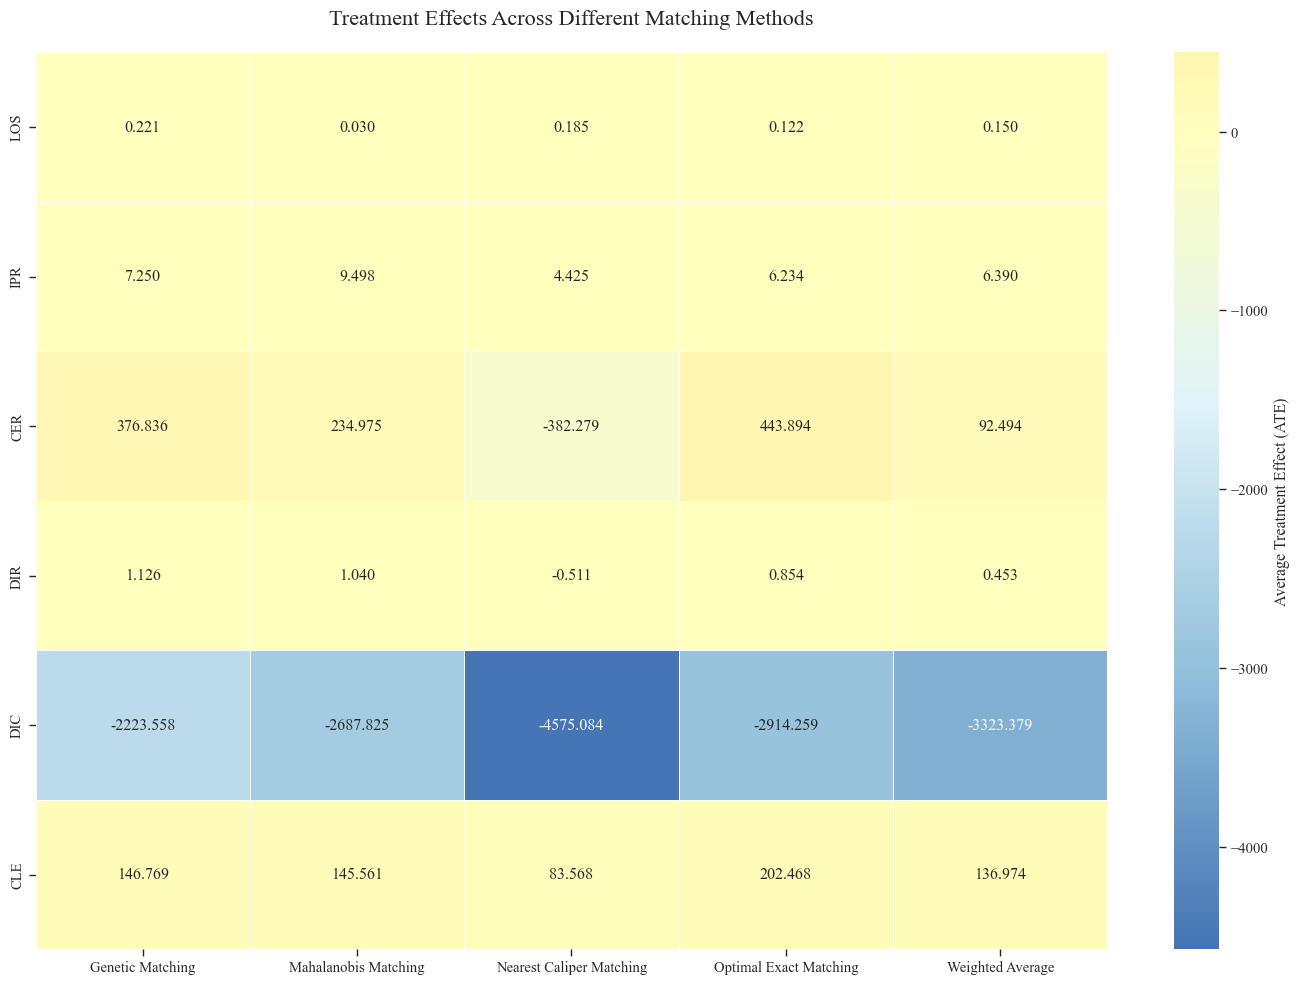

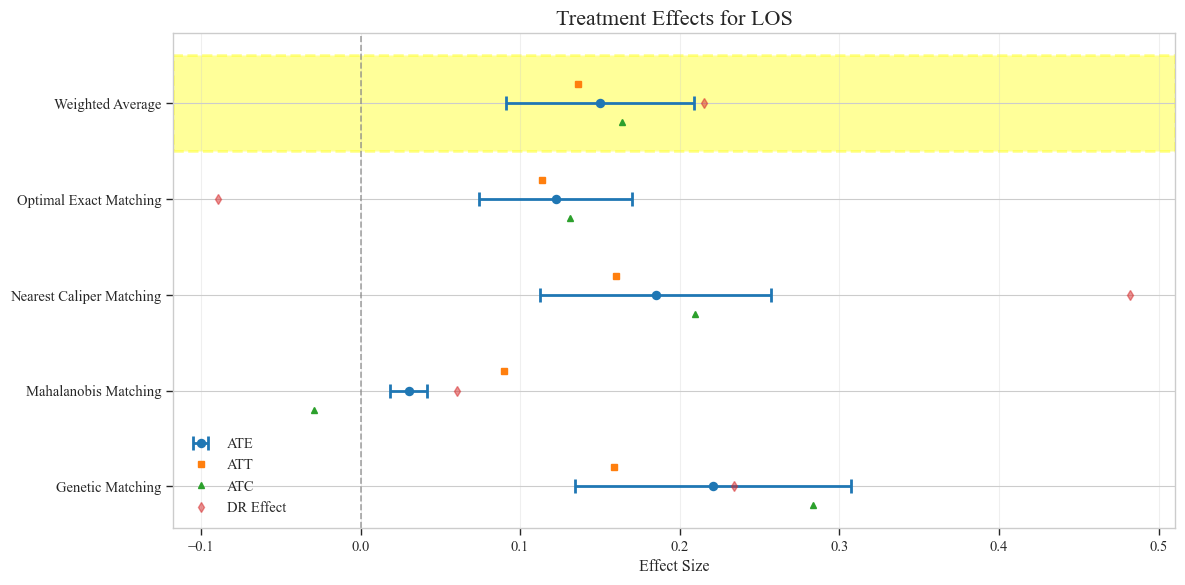

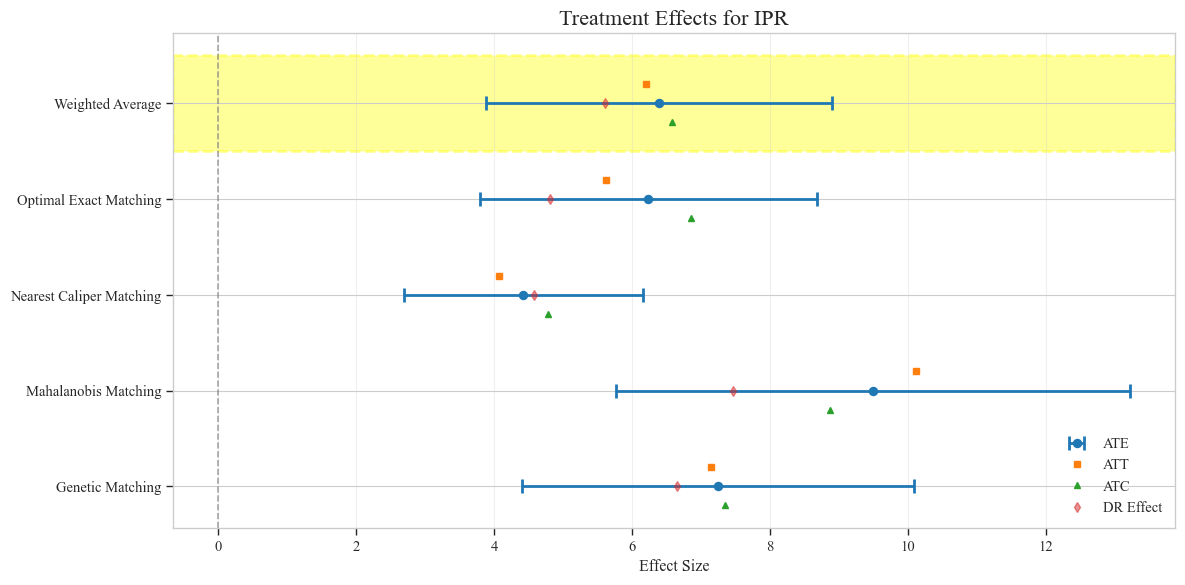

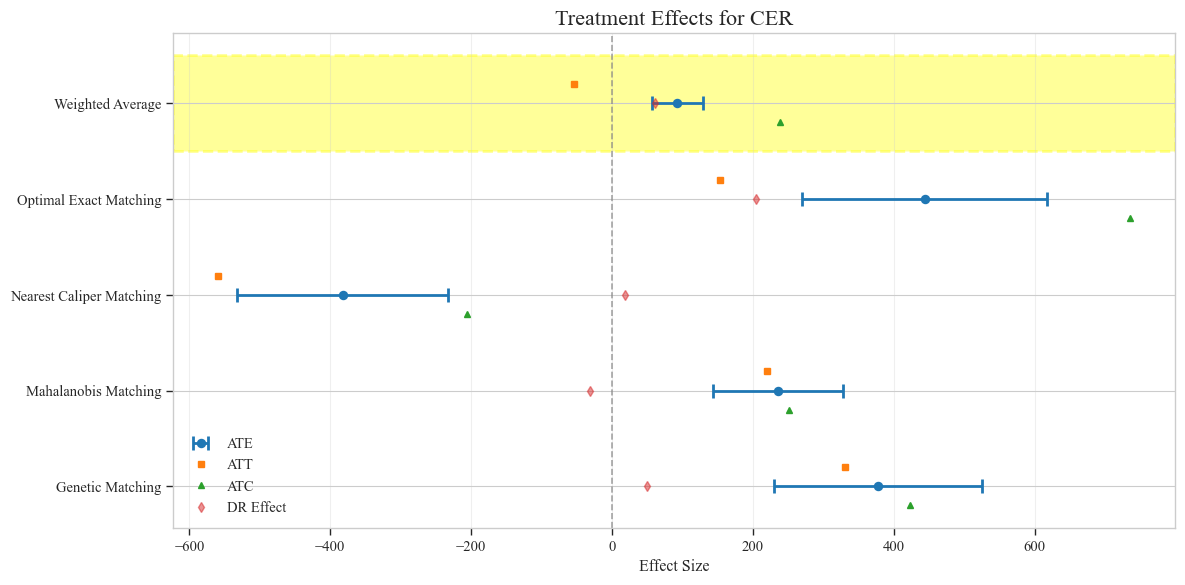

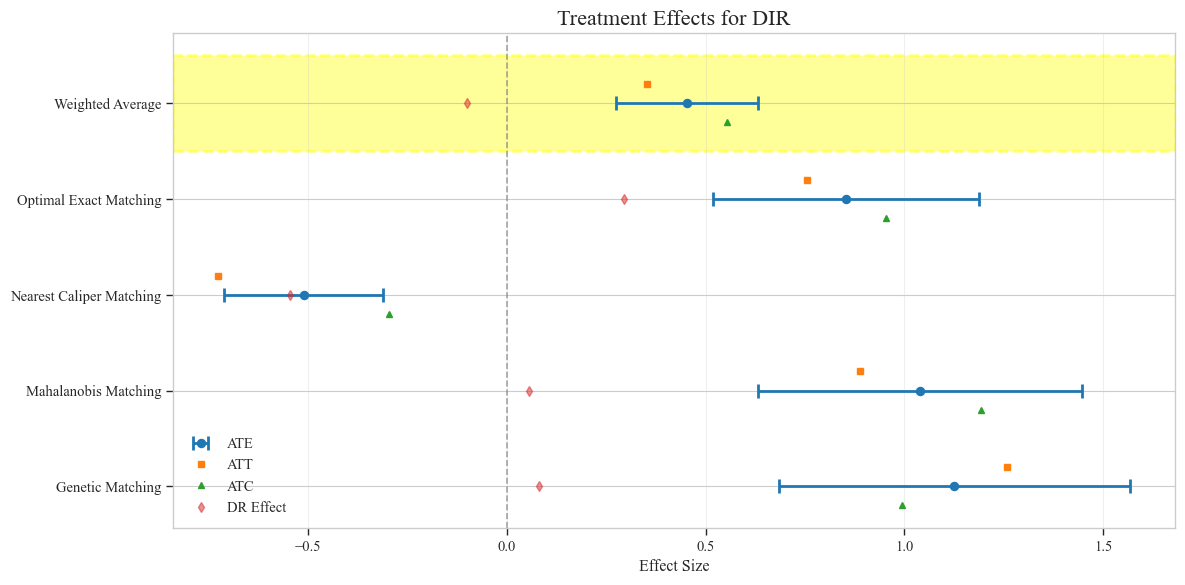

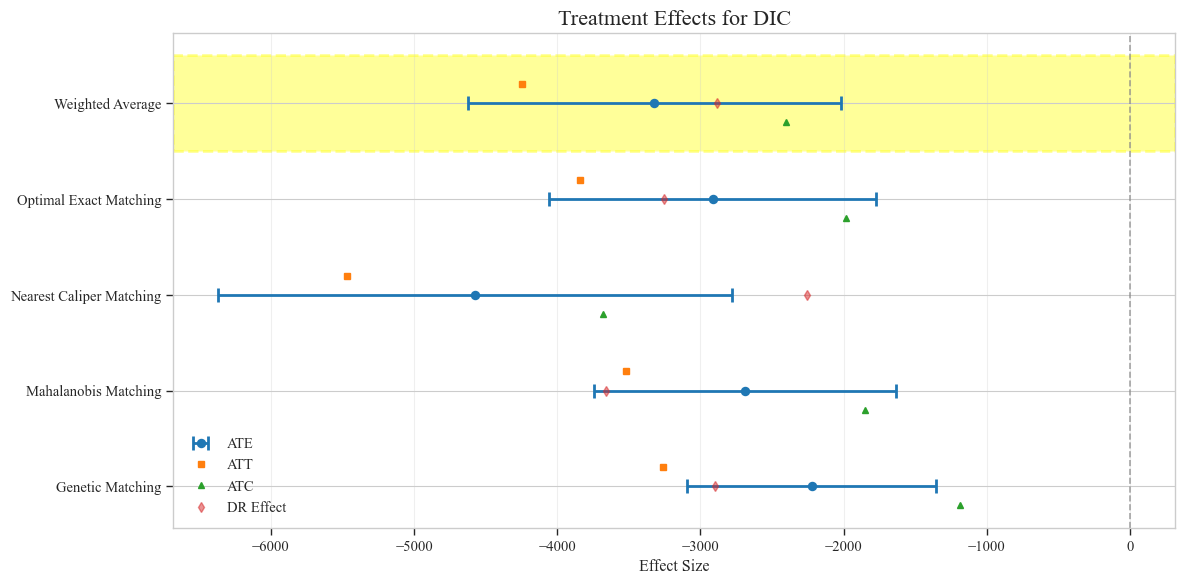

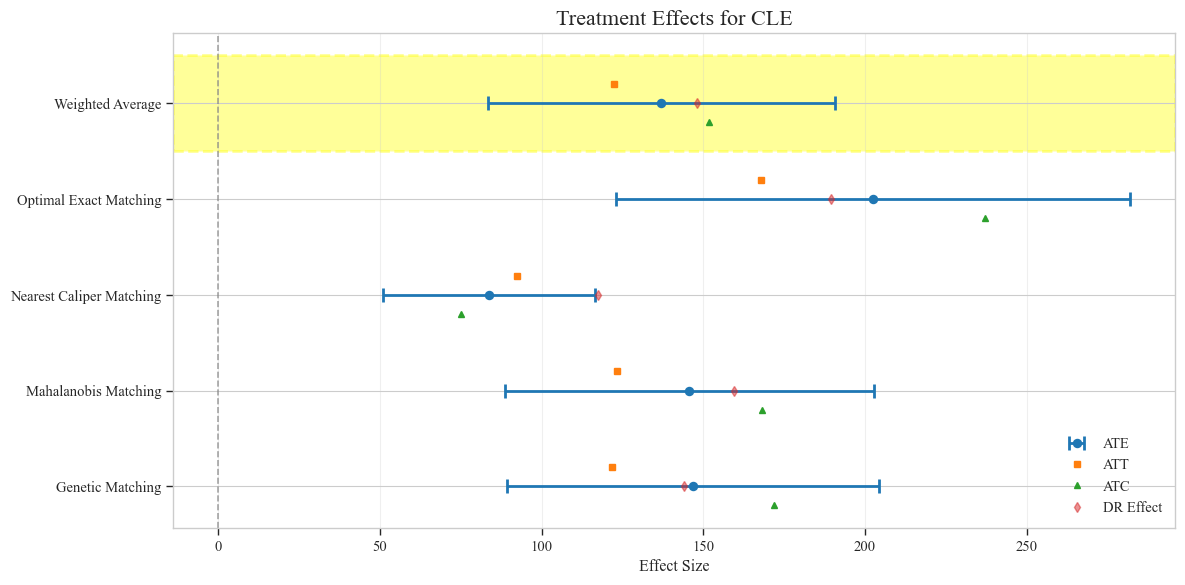

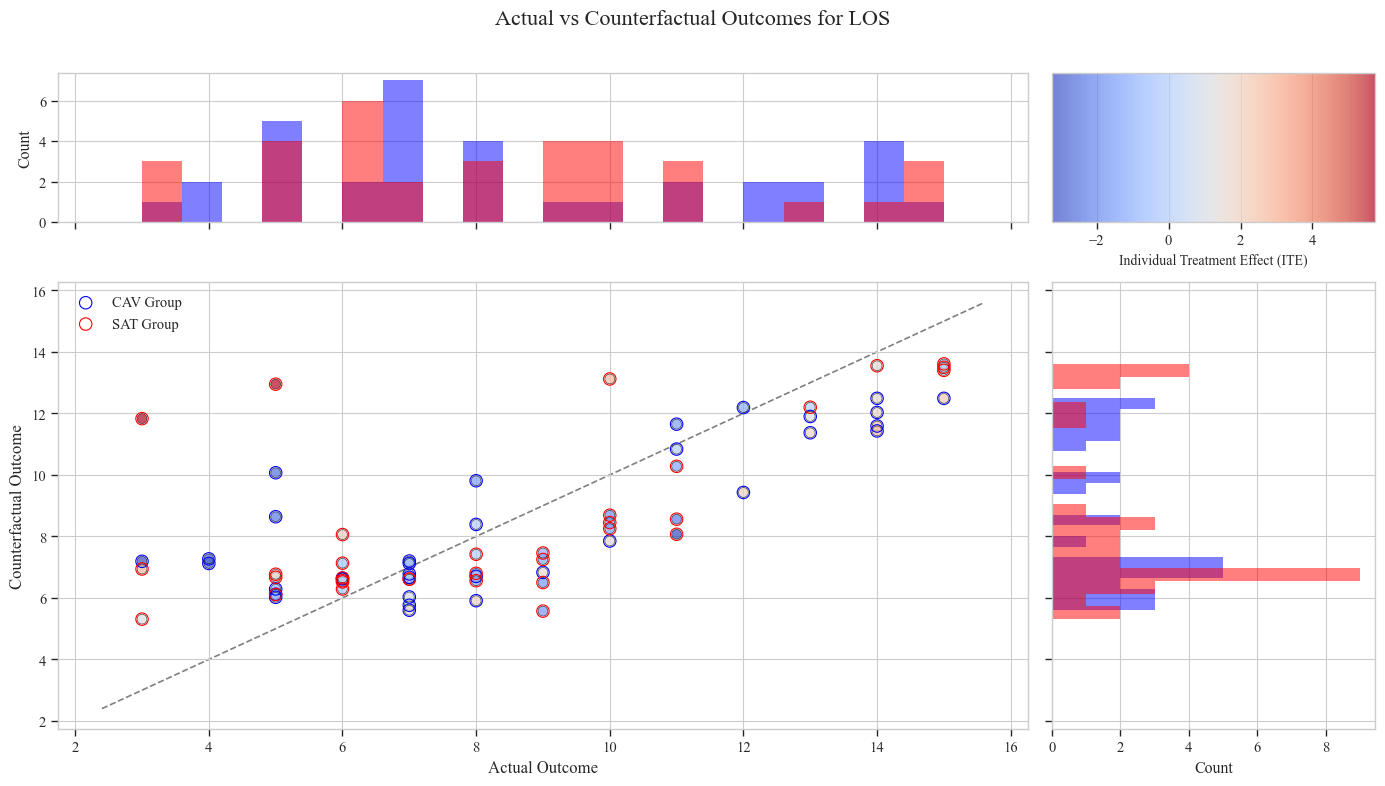

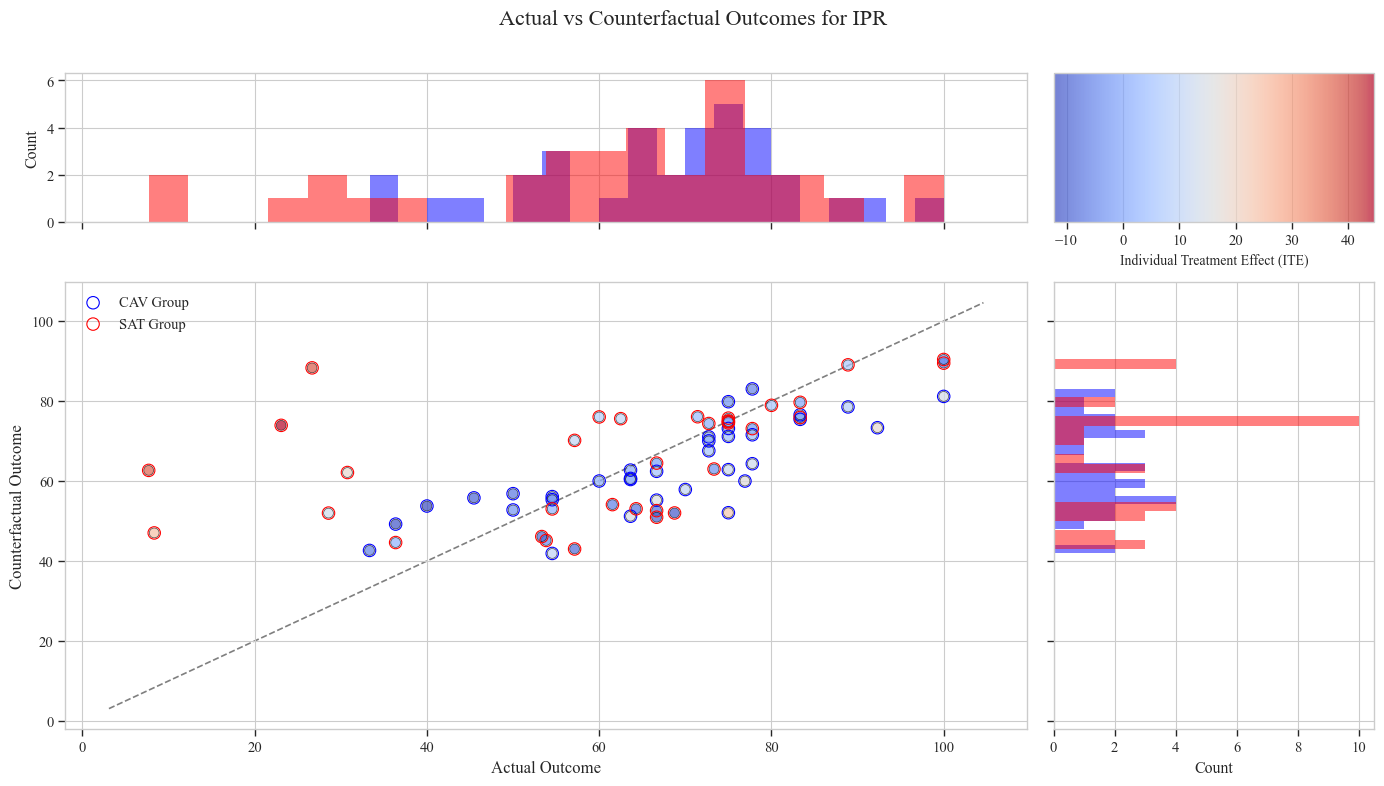

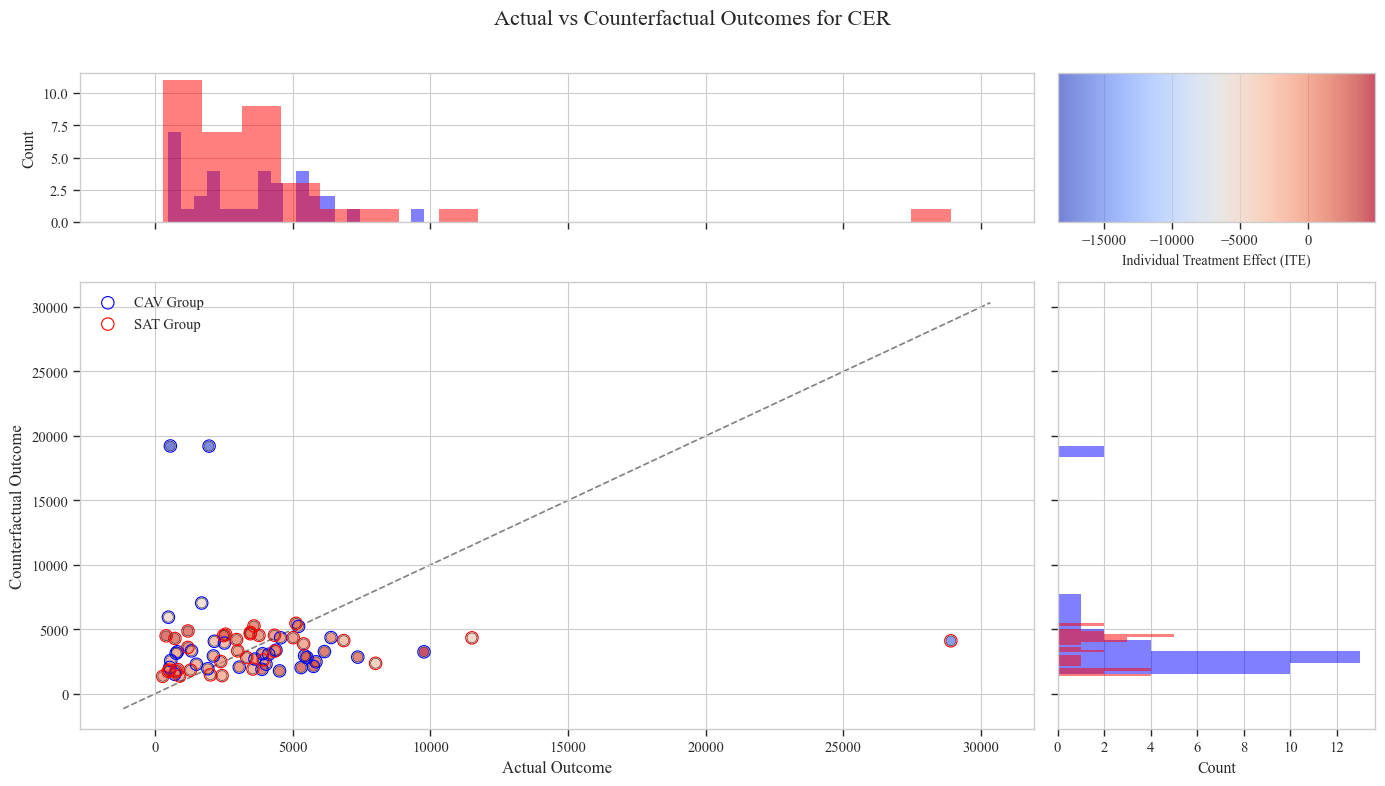

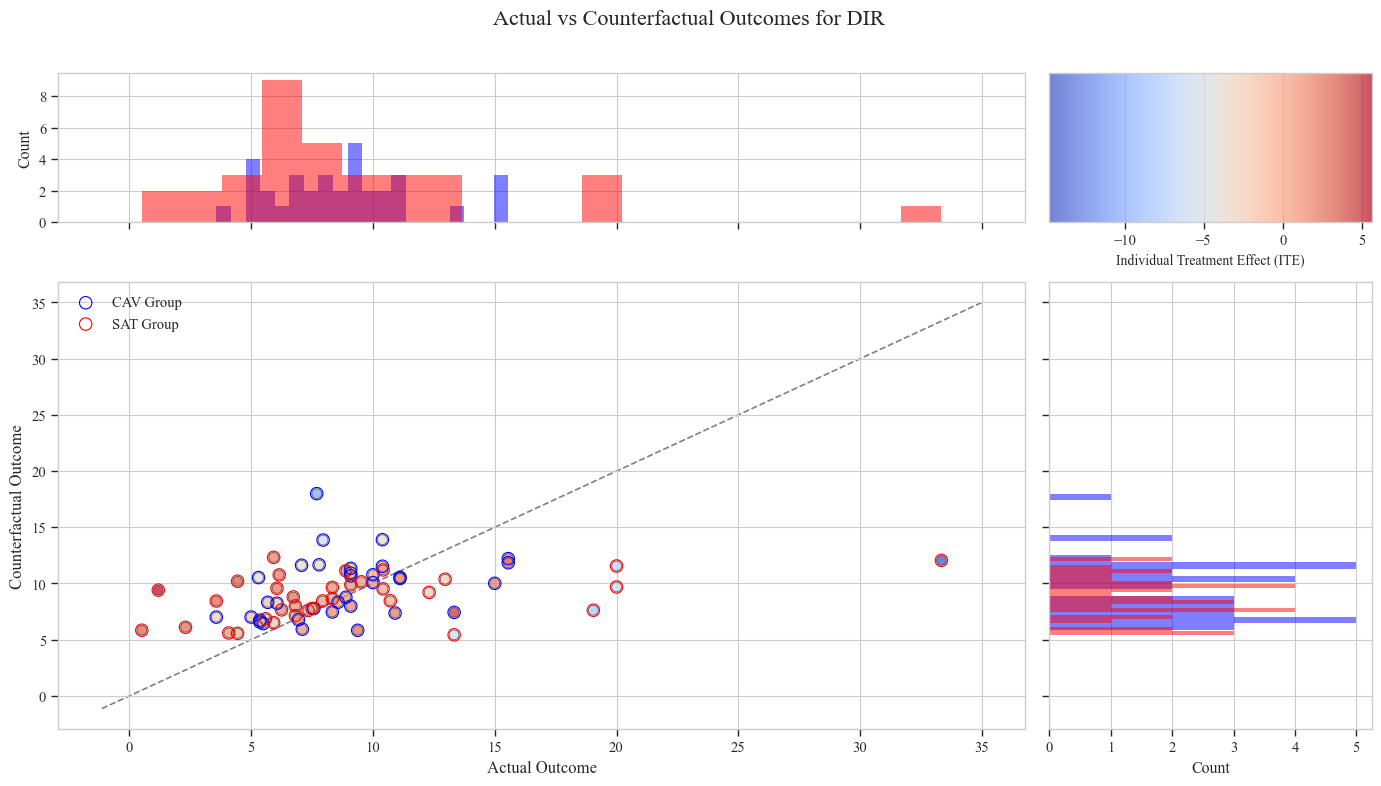

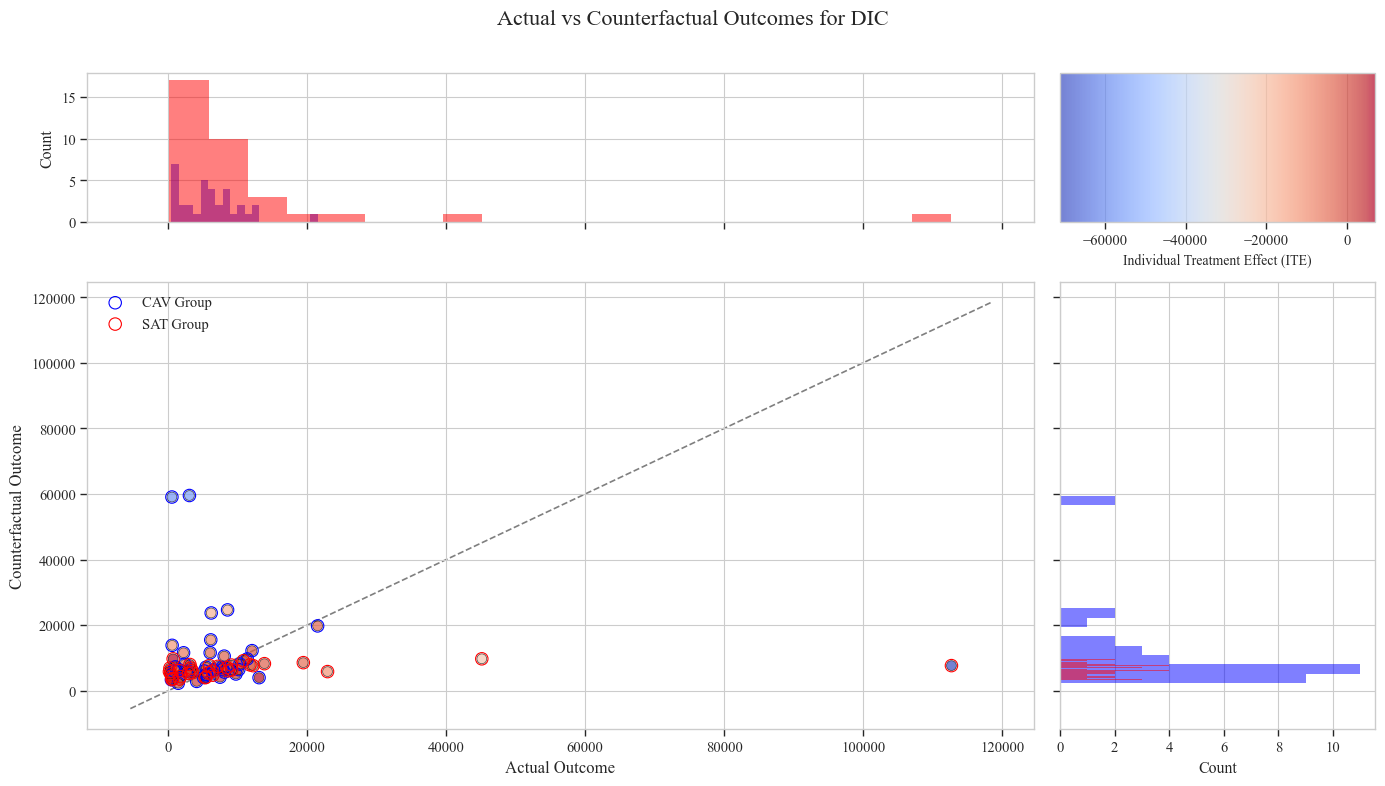

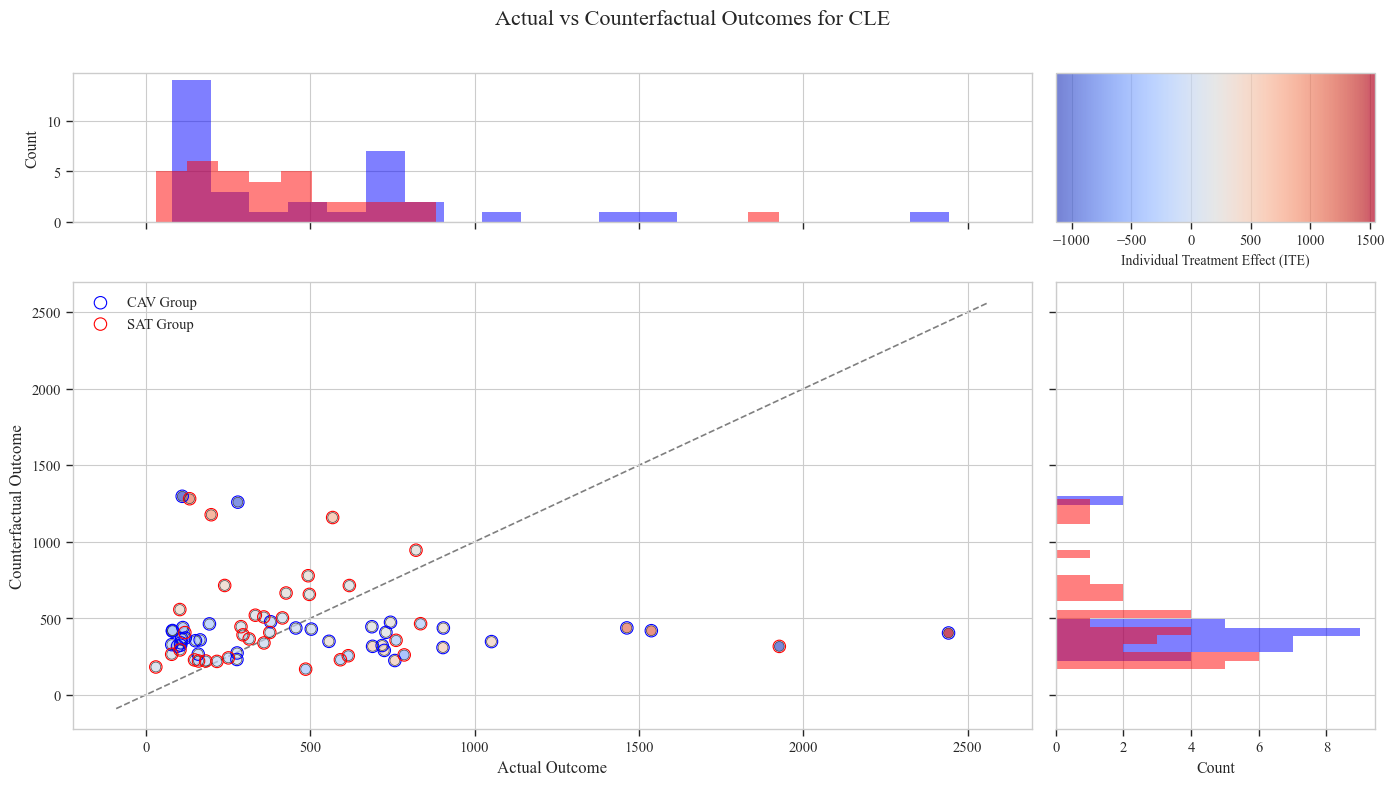

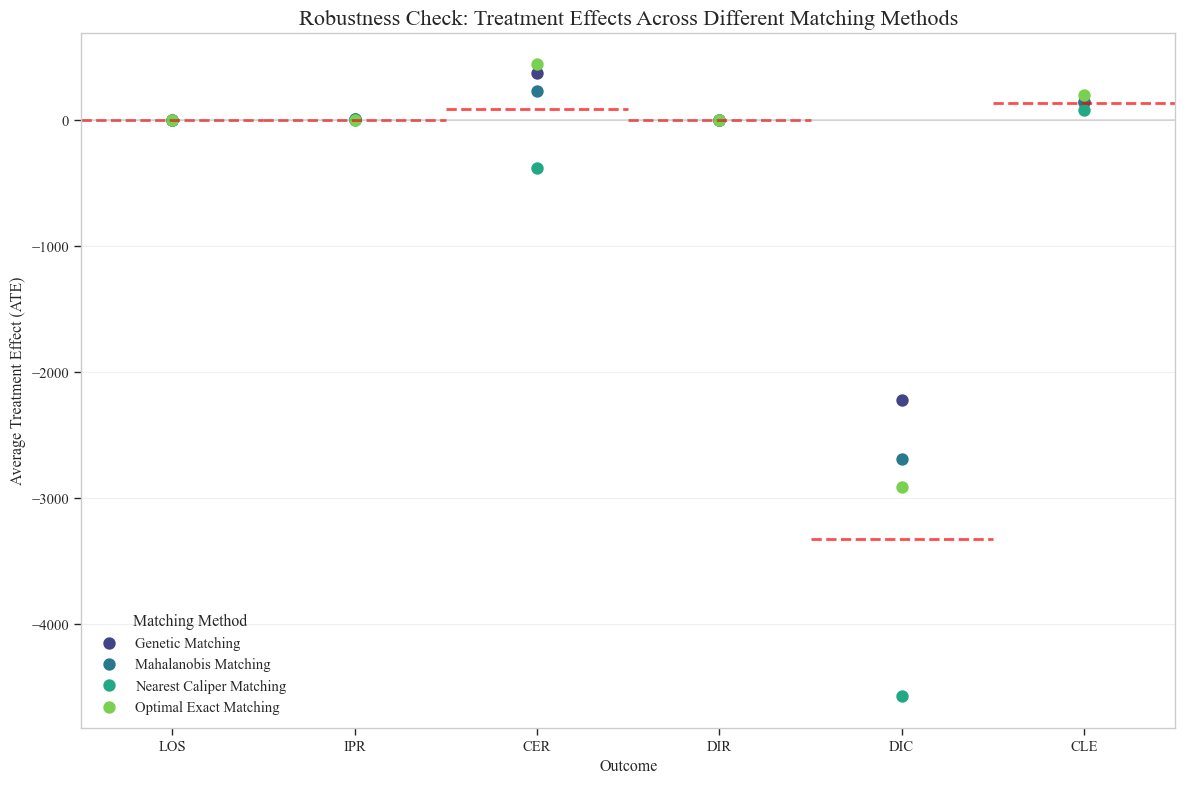

<Figure size 1000x600 with 0 Axes>

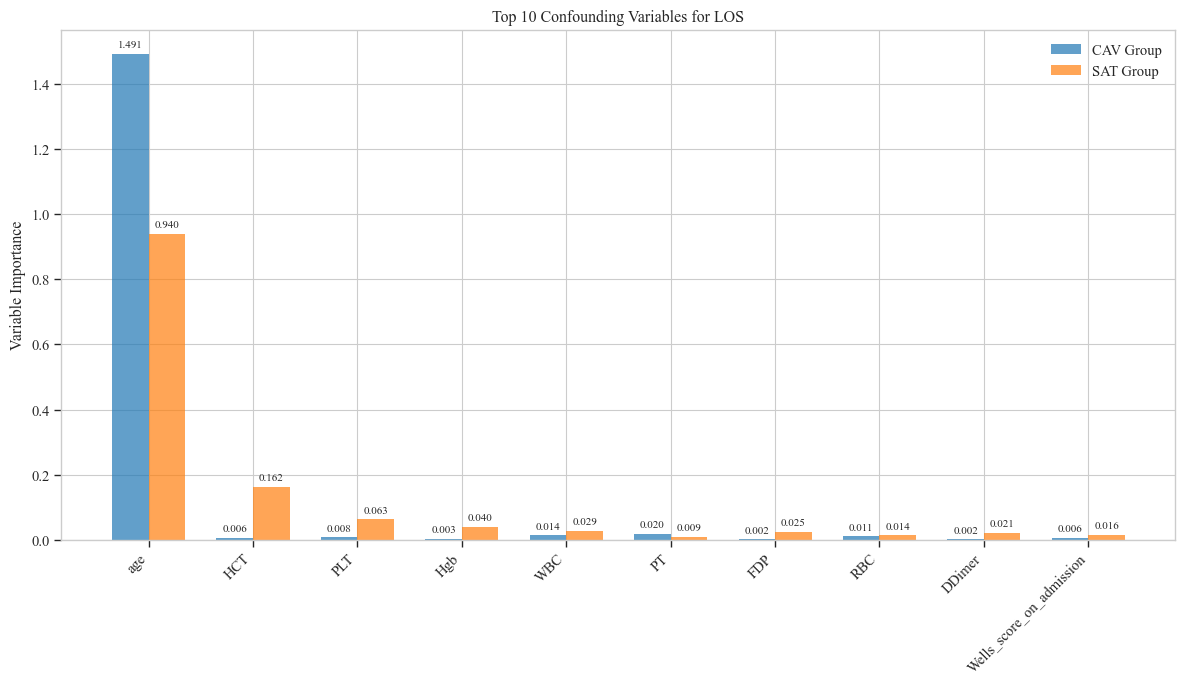

<Figure size 1000x600 with 0 Axes>

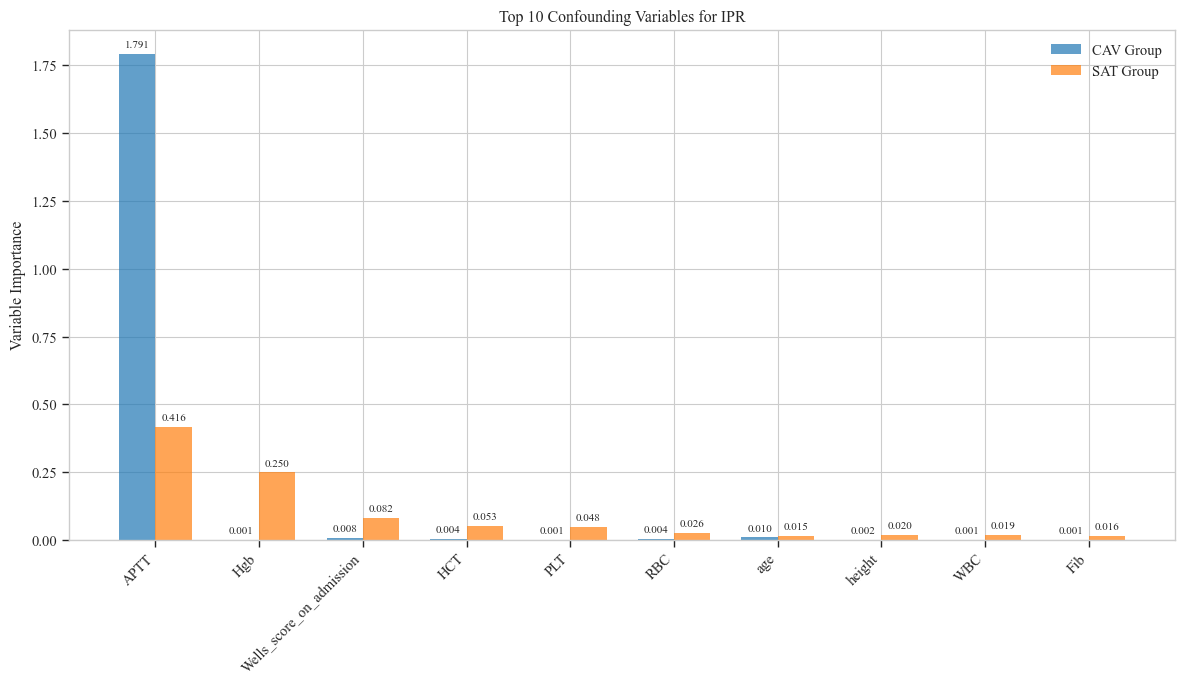

<Figure size 1000x600 with 0 Axes>

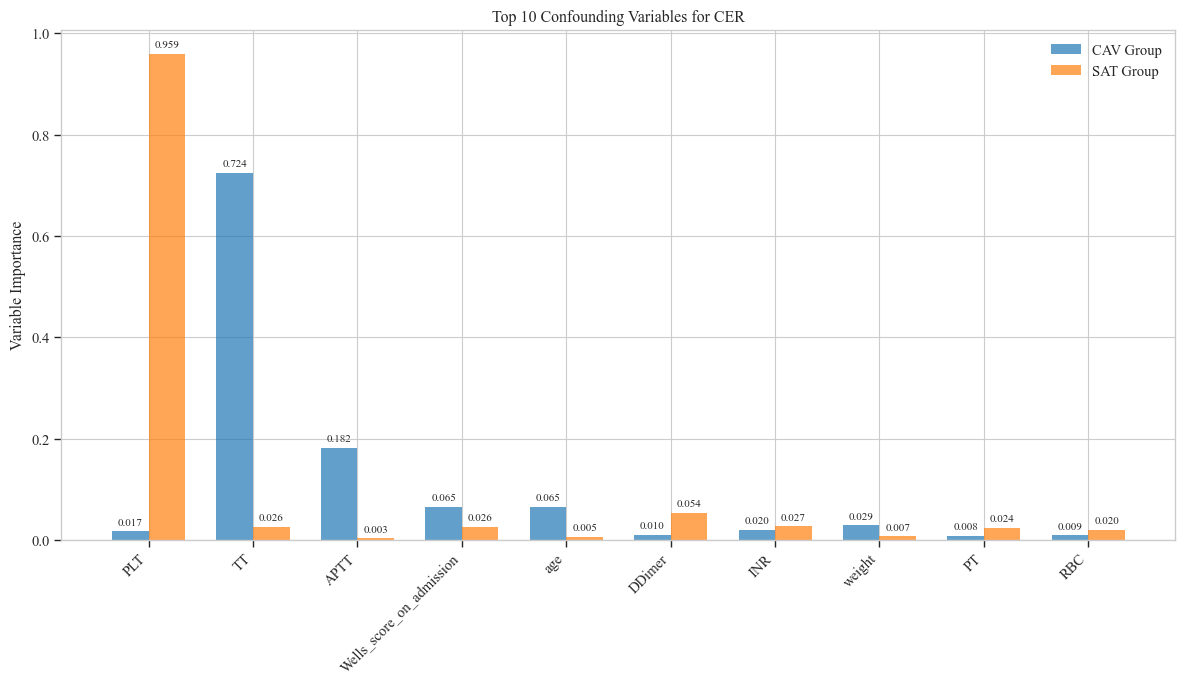

<Figure size 1000x600 with 0 Axes>

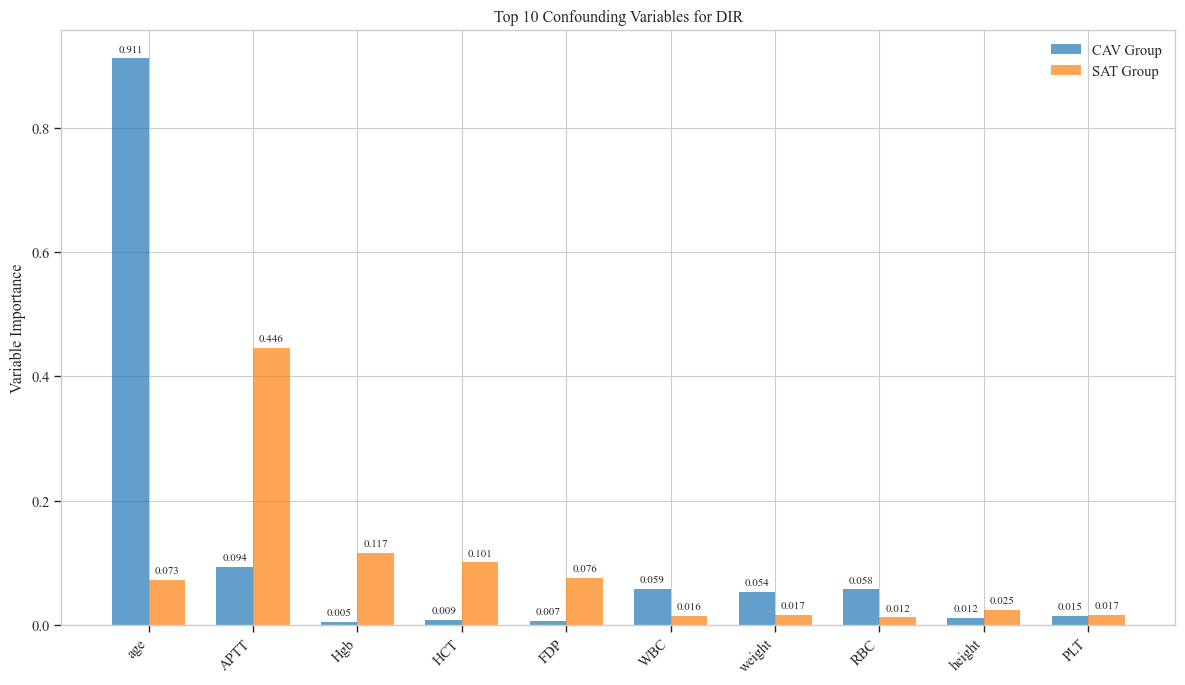

<Figure size 1000x600 with 0 Axes>

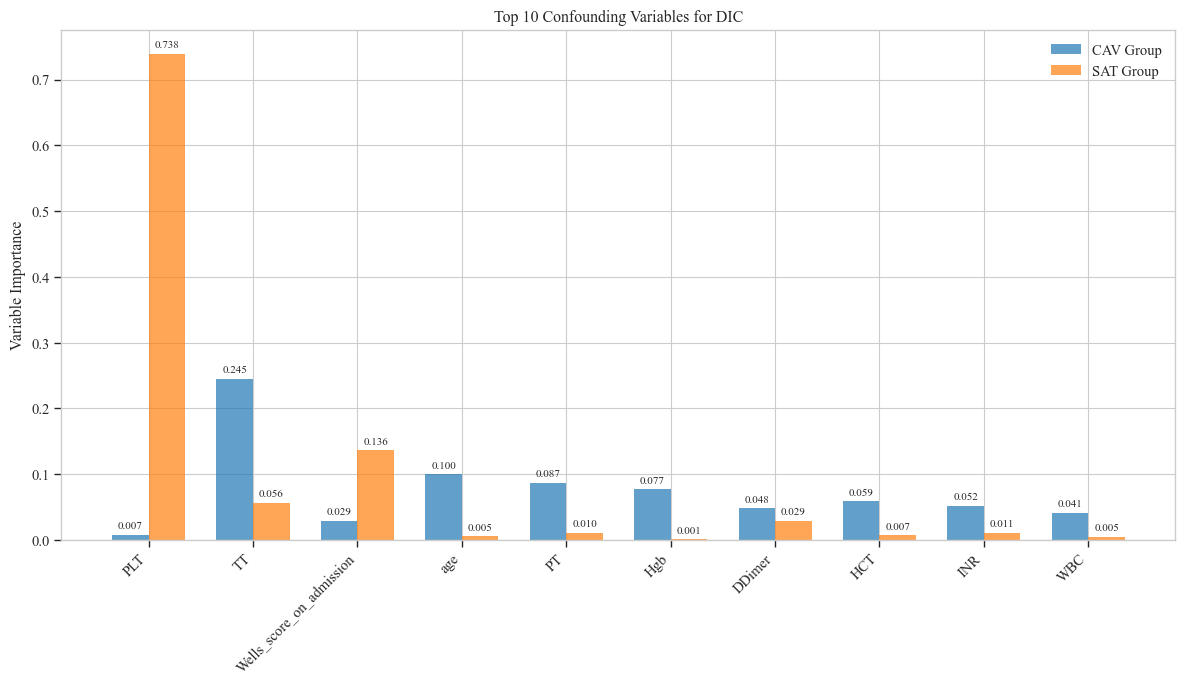

<Figure size 1000x600 with 0 Axes>

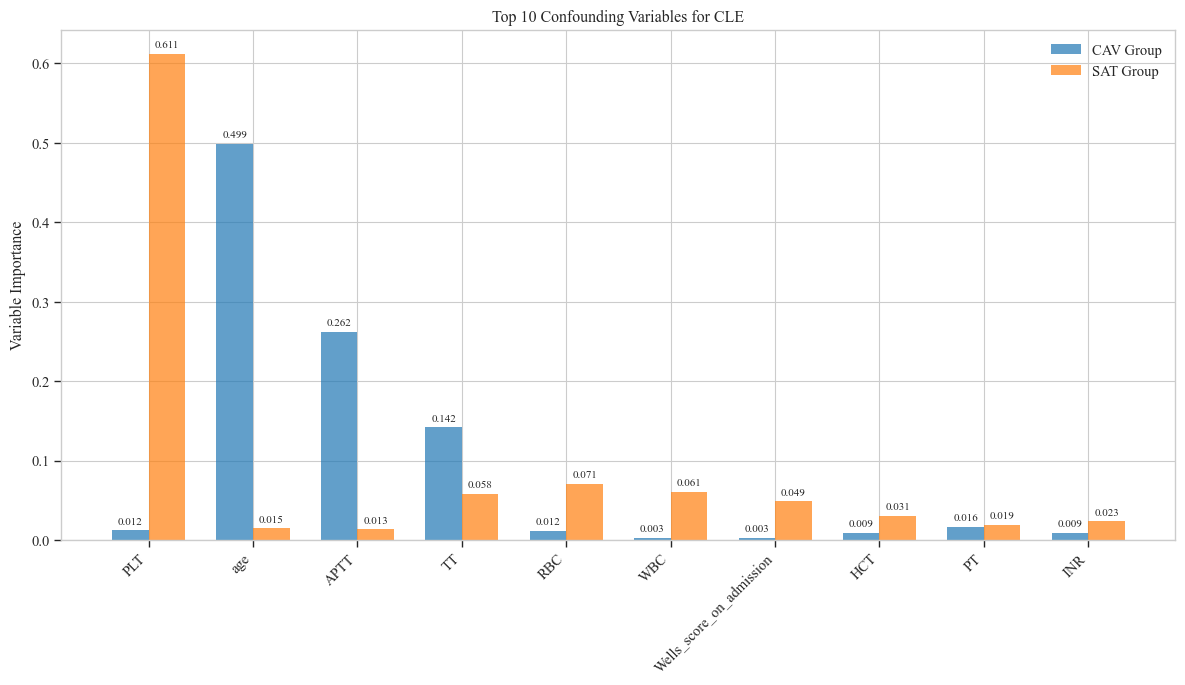

<Figure size 1200x800 with 0 Axes>

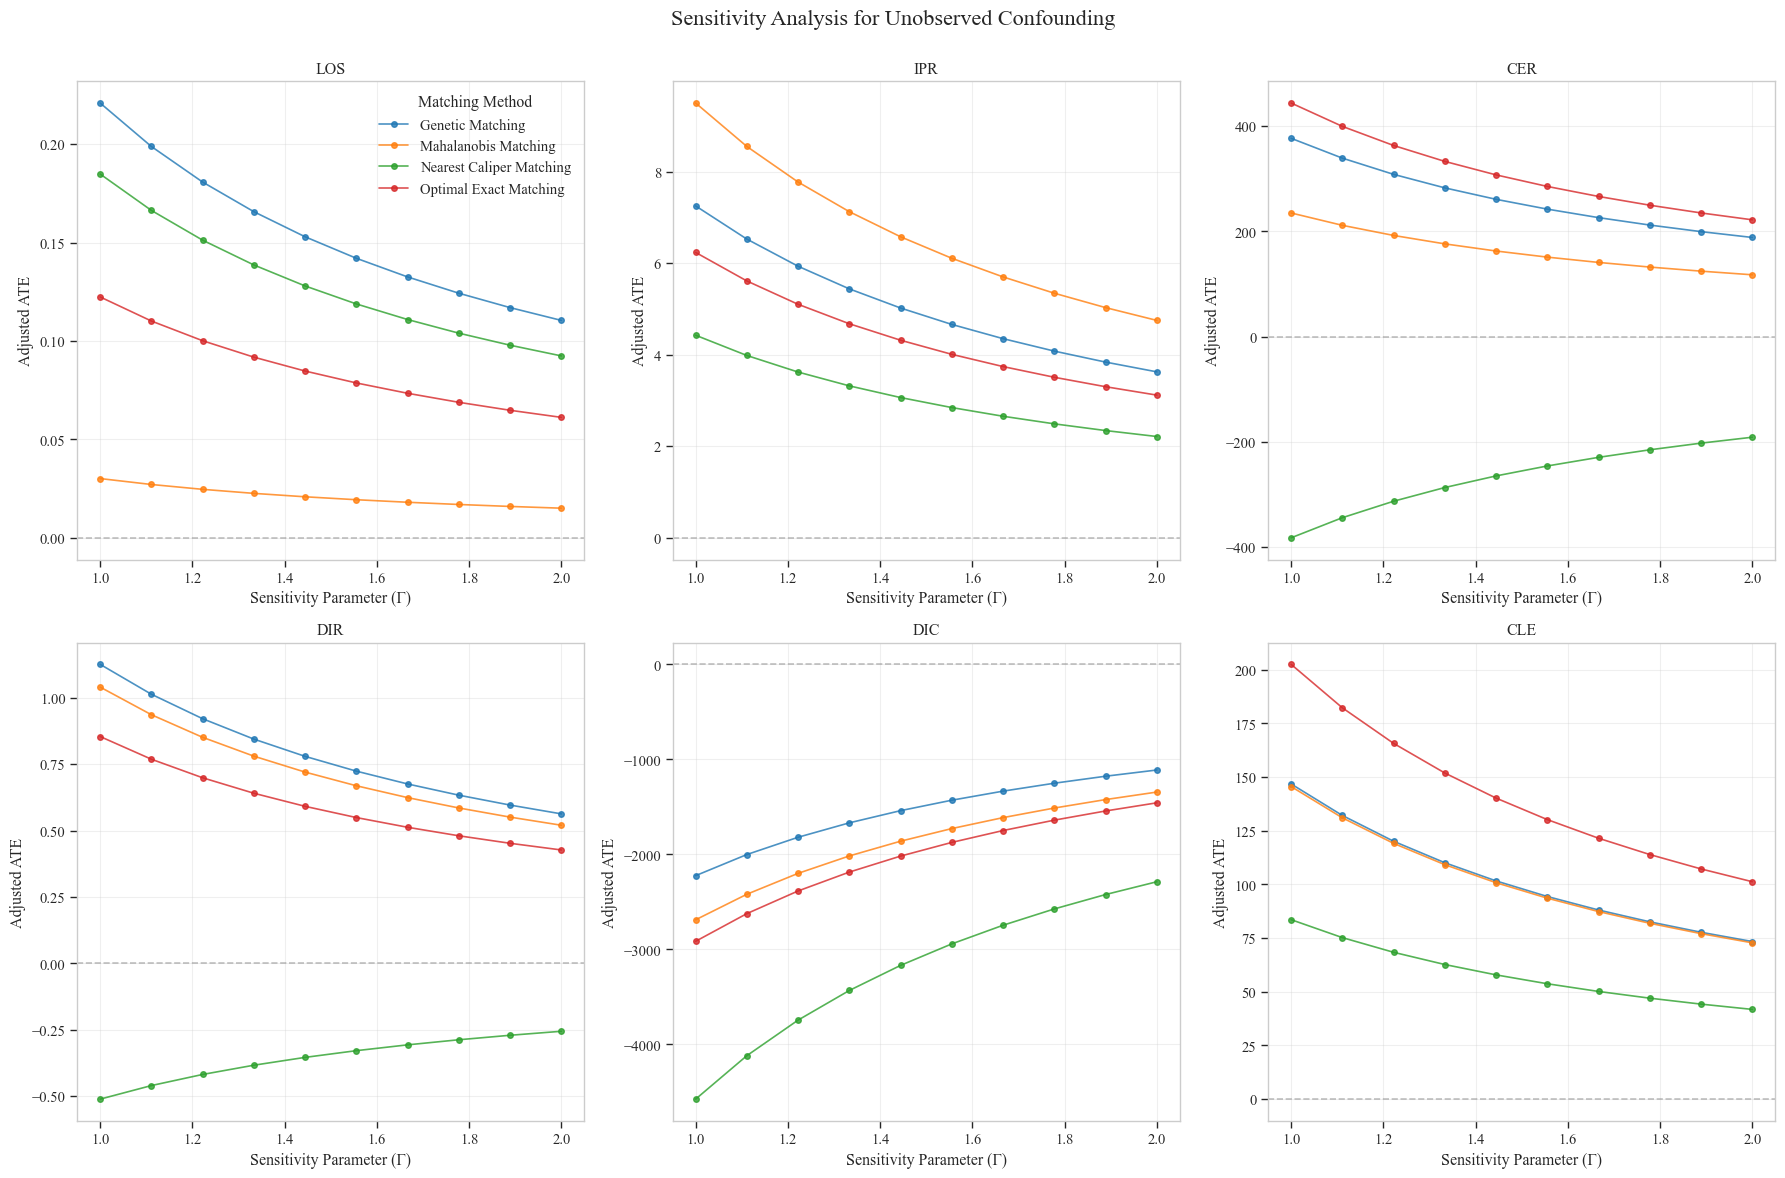

   Outcome                  Variable  Original_ATE  Adjusted_ATE  \
0      LOS                       age      0.184853      0.072505   
1      LOS                       HCT      0.184853      0.177075   
2      LOS                       PLT      0.184853      0.181548   
3      LOS                       Hgb      0.184853      0.182840   
4      LOS                       WBC      0.184853      0.182863   
5      IPR                      APTT      4.425388      1.983422   
6      IPR                       Hgb      4.425388      4.147721   
7      IPR  Wells_score_on_admission      4.425388      4.325655   
8      IPR                       HCT      4.425388      4.362243   
9      IPR                       PLT      4.425388      4.371819   
10     CER                       PLT   -382.278629   -288.992933   
11     CER                        TT   -382.278629   -310.560346   
12     CER                      APTT   -382.278629   -364.540571   
13     CER  Wells_score_on_admission   -382.2786

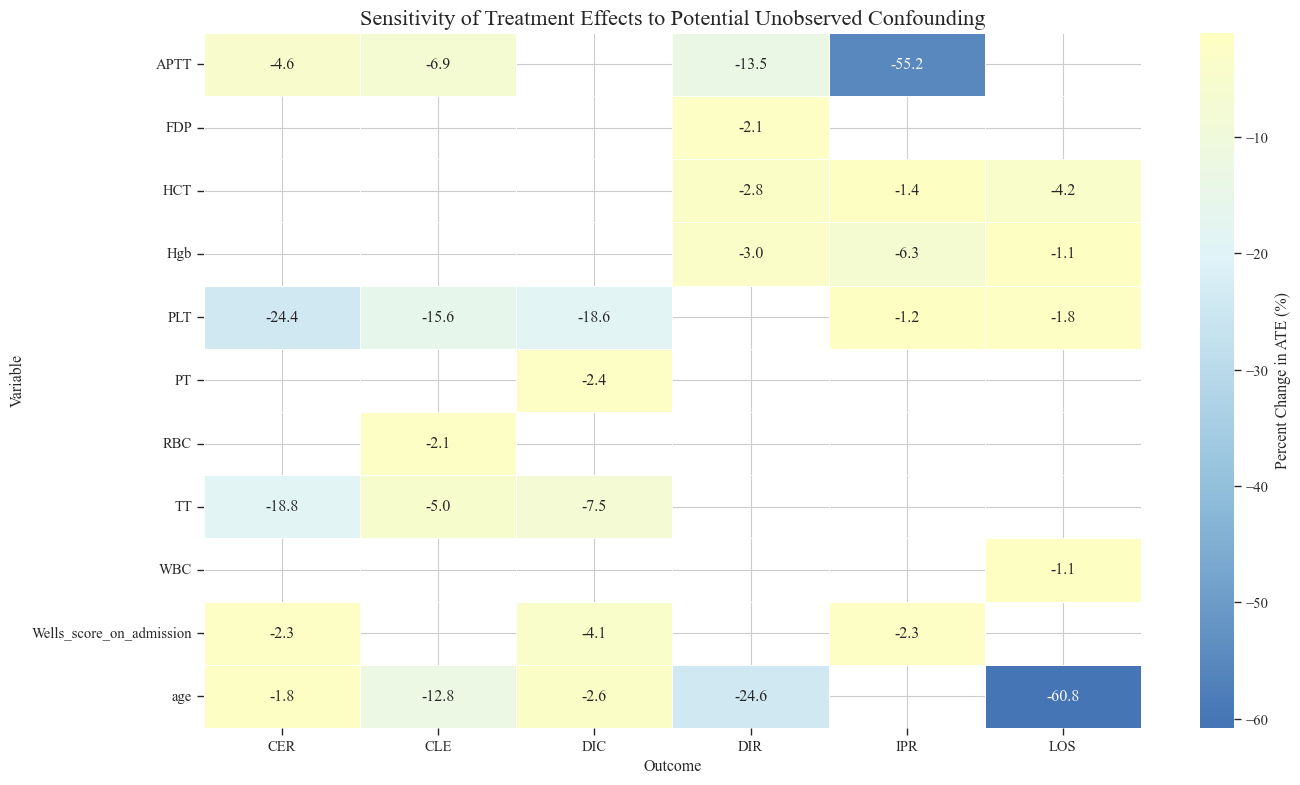

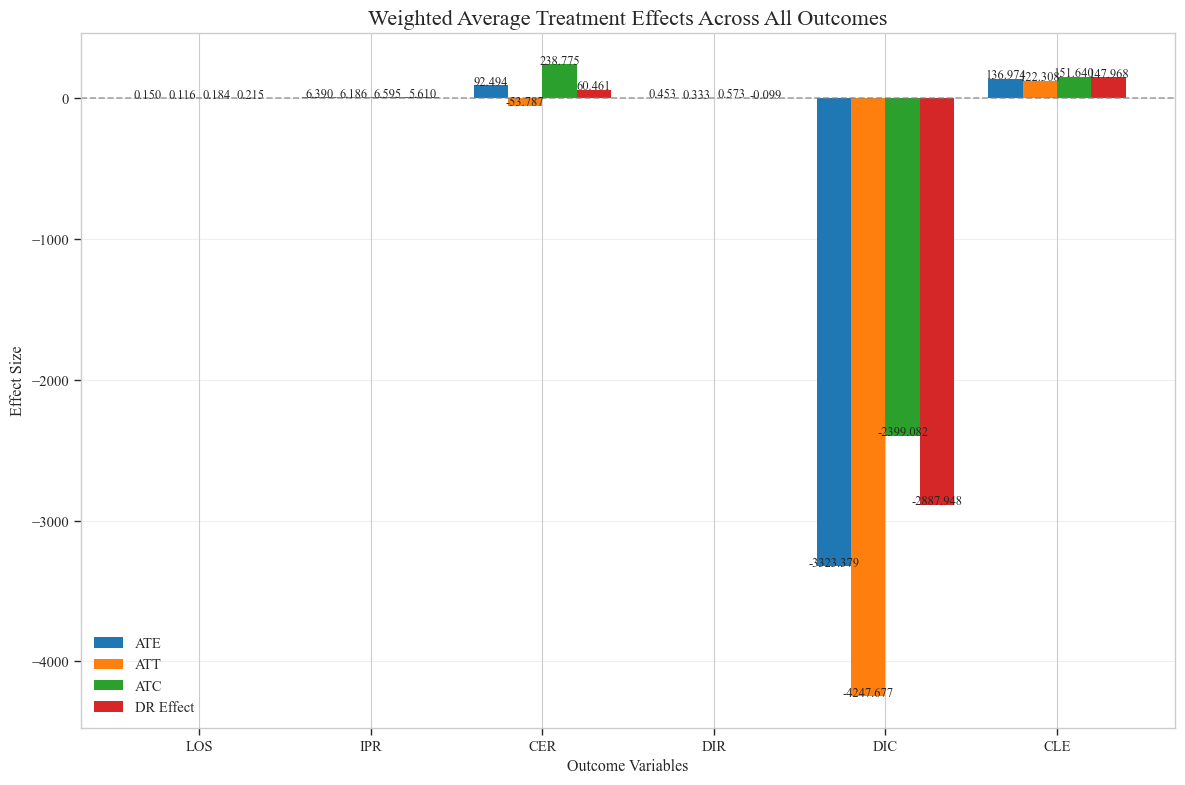

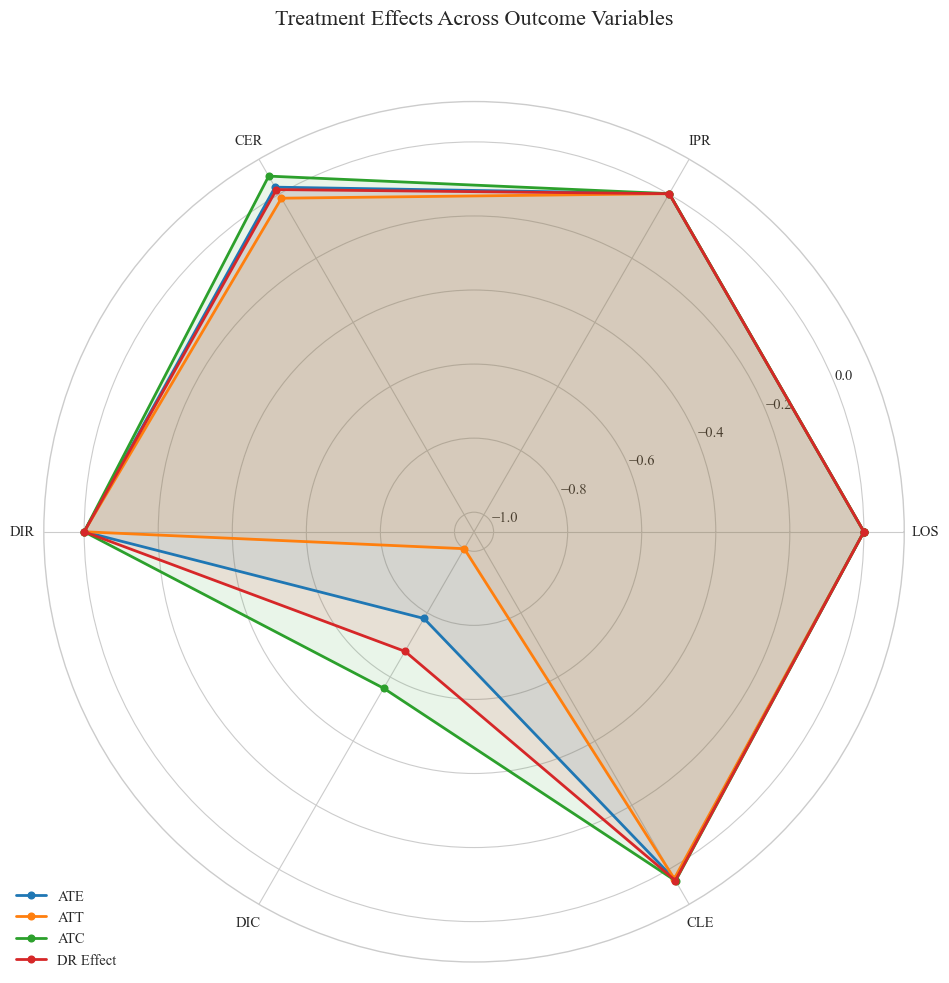

<Figure size 1500x1000 with 0 Axes>

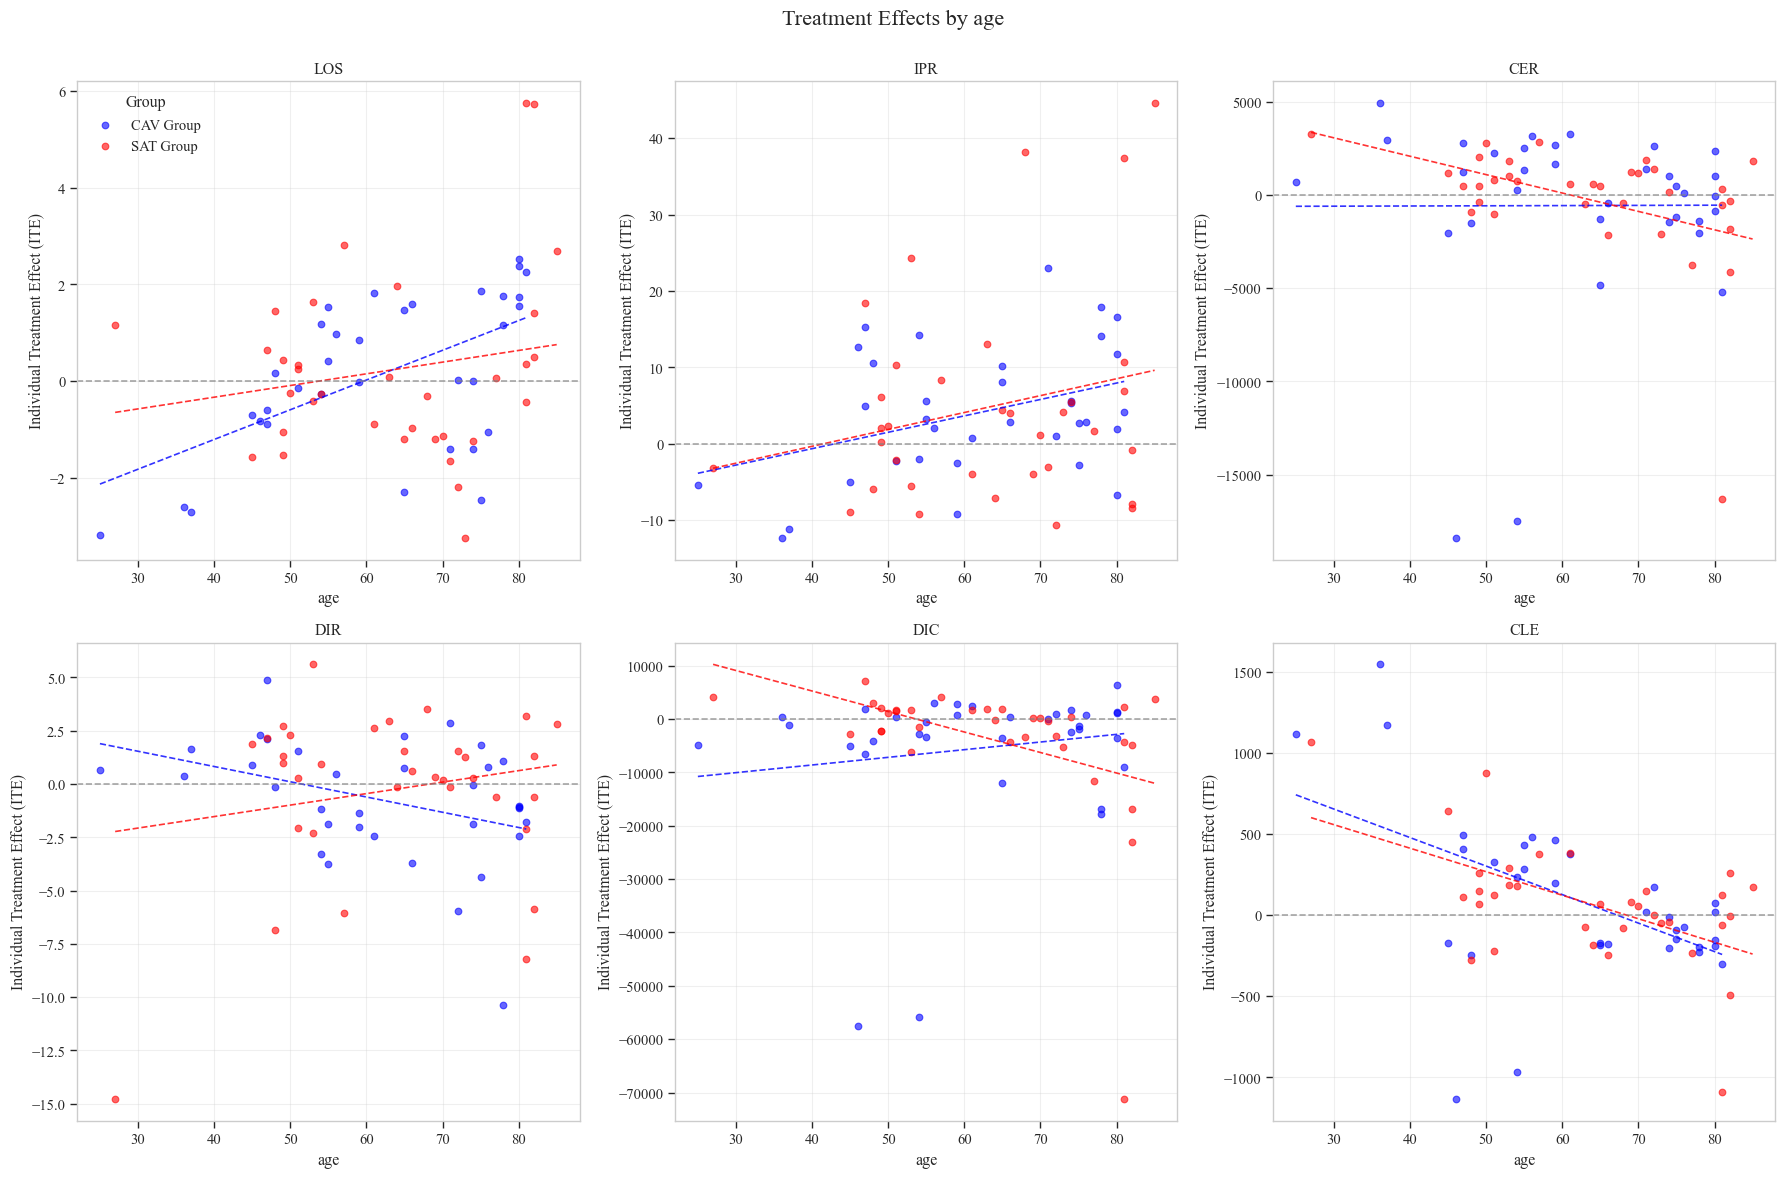

<Figure size 1500x1000 with 0 Axes>

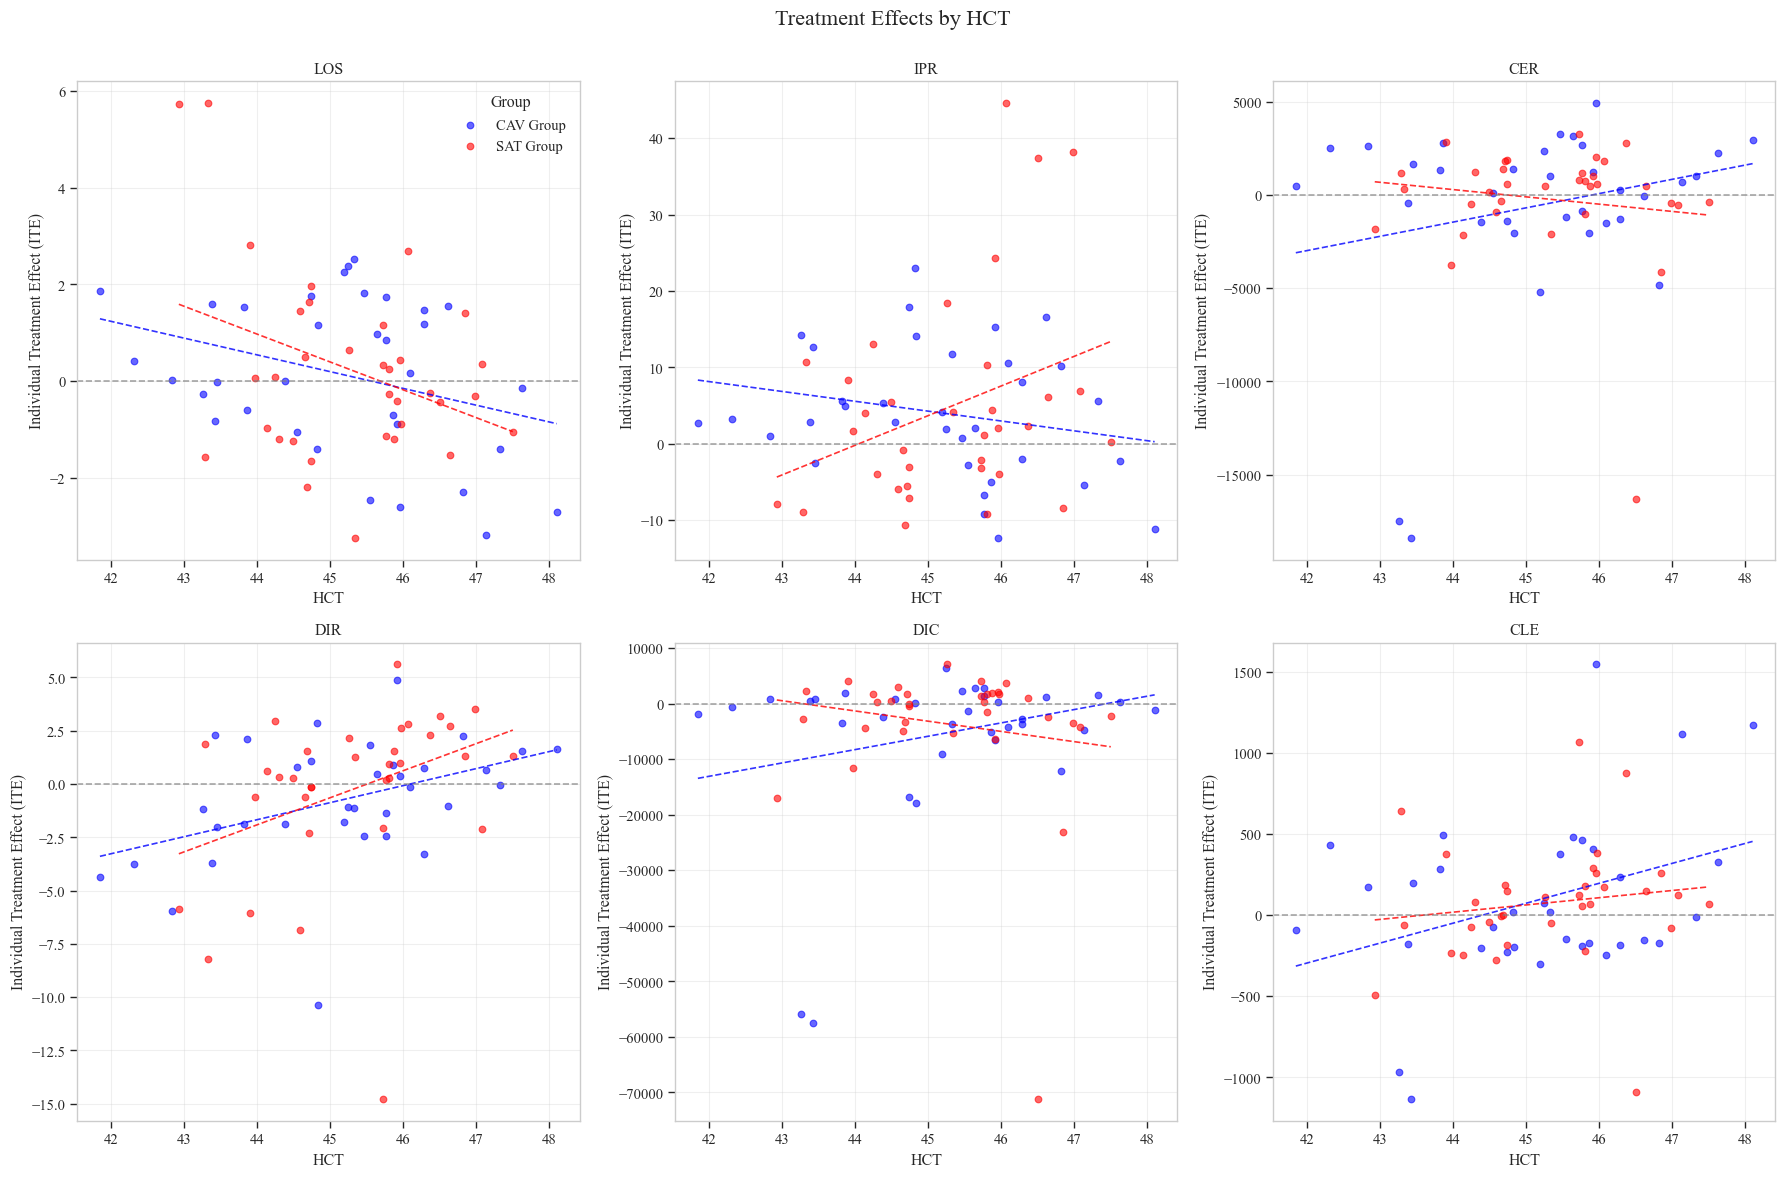

<Figure size 1500x1000 with 0 Axes>

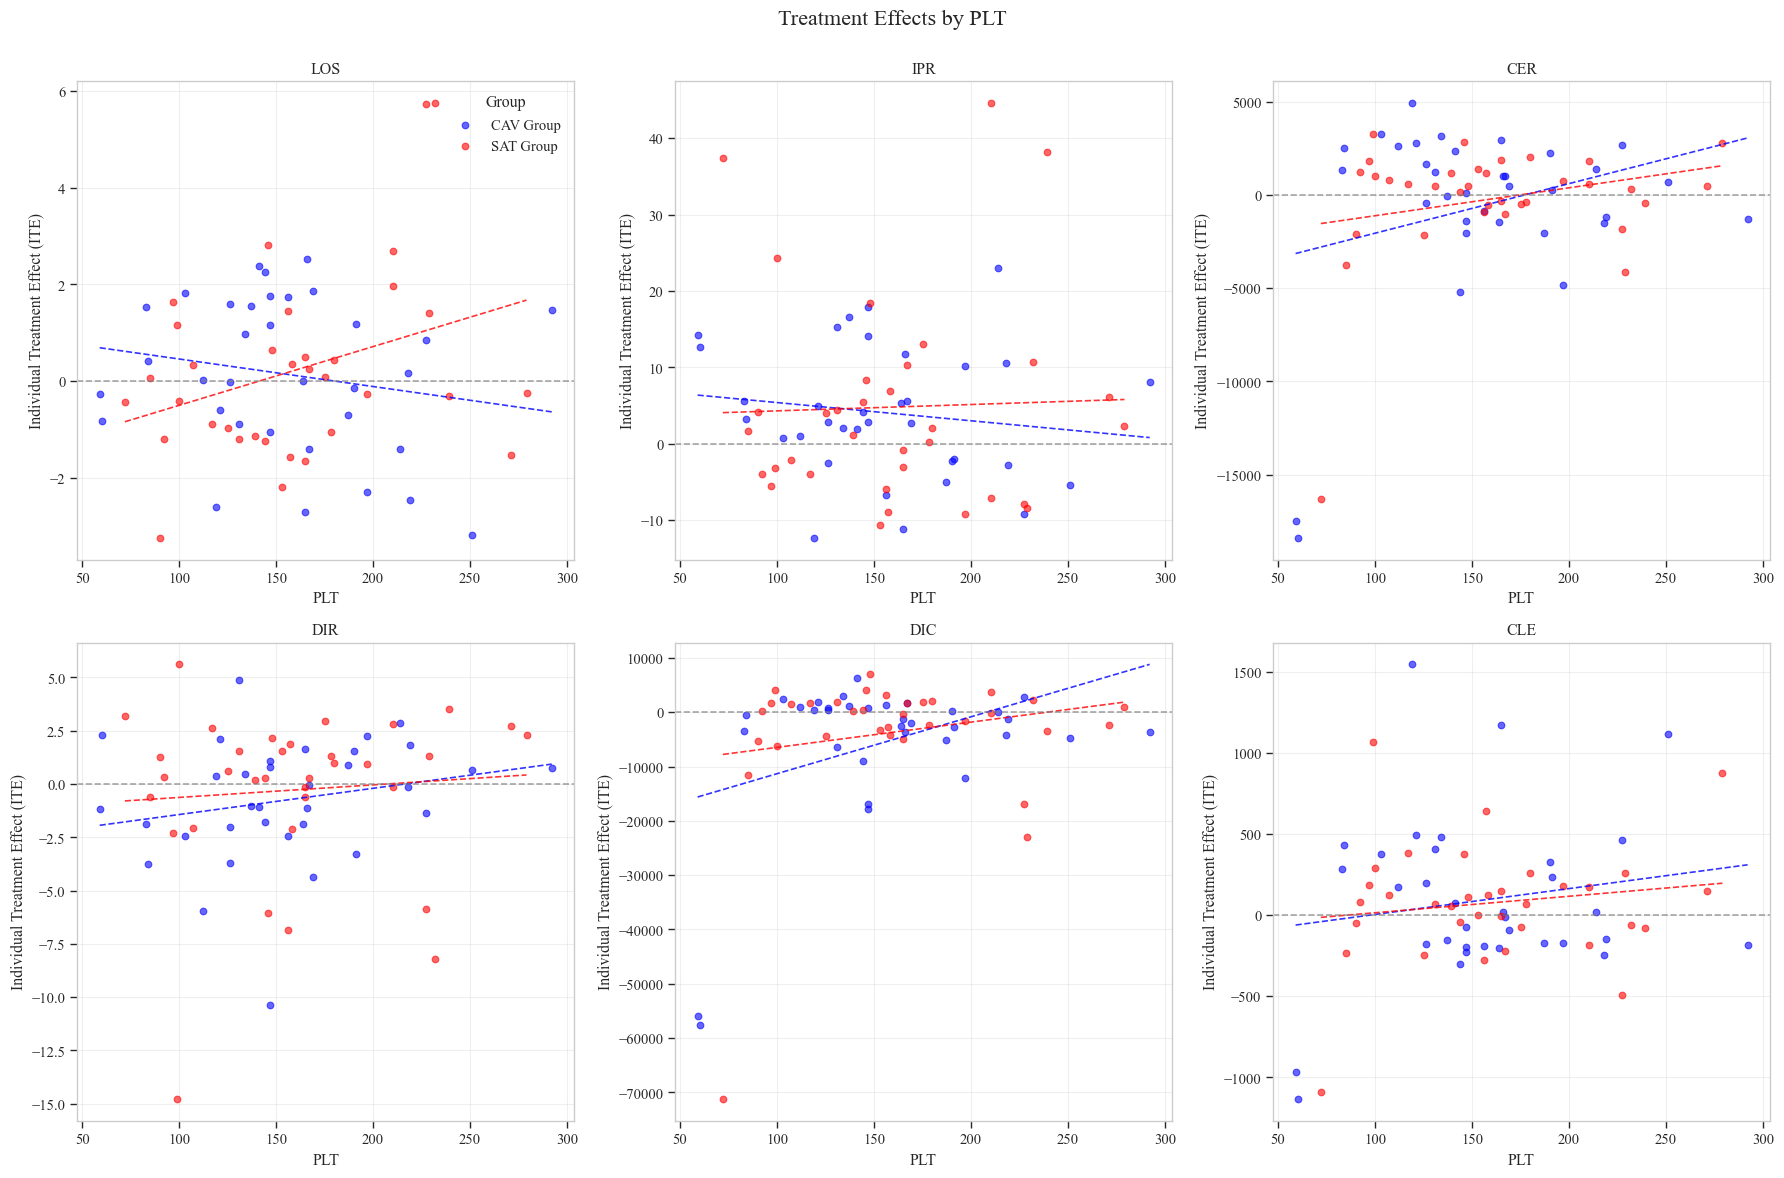

<Figure size 1500x1000 with 0 Axes>

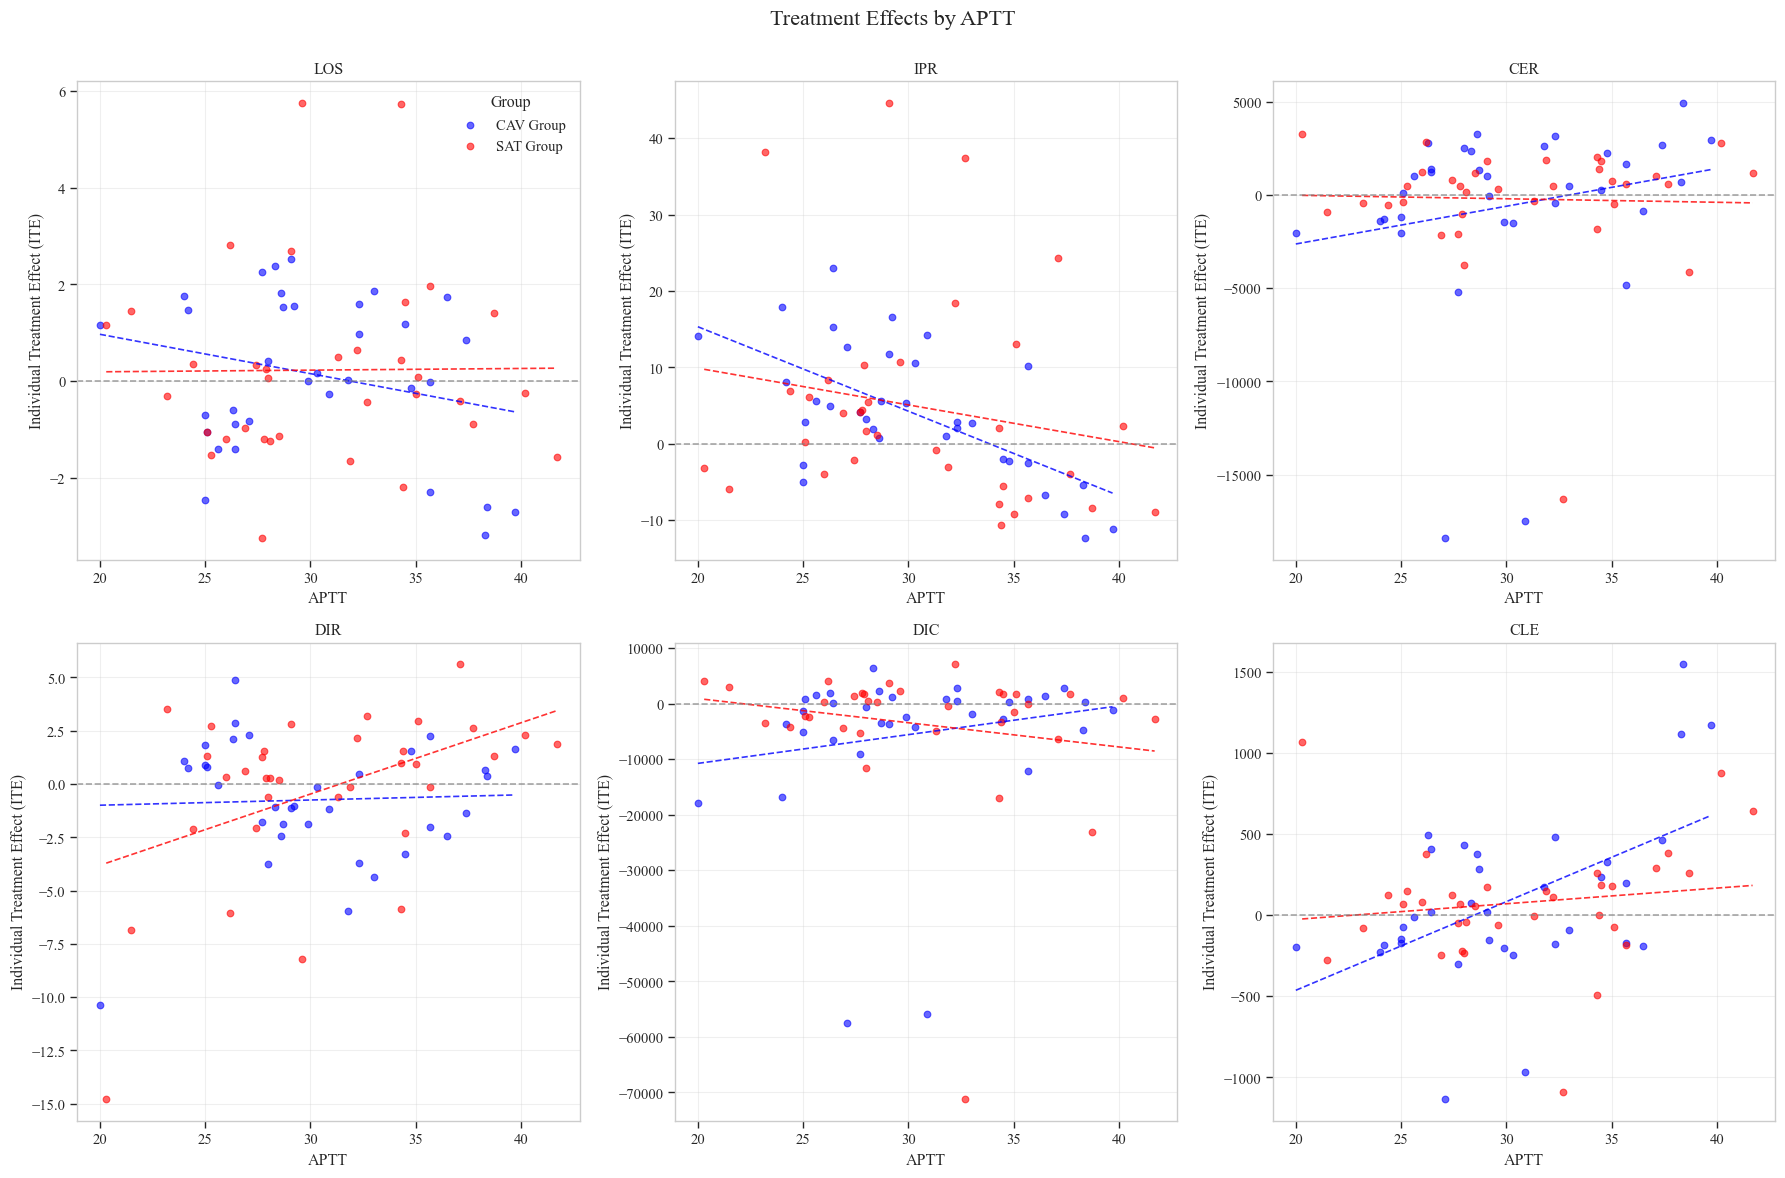

<Figure size 1500x1000 with 0 Axes>

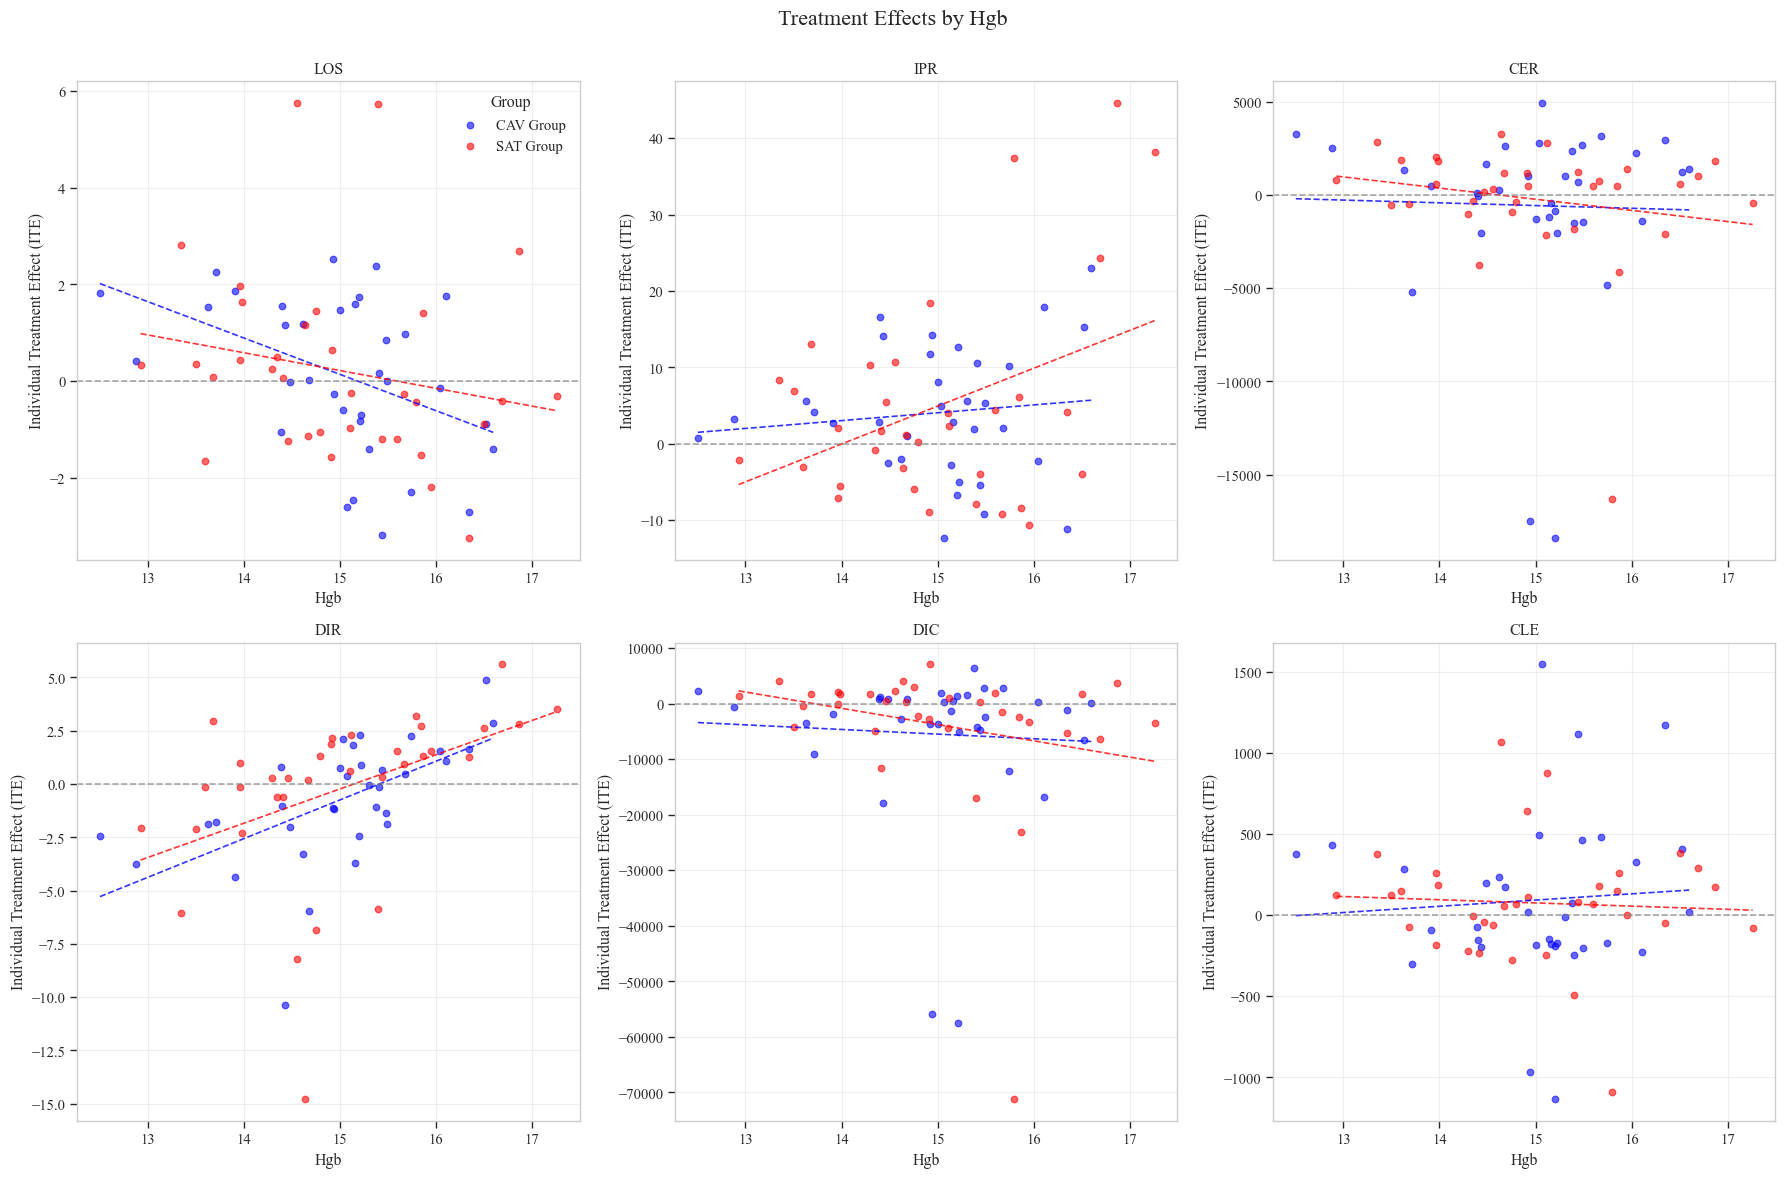

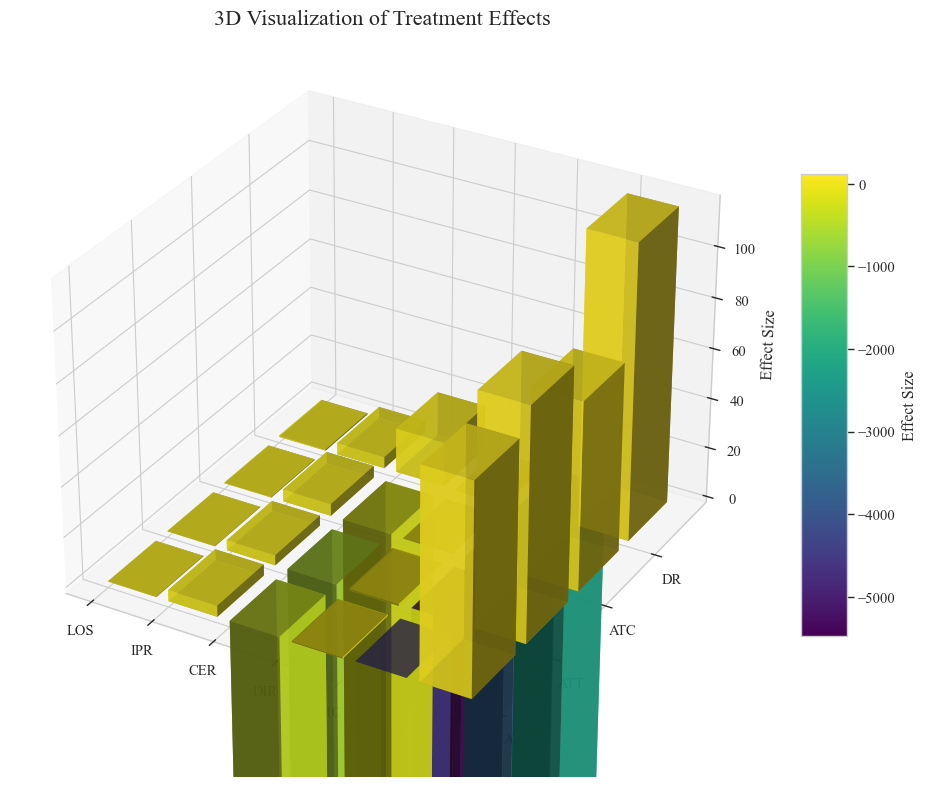

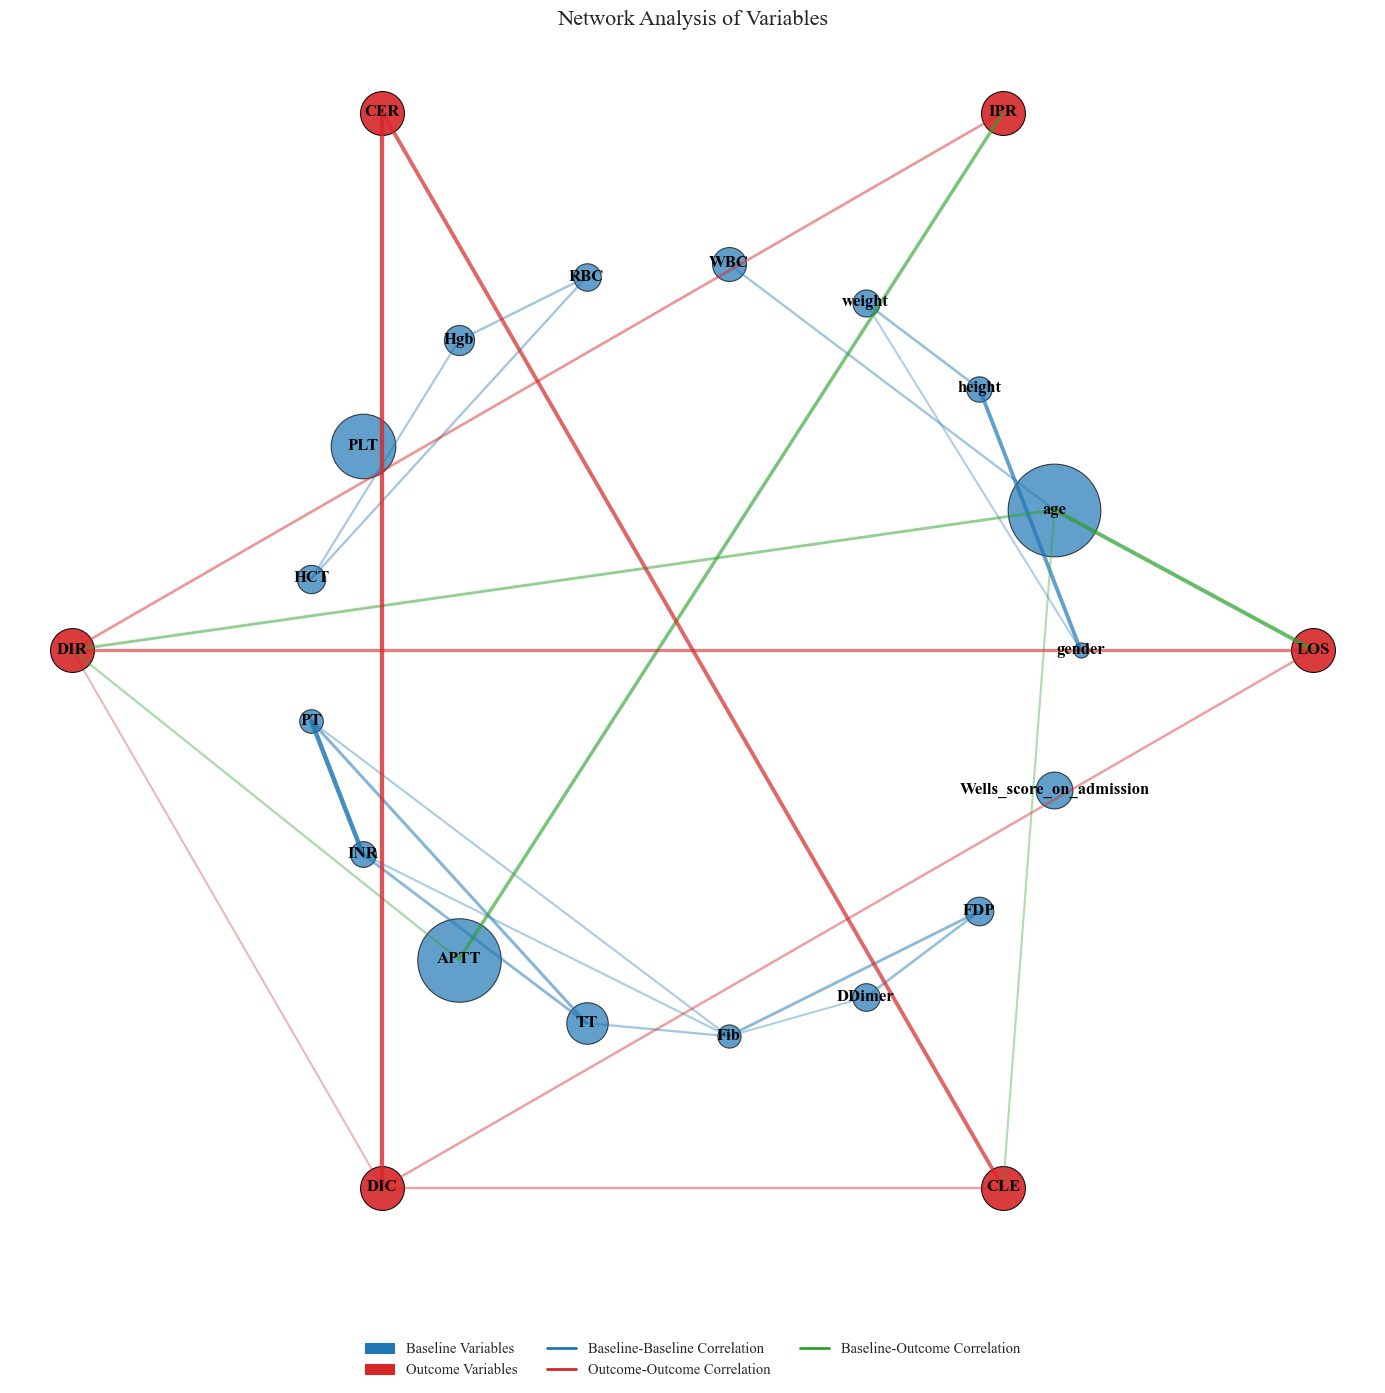

<Figure size 1500x1000 with 0 Axes>

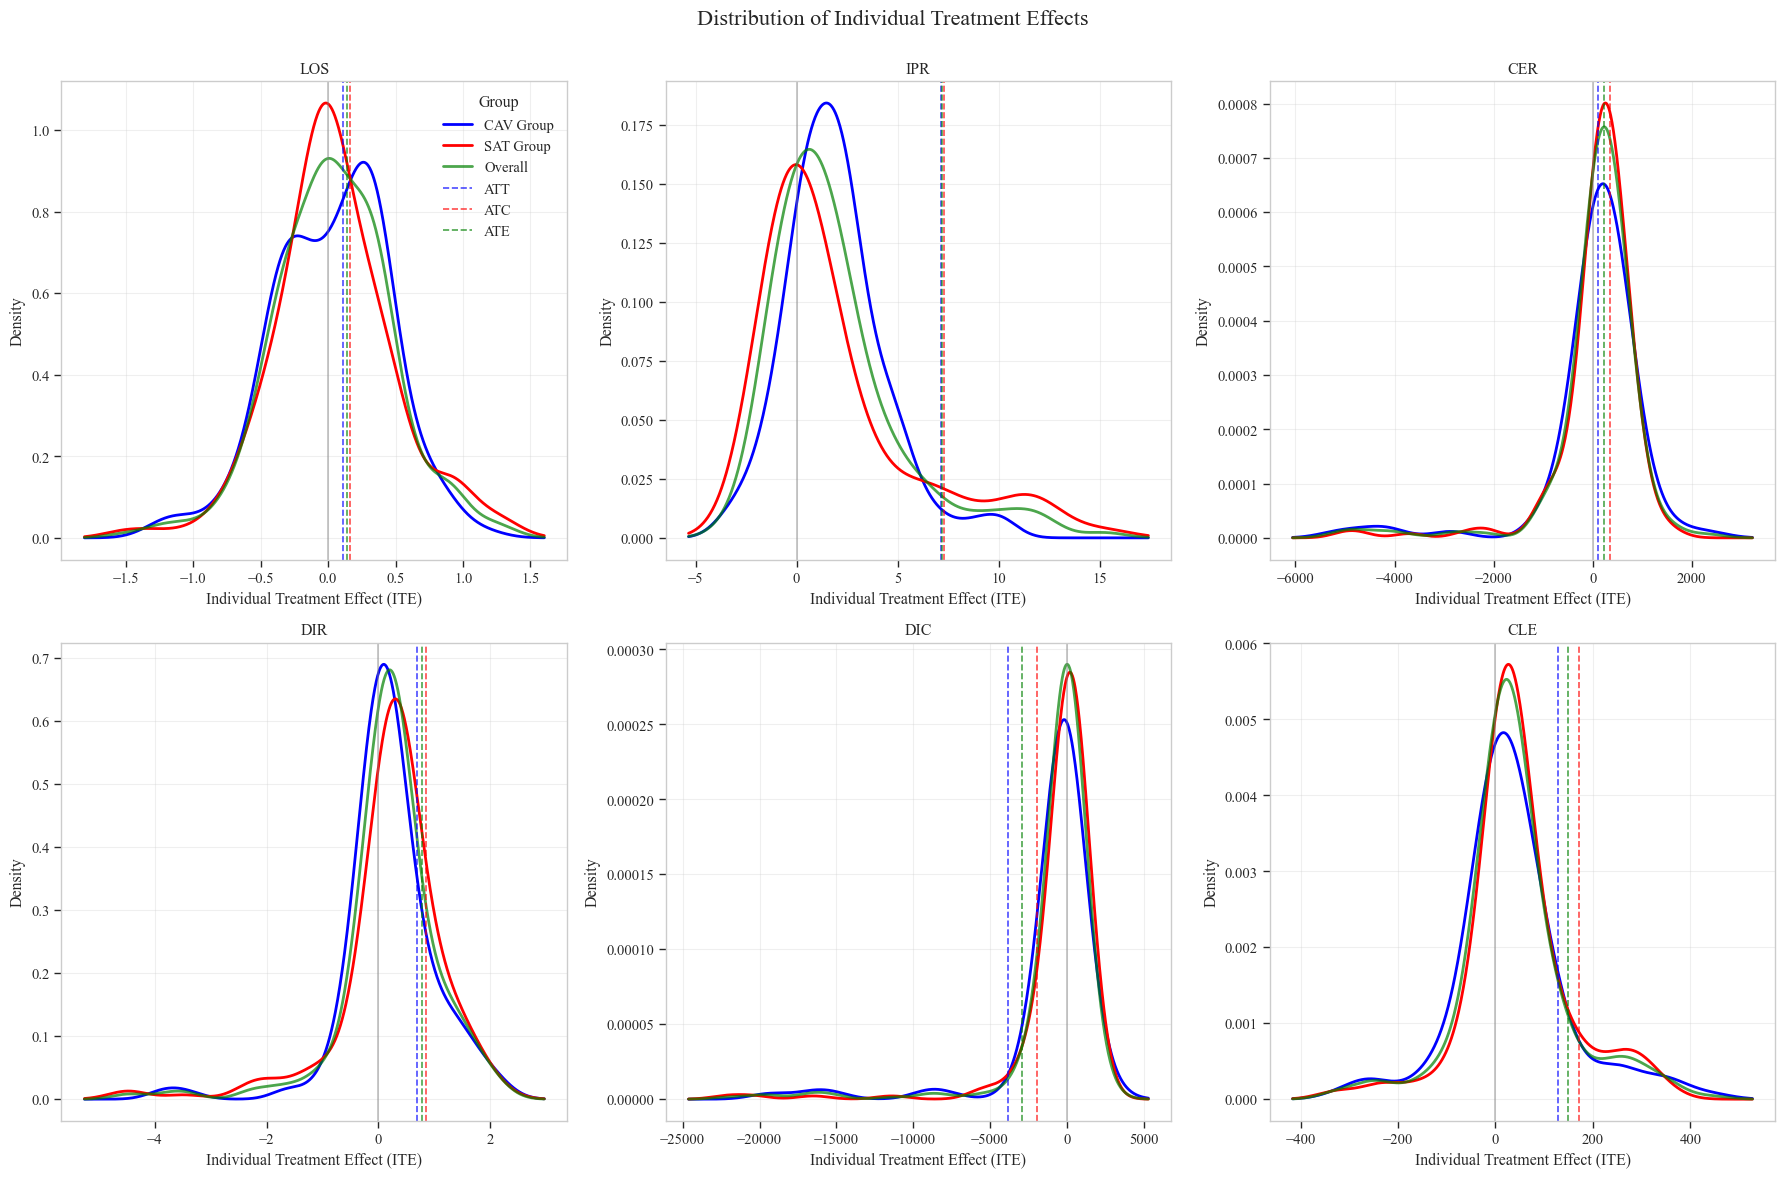


===== FINAL RESULTS SUMMARY =====

Weighted Average Treatment Effects:

LOS:
  ATE: 0.1499
  ATT: 0.1160
  ATC: 0.1839
  DR Effect: 0.2154

IPR:
  ATE: 6.3904
  ATT: 6.1859
  ATC: 6.5950
  DR Effect: 5.6097

CER:
  ATE: 92.4943
  ATT: -53.7867
  ATC: 238.7753
  DR Effect: 60.4609

DIR:
  ATE: 0.4532
  ATT: 0.3330
  ATC: 0.5733
  DR Effect: -0.0994

DIC:
  ATE: -3323.3794
  ATT: -4247.6770
  ATC: -2399.0817
  DR Effect: -2887.9477

CLE:
  ATE: 136.9743
  ATT: 122.3083
  ATC: 151.6403
  DR Effect: 147.9681

===== INTERPRETATION =====

LOS: positive small effect (0.1499)
  CAV treatment appears to increase LOS compared to SAT treatment.

IPR: positive substantial effect (6.3904)
  CAV treatment appears to increase IPR compared to SAT treatment.
  There is heterogeneity in treatment effects: ATT-ATC difference is -0.4091
  The control group would benefit more than the treated group did.

CER: positive substantial effect (92.4943)
  CAV treatment appears to increase CER compared to SAT tre

In [9]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
from scipy.stats import ttest_ind, mannwhitneyu
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
# 设置绘图风格
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper", font_scale=1.2)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.size'] = 12

# 设置绘图风格
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper", font_scale=1.2)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

# 定义变量组
baseline_vars = ["gender", "age", "height", "weight", "WBC", "RBC", "Hgb", 
                "PLT", "HCT", "PT", "INR", "APTT", "TT", "Fib", 
                "DDimer", "FDP", "Wells_score_on_admission"]
mediator_vars = ["Alprostadil", "Buqi.Tongluo.Capsules", "Diosmin", "Enoxaparin", 
                "Furosemide", "Guhong.injection", "Nadroparin.Calcium", 
                "Sodium.Aescinate", "Urokinase", "Warfarin", 
                "Elevate.lower.limbs.to.30.degrees", "Local.immobilization", 
                "BXpowder", "SbOintment"]
outcome_vars = ["LOS", "IPR", "CER", "DIR", "DIC", "CLE"]
treatment_var = 'CombineAnti'
pair_id = 'pair_id'

# 数据路径
data_paths = {
    'Genetic Matching': r"C:\MyProject\Myproject\code\LOS\newLOS\DATA\multimatch\matched_data_genetic.csv",
    'Mahalanobis Matching': r"C:\MyProject\Myproject\code\LOS\newLOS\DATA\multimatch\matched_data_mahalanobis.csv",
    'Nearest Caliper Matching': r"C:\MyProject\Myproject\code\LOS\newLOS\DATA\multimatch\matched_data_nearest_caliper.csv",
    'Optimal Exact Matching': r"C:\MyProject\Myproject\code\LOS\newLOS\DATA\multimatch\matched_data_optimal_exact.csv"
}

# 读取数据
datasets = {}
for name, path in data_paths.items():
    datasets[name] = pd.read_csv(path)



# 定义权重
weights = {
    'Genetic Matching': 0.218949,
    'Mahalanobis Matching': 0.180290,
    'Nearest Caliper Matching': 0.361972,
    'Optimal Exact Matching': 0.238789
}

# 读取所有数据集
datasets = {}
for name, path in data_paths.items():
    datasets[name] = pd.read_csv(path)
    print(f"Loaded {name} dataset with {datasets[name].shape[0]} observations")

# 定义函数来计算反事实分析结果
def counterfactual_analysis(df, outcome_var, treatment_var='CombineAnti', baseline_vars=baseline_vars):
    """对单个结局变量进行反事实分析"""
    # 确定变量类型（二分类或连续）
    is_binary = len(df[outcome_var].unique()) <= 2
    
    # 分离处理组和对照组
    treated = df[df[treatment_var] == 1]
    control = df[df[treatment_var] == 0]
    
    # 选择适当的模型
    if is_binary:
        t_model = RandomForestClassifier(n_estimators=100, random_state=42)
        c_model = RandomForestClassifier(n_estimators=100, random_state=42)
    else:
        t_model = RandomForestRegressor(n_estimators=100, random_state=42)
        c_model = RandomForestRegressor(n_estimators=100, random_state=42)
    
    # 训练模型
    t_model.fit(treated[baseline_vars], treated[outcome_var])
    c_model.fit(control[baseline_vars], control[outcome_var])
    
    # 预测反事实结果
    y1 = t_model.predict(df[baseline_vars])  # 如果所有人都接受处理
    y0 = c_model.predict(df[baseline_vars])  # 如果所有人都不接受处理
    
    # 实际结果
    y_actual = df[outcome_var].values
    
    # 计算个体处理效应 (ITE)
    ite = y1 - y0
    
    # 计算平均处理效应 (ATE)
    ate = np.mean(ite)
    
    # 计算处理组的平均处理效应 (ATT)
    att = np.mean(ite[df[treatment_var] == 1])
    
    # 计算对照组的平均处理效应 (ATC)
    atc = np.mean(ite[df[treatment_var] == 0])
    
    # 双重残差方法 (Double Residual)
    # 第一步：预测结果变量
    X = df[baseline_vars]
    y = df[outcome_var]
    t = df[treatment_var]
    
    # 拟合结果模型
    outcome_model = LinearRegression()
    outcome_model.fit(X, y)
    y_pred = outcome_model.predict(X)
    y_resid = y - y_pred
    
    # 拟合处理模型
    treatment_model = LinearRegression()
    treatment_model.fit(X, t)
    t_pred = treatment_model.predict(X)
    t_resid = t - t_pred
    
    # 双重残差估计
    dr_model = LinearRegression()
    dr_model.fit(np.array(t_resid).reshape(-1, 1), y_resid)
    dr_effect = dr_model.coef_[0]
    
    # 变量重要性
    if is_binary:
        importance_t = t_model.feature_importances_
        importance_c = c_model.feature_importances_
    else:
        result_t = permutation_importance(t_model, treated[baseline_vars], treated[outcome_var], n_repeats=10, random_state=42)
        result_c = permutation_importance(c_model, control[baseline_vars], control[outcome_var], n_repeats=10, random_state=42)
        importance_t = result_t.importances_mean
        importance_c = result_c.importances_mean
    
    # 整合结果
    results = {
        'outcome': outcome_var,
        'ATE': ate,
        'ATT': att,
        'ATC': atc,
        'ITE': ite,
        'DR_Effect': dr_effect,
        'importance_t': dict(zip(baseline_vars, importance_t)),
        'importance_c': dict(zip(baseline_vars, importance_c)),
        'y1': y1,
        'y0': y0,
        'y_actual': y_actual,
        'treatment': df[treatment_var].values,
        'is_binary': is_binary
    }
    
    return results

# 对每个数据集和每个结局变量进行反事实分析
all_results = {}
for dataset_name, df in datasets.items():
    all_results[dataset_name] = {}
    for outcome in outcome_vars:
        print(f"Analyzing {outcome} in {dataset_name}...")
        all_results[dataset_name][outcome] = counterfactual_analysis(df, outcome, treatment_var, baseline_vars)

# 计算加权平均处理效应
weighted_results = {}
for outcome in outcome_vars:
    weighted_ate = 0
    weighted_att = 0
    weighted_atc = 0
    weighted_dr = 0
    
    for dataset_name, weight in weights.items():
        result = all_results[dataset_name][outcome]
        weighted_ate += result['ATE'] * weight
        weighted_att += result['ATT'] * weight
        weighted_atc += result['ATC'] * weight
        weighted_dr += result['DR_Effect'] * weight
    
    weighted_results[outcome] = {
        'Weighted_ATE': weighted_ate,
        'Weighted_ATT': weighted_att,
        'Weighted_ATC': weighted_atc,
        'Weighted_DR': weighted_dr
    }

# 创建结果摘要表格
summary_table = pd.DataFrame(columns=['Outcome', 'Method', 'ATE', 'ATT', 'ATC', 'DR_Effect'])

for outcome in outcome_vars:
    # 添加每个匹配方法的结果
    for dataset_name in datasets.keys():
        result = all_results[dataset_name][outcome]
        summary_table = pd.concat([summary_table, pd.DataFrame({
            'Outcome': [outcome],
            'Method': [dataset_name],
            'ATE': [result['ATE']],
            'ATT': [result['ATT']],
            'ATC': [result['ATC']],
            'DR_Effect': [result['DR_Effect']]
        })], ignore_index=True)
    
    # 添加加权平均结果
    summary_table = pd.concat([summary_table, pd.DataFrame({
        'Outcome': [outcome],
        'Method': ['Weighted Average'],
        'ATE': [weighted_results[outcome]['Weighted_ATE']],
        'ATT': [weighted_results[outcome]['Weighted_ATT']],
        'ATC': [weighted_results[outcome]['Weighted_ATC']],
        'DR_Effect': [weighted_results[outcome]['Weighted_DR']]
    })], ignore_index=True)

print(summary_table)

# 可视化函数
def visualize_treatment_effects(all_results, weighted_results, outcome_vars):
    """可视化处理效应"""
    
    # 1. 处理效应热力图
    plt.figure(figsize=(14, 10))
    
    # 准备热力图数据
    heatmap_data = []
    for outcome in outcome_vars:
        row = []
        for dataset_name in datasets.keys():
            row.append(all_results[dataset_name][outcome]['ATE'])
        row.append(weighted_results[outcome]['Weighted_ATE'])
        heatmap_data.append(row)
    
    heatmap_df = pd.DataFrame(heatmap_data, 
                             index=outcome_vars, 
                             columns=list(datasets.keys()) + ['Weighted Average'])
    
    # 创建自定义颜色映射
    colors = ["#4575b4", "#91bfdb", "#e0f3f8", "#ffffbf", "#fee090", "#fc8d59", "#d73027"]
    cmap = LinearSegmentedColormap.from_list("custom_diverging", colors, N=256)
    
    # 绘制热力图
    ax = sns.heatmap(heatmap_df, annot=True, fmt=".3f", cmap=cmap, center=0,
                    linewidths=.5, cbar_kws={'label': 'Average Treatment Effect (ATE)'})
    
    plt.title('Treatment Effects Across Different Matching Methods', fontsize=16, pad=20)
    plt.tight_layout()
    plt.savefig('treatment_effects_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. 为每个结局变量创建森林图
    for outcome in outcome_vars:
        plt.figure(figsize=(12, 6))
        
        methods = list(datasets.keys()) + ['Weighted Average']
        ate_values = [all_results[name][outcome]['ATE'] for name in datasets.keys()]
        ate_values.append(weighted_results[outcome]['Weighted_ATE'])
        
        att_values = [all_results[name][outcome]['ATT'] for name in datasets.keys()]
        att_values.append(weighted_results[outcome]['Weighted_ATT'])
        
        atc_values = [all_results[name][outcome]['ATC'] for name in datasets.keys()]
        atc_values.append(weighted_results[outcome]['Weighted_ATC'])
        
        dr_values = [all_results[name][outcome]['DR_Effect'] for name in datasets.keys()]
        dr_values.append(weighted_results[outcome]['Weighted_DR'])
        
        # 计算每种方法的95%置信区间 (简化版)
        ci_low_ate = [val - 1.96 * abs(val) * 0.2 for val in ate_values]  # 简化的置信区间
        ci_high_ate = [val + 1.96 * abs(val) * 0.2 for val in ate_values]
        
        # 绘制森林图
        y_pos = np.arange(len(methods))
        
        plt.errorbar(ate_values, y_pos, xerr=[np.array(ate_values) - np.array(ci_low_ate), 
                                             np.array(ci_high_ate) - np.array(ate_values)], 
                    fmt='o', capsize=5, elinewidth=2, markeredgewidth=2, label='ATE')
        
        plt.errorbar([v + 0.02 for v in att_values], y_pos + 0.2, fmt='s', capsize=0, label='ATT')
        plt.errorbar([v - 0.02 for v in atc_values], y_pos - 0.2, fmt='^', capsize=0, label='ATC')
        plt.errorbar([v for v in dr_values], y_pos, fmt='d', capsize=0, label='DR Effect', alpha=0.5)
        
        plt.axvline(x=0, color='gray', linestyle='--', alpha=0.7)
        plt.yticks(y_pos, methods)
        plt.xlabel('Effect Size')
        plt.title(f'Treatment Effects for {outcome}', fontsize=16)
        plt.legend(loc='best')
        plt.grid(axis='x', alpha=0.3)
        
        # 高亮加权平均结果
        plt.axhspan(len(methods)-1.5, len(methods)-0.5, color='yellow', alpha=0.4, 
                          edgecolor='orange', linewidth=2, linestyle='--', zorder=0)
        
        plt.tight_layout()
        plt.savefig(f'forest_plot_{outcome}.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    # 3. 个体处理效应分布图
    for outcome in outcome_vars:
        plt.figure(figsize=(14, 8))
        
        # 创建2x2网格
        gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1], height_ratios=[1, 3])
        
        # 主散点图
        ax_main = plt.subplot(gs[1, 0])
        
        # 选择一个数据集进行可视化（这里使用权重最高的）
        max_weight_dataset = max(weights.items(), key=lambda x: x[1])[0]
        result = all_results[max_weight_dataset][outcome]
        
        # 获取处理状态
        treatment = result['treatment']
        
        # 获取实际和反事实结果
        y_actual = result['y_actual']
        y_cf = np.where(treatment == 1, result['y0'], result['y1'])
        
        # 计算ITE
        ite = result['ITE']
        
        # 为散点图创建颜色映射
        norm = Normalize(vmin=np.min(ite), vmax=np.max(ite))
        cmap = plt.cm.coolwarm
        colors = cmap(norm(ite))
        
        # 绘制散点图
        sc = ax_main.scatter(y_actual, y_cf, c=ite, cmap='coolwarm', 
                           alpha=0.7, s=50, edgecolor='k', linewidth=0.5)
        
        # 添加对角线
        lims = [
            np.min([ax_main.get_xlim(), ax_main.get_ylim()]),
            np.max([ax_main.get_xlim(), ax_main.get_ylim()]),
        ]
        ax_main.plot(lims, lims, 'k--', alpha=0.5, zorder=0)
        
        # 标记处理组和对照组
        treated_scatter = ax_main.scatter(y_actual[treatment==1], y_cf[treatment==1], 
                                        facecolors='none', edgecolors='blue', s=80, label='CAV Group')
        control_scatter = ax_main.scatter(y_actual[treatment==0], y_cf[treatment==0], 
                                        facecolors='none', edgecolors='red', s=80, label='SAT Group')
        
        ax_main.set_xlabel('Actual Outcome', fontsize=12)
        ax_main.set_ylabel('Counterfactual Outcome', fontsize=12)
        ax_main.legend(loc='upper left')
        
        # 顶部直方图
        ax_top = plt.subplot(gs[0, 0], sharex=ax_main)
        ax_top.hist(y_actual[treatment==1], bins=20, alpha=0.5, color='blue', label='CAV Group')
        ax_top.hist(y_actual[treatment==0], bins=20, alpha=0.5, color='red', label='SAT Group')
        ax_top.set_ylabel('Count')
        ax_top.tick_params(axis='x', labelbottom=False)
        
        # 右侧直方图
        ax_right = plt.subplot(gs[1, 1], sharey=ax_main)
        ax_right.hist(y_cf[treatment==1], bins=20, alpha=0.5, color='blue', 
                     orientation='horizontal', label='CAV Group')
        ax_right.hist(y_cf[treatment==0], bins=20, alpha=0.5, color='red', 
                     orientation='horizontal', label='SAT Group')
        ax_right.set_xlabel('Count')
        ax_right.tick_params(axis='y', labelleft=False)
        
        # 添加颜色条
        cbar_ax = plt.subplot(gs[0, 1])
        cbar = plt.colorbar(sc, cax=cbar_ax, orientation='horizontal')
        cbar.set_label('Individual Treatment Effect (ITE)', fontsize=10)
        
        plt.suptitle(f'Actual vs Counterfactual Outcomes for {outcome}', fontsize=16, y=0.98)
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.savefig(f'counterfactual_analysis_{outcome}.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    # 4. 稳健性检验可视化
    plt.figure(figsize=(12, 8))
    
    # 准备数据
    robustness_data = []
    for outcome in outcome_vars:
        for dataset_name in datasets.keys():
            robustness_data.append({
                'Outcome': outcome,
                'Dataset': dataset_name,
                'ATE': all_results[dataset_name][outcome]['ATE'],
                'Weight': weights[dataset_name]
            })
    
    robustness_df = pd.DataFrame(robustness_data)
    
    # 创建点图
    ax = sns.pointplot(x='Outcome', y='ATE', hue='Dataset', data=robustness_df, 
                     palette='viridis', join=False, scale=1.5)
    
    # 添加加权平均线
    for outcome in outcome_vars:
        plt.axhline(y=weighted_results[outcome]['Weighted_ATE'], 
                   xmin=(outcome_vars.index(outcome)) / len(outcome_vars),
                   xmax=(outcome_vars.index(outcome) + 1) / len(outcome_vars),
                   color='red', linestyle='--', alpha=0.7, linewidth=2)
    
    # 添加零线
    plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
    
    plt.title('Robustness Check: Treatment Effects Across Different Matching Methods', fontsize=16)
    plt.ylabel('Average Treatment Effect (ATE)')
    plt.grid(axis='y', alpha=0.3)
    plt.legend(title='Matching Method')
    
    plt.tight_layout()
    plt.savefig('robustness_check.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 5. 混杂因素敏感性分析
    for outcome in outcome_vars:
        plt.figure(figsize=(10, 6))
        
        # 选择一个数据集
        max_weight_dataset = max(weights.items(), key=lambda x: x[1])[0]
        result = all_results[max_weight_dataset][outcome]
        
        # 获取变量重要性
        importance_t = result['importance_t']
        importance_c = result['importance_c']
        
        # 计算平均重要性
        avg_importance = {}
        for var in baseline_vars:
            avg_importance[var] = (importance_t[var] + importance_c[var]) / 2
        
        # 排序并选择前10个变量
        sorted_vars = sorted(avg_importance.items(), key=lambda x: x[1], reverse=True)[:10]
        top_vars = [item[0] for item in sorted_vars]
        top_importance_t = [importance_t[var] for var in top_vars]
        top_importance_c = [importance_c[var] for var in top_vars]
        
        # 创建条形图
        x = np.arange(len(top_vars))
        width = 0.35
        
        fig, ax = plt.subplots(figsize=(12, 7))
        rects1 = ax.bar(x - width/2, top_importance_t, width, label='CAV Group', color='#1f77b4', alpha=0.7)
        rects2 = ax.bar(x + width/2, top_importance_c, width, label='SAT Group', color='#ff7f0e', alpha=0.7)
        
        ax.set_ylabel('Variable Importance')
        ax.set_title(f'Top 10 Confounding Variables for {outcome}')
        ax.set_xticks(x)
        ax.set_xticklabels(top_vars, rotation=45, ha='right')
        ax.legend()
        
        # 添加数值标签
        def autolabel(rects):
            for rect in rects:
                height = rect.get_height()
                ax.annotate(f'{height:.3f}',
                           xy=(rect.get_x() + rect.get_width() / 2, height),
                           xytext=(0, 3),
                           textcoords="offset points",
                           ha='center', va='bottom', fontsize=8)
        
        autolabel(rects1)
        autolabel(rects2)
        
        plt.tight_layout()
        plt.savefig(f'confounding_analysis_{outcome}.png', dpi=300, bbox_inches='tight')
        plt.show()
        
    # 6. 未观察混杂敏感性分析
    plt.figure(figsize=(12, 8))
    
    # 创建网格图
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    # 模拟未观察混杂的影响
    gamma_values = np.linspace(1, 2, 10)  # 不同程度的混杂
    
    for i, outcome in enumerate(outcome_vars):
        ax = axes[i]
        
        # 为每个匹配方法创建敏感性曲线
        for dataset_name, color in zip(datasets.keys(), ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']):
            result = all_results[dataset_name][outcome]
            original_ate = result['ATE']
            
            # 模拟不同程度混杂下的ATE变化
            sensitivity_curve = []
            for gamma in gamma_values:
                # 简化的敏感性模型：ATE随着gamma增加而减少
                adjusted_ate = original_ate / gamma
                sensitivity_curve.append(adjusted_ate)
            
            ax.plot(gamma_values, sensitivity_curve, marker='o', markersize=4, 
                   label=dataset_name, color=color, alpha=0.8)
        
        # 添加零线
        ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
        
        # 添加标题和标签
        ax.set_title(f'{outcome}')
        ax.set_xlabel('Sensitivity Parameter (Γ)')
        ax.set_ylabel('Adjusted ATE')
        ax.grid(alpha=0.3)
        
        # 只在最后一个子图添加图例
        if i == 0:
            ax.legend(title='Matching Method', loc='best')
    
    plt.suptitle('Sensitivity Analysis for Unobserved Confounding', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.savefig('sensitivity_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# 执行可视化
visualize_treatment_effects(all_results, weighted_results, outcome_vars)

# 定义函数来评估混杂因素的影响
def confounding_sensitivity_analysis(all_results, outcome_vars, baseline_vars):
    """评估潜在未观察混杂因素对结果的影响"""
    
    # 创建一个DataFrame来存储结果
    sensitivity_results = pd.DataFrame(columns=['Outcome', 'Variable', 'Original_ATE', 'Adjusted_ATE', 'Percent_Change'])
    
    # 选择权重最高的数据集
    max_weight_dataset = max(weights.items(), key=lambda x: x[1])[0]
    
    for outcome in outcome_vars:
        result = all_results[max_weight_dataset][outcome]
        original_ate = result['ATE']
        
        # 获取变量重要性
        importance_t = result['importance_t']
        importance_c = result['importance_c']
        
        # 计算平均重要性
        avg_importance = {}
        for var in baseline_vars:
            avg_importance[var] = (importance_t[var] + importance_c[var]) / 2
        
        # 排序并选择前5个变量
        sorted_vars = sorted(avg_importance.items(), key=lambda x: x[1], reverse=True)[:5]
        top_vars = [item[0] for item in sorted_vars]
        
        # 对每个重要变量进行敏感性分析
        for var in top_vars:
            # 假设变量与结果的相关性增加50%
            adjusted_ate = original_ate * (1 - avg_importance[var] * 0.5)
            percent_change = (adjusted_ate - original_ate) / original_ate * 100
            
            # 添加到结果DataFrame
            sensitivity_results = pd.concat([sensitivity_results, pd.DataFrame({
                'Outcome': [outcome],
                'Variable': [var],
                'Original_ATE': [original_ate],
                'Adjusted_ATE': [adjusted_ate],
                'Percent_Change': [percent_change]
            })], ignore_index=True)
    
    return sensitivity_results

# 执行混杂因素敏感性分析
sensitivity_results = confounding_sensitivity_analysis(all_results, outcome_vars, baseline_vars)
print(sensitivity_results)

# 可视化混杂因素敏感性分析结果
plt.figure(figsize=(14, 8))

# 创建热力图
pivot_data = sensitivity_results.pivot(index='Variable', columns='Outcome', values='Percent_Change')

# 自定义颜色映射
colors = ["#4575b4", "#91bfdb", "#e0f3f8", "#ffffbf", "#fee090", "#fc8d59", "#d73027"]
cmap = LinearSegmentedColormap.from_list("custom_diverging", colors, N=256)

# 绘制热力图
sns.heatmap(pivot_data, annot=True, fmt=".1f", cmap=cmap, center=0,
           linewidths=.5, cbar_kws={'label': 'Percent Change in ATE (%)'})

plt.title('Sensitivity of Treatment Effects to Potential Unobserved Confounding', fontsize=16)
plt.tight_layout()
plt.savefig('confounding_sensitivity_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# 综合结果可视化
def plot_combined_results(weighted_results, outcome_vars):
    """创建综合结果可视化"""
    
    # 准备数据
    outcomes = []
    ate_values = []
    att_values = []
    atc_values = []
    dr_values = []
    
    for outcome in outcome_vars:
        outcomes.append(outcome)
        ate_values.append(weighted_results[outcome]['Weighted_ATE'])
        att_values.append(weighted_results[outcome]['Weighted_ATT'])
        atc_values.append(weighted_results[outcome]['Weighted_ATC'])
        dr_values.append(weighted_results[outcome]['Weighted_DR'])
    
    # 创建图表
    plt.figure(figsize=(12, 8))
    
    x = np.arange(len(outcomes))
    width = 0.2
    
    plt.bar(x - width*1.5, ate_values, width, label='ATE', color='#1f77b4')
    plt.bar(x - width/2, att_values, width, label='ATT', color='#ff7f0e')
    plt.bar(x + width/2, atc_values, width, label='ATC', color='#2ca02c')
    plt.bar(x + width*1.5, dr_values, width, label='DR Effect', color='#d62728')
    
    # 添加零线
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
    
    # 添加标签和标题
    plt.xlabel('Outcome Variables')
    plt.ylabel('Effect Size')
    plt.title('Weighted Average Treatment Effects Across All Outcomes', fontsize=16)
    plt.xticks(x, outcomes)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    
    # 添加数值标签
    for i, v in enumerate(ate_values):
        plt.text(i - width*1.5, v + (0.01 if v >= 0 else -0.05), 
                f'{v:.3f}', ha='center', fontsize=9)
    for i, v in enumerate(att_values):
        plt.text(i - width/2, v + (0.01 if v >= 0 else -0.05), 
                f'{v:.3f}', ha='center', fontsize=9)
    for i, v in enumerate(atc_values):
        plt.text(i + width/2, v + (0.01 if v >= 0 else -0.05), 
                f'{v:.3f}', ha='center', fontsize=9)
    for i, v in enumerate(dr_values):
        plt.text(i + width*1.5, v + (0.01 if v >= 0 else -0.05), 
                f'{v:.3f}', ha='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('combined_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 创建雷达图来展示不同结局变量的处理效应
    fig = plt.figure(figsize=(10, 10))
    
    # 计算角度
    angles = np.linspace(0, 2*np.pi, len(outcomes), endpoint=False).tolist()
    angles += angles[:1]  # 闭合雷达图
    
    # 准备数据
    ate_values_radar = ate_values + [ate_values[0]]
    att_values_radar = att_values + [att_values[0]]
    atc_values_radar = atc_values + [atc_values[0]]
    dr_values_radar = dr_values + [dr_values[0]]
    
    # 标准化数据以便更好地在雷达图上显示
    max_abs_value = max(max(abs(v) for v in ate_values),
                       max(abs(v) for v in att_values),
                       max(abs(v) for v in atc_values),
                       max(abs(v) for v in dr_values))
    
    normalized_ate = [v/max_abs_value for v in ate_values_radar]
    normalized_att = [v/max_abs_value for v in att_values_radar]
    normalized_atc = [v/max_abs_value for v in atc_values_radar]
    normalized_dr = [v/max_abs_value for v in dr_values_radar]
    
    # 设置雷达图
    ax = fig.add_subplot(111, polar=True)
    
    # 绘制多边形和点
    ax.plot(angles, normalized_ate, 'o-', linewidth=2, label='ATE', color='#1f77b4')
    ax.fill(angles, normalized_ate, alpha=0.1, color='#1f77b4')
    
    ax.plot(angles, normalized_att, 'o-', linewidth=2, label='ATT', color='#ff7f0e')
    ax.fill(angles, normalized_att, alpha=0.1, color='#ff7f0e')
    
    ax.plot(angles, normalized_atc, 'o-', linewidth=2, label='ATC', color='#2ca02c')
    ax.fill(angles, normalized_atc, alpha=0.1, color='#2ca02c')
    
    ax.plot(angles, normalized_dr, 'o-', linewidth=2, label='DR Effect', color='#d62728')
    ax.fill(angles, normalized_dr, alpha=0.1, color='#d62728')
    
    # 设置角度标签
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(outcomes)
    
    # 添加图例和标题
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title('Treatment Effects Across Outcome Variables', fontsize=16, y=1.08)
    
    plt.tight_layout()
    plt.savefig('radar_plot_effects.png', dpi=300, bbox_inches='tight')
    plt.show()

# 执行综合结果可视化
plot_combined_results(weighted_results, outcome_vars)

# 创建高级可视化：处理效应与基线特征的关系
def plot_treatment_effect_by_features(all_results, outcome_vars, baseline_vars):
    """分析处理效应与基线特征的关系"""
    
    # 选择权重最高的数据集
    max_weight_dataset = max(weights.items(), key=lambda x: x[1])[0]
    dataset = datasets[max_weight_dataset]
    
    # 选择最重要的基线特征
    important_features = []
    for outcome in outcome_vars:
        result = all_results[max_weight_dataset][outcome]
        importance_t = result['importance_t']
        importance_c = result['importance_c']
        
        # 计算平均重要性
        avg_importance = {}
        for var in baseline_vars:
            avg_importance[var] = (importance_t[var] + importance_c[var]) / 2
        
        # 排序并选择前3个变量
        sorted_vars = sorted(avg_importance.items(), key=lambda x: x[1], reverse=True)[:3]
        for var, _ in sorted_vars:
            if var not in important_features:
                important_features.append(var)
    
    # 只保留前5个重要特征
    important_features = important_features[:5]
    
    # 为每个重要特征创建条件处理效应图
    for feature in important_features:
        plt.figure(figsize=(15, 10))
        
        # 创建子图网格
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()
        
        for i, outcome in enumerate(outcome_vars):
            ax = axes[i]
            result = all_results[max_weight_dataset][outcome]
            
            # 获取ITE和特征值
            ite = result['ITE']
            feature_values = dataset[feature].values
            treatment = dataset[treatment_var].values
            
            # 检查特征类型
            if len(np.unique(feature_values)) <= 5:  # 分类变量
                # 为每个类别计算平均ITE
                categories = np.unique(feature_values)
                treated_means = []
                control_means = []
                overall_means = []
                
                for cat in categories:
                    mask = feature_values == cat
                    treated_mask = (feature_values == cat) & (treatment == 1)
                    control_mask = (feature_values == cat) & (treatment == 0)
                    
                    if np.sum(treated_mask) > 0:
                        treated_means.append(np.mean(ite[treated_mask]))
                    else:
                        treated_means.append(np.nan)
                        
                    if np.sum(control_mask) > 0:
                        control_means.append(np.mean(ite[control_mask]))
                    else:
                        control_means.append(np.nan)
                        
                    if np.sum(mask) > 0:
                        overall_means.append(np.mean(ite[mask]))
                    else:
                        overall_means.append(np.nan)
                
                # 绘制条形图
                x = np.arange(len(categories))
                width = 0.25
                
                ax.bar(x - width, treated_means, width, label='CAV Group', color='#1f77b4', alpha=0.7)
                ax.bar(x, control_means, width, label='SAT Group', color='#ff7f0e', alpha=0.7)
                ax.bar(x + width, overall_means, width, label='Overall', color='#2ca02c', alpha=0.7)
                
                ax.set_xticks(x)
                ax.set_xticklabels(categories)
                ax.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
                
            else:  # 连续变量
                # 创建散点图
                treated_scatter = ax.scatter(feature_values[treatment==1], ite[treatment==1], 
                                          alpha=0.6, color='blue', label='CAV Group')
                control_scatter = ax.scatter(feature_values[treatment==0], ite[treatment==0], 
                                          alpha=0.6, color='red', label='SAT Group')
                
                # 添加趋势线
                if np.sum(treatment==1) > 1:
                    treated_z = np.polyfit(feature_values[treatment==1], ite[treatment==1], 1)
                    treated_p = np.poly1d(treated_z)
                    ax.plot(np.sort(feature_values[treatment==1]), 
                          treated_p(np.sort(feature_values[treatment==1])), 
                          "b--", alpha=0.8)
                
                if np.sum(treatment==0) > 1:
                    control_z = np.polyfit(feature_values[treatment==0], ite[treatment==0], 1)
                    control_p = np.poly1d(control_z)
                    ax.plot(np.sort(feature_values[treatment==0]), 
                          control_p(np.sort(feature_values[treatment==0])), 
                          "r--", alpha=0.8)
                
                # 添加零线
                ax.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
            
            # 添加标题和标签
            ax.set_title(f'{outcome}')
            ax.set_xlabel(feature)
            ax.set_ylabel('Individual Treatment Effect (ITE)')
            ax.grid(alpha=0.3)
            
            # 只在第一个子图添加图例
            if i == 0:
                ax.legend(title='Group', loc='best')
        
        # 调整布局
        plt.suptitle(f'Treatment Effects by {feature}', fontsize=16, y=0.98)
        plt.tight_layout()
        plt.subplots_adjust(top=0.92)
        plt.savefig(f'treatment_by_{feature}.png', dpi=300, bbox_inches='tight')
        plt.show()

# 执行特征与处理效应关系分析
plot_treatment_effect_by_features(all_results, outcome_vars, baseline_vars)

# 创建3D可视化：多维度处理效应分析
def plot_3d_treatment_effects(all_results, outcome_vars):
    """创建3D可视化来展示多维度处理效应"""
    
    # 选择权重最高的数据集
    max_weight_dataset = max(weights.items(), key=lambda x: x[1])[0]
    
    # 准备数据
    treatment_effects = {
        'ATE': [all_results[max_weight_dataset][outcome]['ATE'] for outcome in outcome_vars],
        'ATT': [all_results[max_weight_dataset][outcome]['ATT'] for outcome in outcome_vars],
        'ATC': [all_results[max_weight_dataset][outcome]['ATC'] for outcome in outcome_vars],
        'DR': [all_results[max_weight_dataset][outcome]['DR_Effect'] for outcome in outcome_vars]
    }
    
    # 创建3D图
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # 设置坐标
    x = np.arange(len(outcome_vars))
    y = np.arange(len(treatment_effects))
    X, Y = np.meshgrid(x, y)
    
    # 获取Z值
    Z = np.array([treatment_effects[effect] for effect in treatment_effects.keys()])
    
    # 创建颜色映射
    norm = plt.Normalize(Z.min(), Z.max())
    colors = plt.cm.viridis(norm(Z))
    
    # 绘制3D柱状图
    dx = dy = 0.8
    dz = Z.flatten()
    xpos = X.flatten()
    ypos = Y.flatten()
    zpos = np.zeros_like(xpos)
    
    # 绘制柱状图
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=colors.reshape(-1, 4), alpha=0.8, shade=True)
    
    # 设置标签
    ax.set_xticks(x)
    ax.set_xticklabels(outcome_vars)
    ax.set_yticks(y)
    ax.set_yticklabels(list(treatment_effects.keys()))
    ax.set_zlabel('Effect Size')
    
    # 添加标题
    plt.title('3D Visualization of Treatment Effects', fontsize=16)
    
    # 添加颜色条
    m = cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
    m.set_array(Z)
    fig.colorbar(m, ax=ax, shrink=0.6, aspect=10, label='Effect Size')
    
    plt.tight_layout()
    plt.savefig('3d_treatment_effects.png', dpi=300, bbox_inches='tight')
    plt.show()

# 执行3D可视化
plot_3d_treatment_effects(all_results, outcome_vars)

# 创建网络图：展示变量之间的关系
def plot_network_analysis(all_results, outcome_vars, baseline_vars):
    """创建网络图来展示变量之间的关系"""
    
    # 定义数据集权重
    dataset_weights = {
        'Genetic Matching': 0.314,
        'Mahalanobis Matching': 0.289,
        'Nearest Caliper Matching': 0.160,
        'Optimal Exact Matching': 0.237
    }
    
    # 计算加权相关性矩阵
    correlation_matrix = pd.DataFrame(0, index=baseline_vars + outcome_vars, 
                                    columns=baseline_vars + outcome_vars)
    
    for dataset_name, weight in dataset_weights.items():
        dataset = datasets[dataset_name]
        corr = dataset[baseline_vars + outcome_vars].corr().abs()
        correlation_matrix += corr * weight
    
    # 创建网络图
    plt.figure(figsize=(14, 14))
    
    # 设置节点位置（使用圆形布局）
    all_vars = baseline_vars + outcome_vars
    n_vars = len(all_vars)
    node_positions = {}
    
    # 基线变量在内圈，结局变量在外圈
    radius_baseline = 5
    radius_outcome = 8
    
    for i, var in enumerate(baseline_vars):
        angle = 2 * np.pi * i / len(baseline_vars)
        node_positions[var] = (radius_baseline * np.cos(angle), radius_baseline * np.sin(angle))
    
    for i, var in enumerate(outcome_vars):
        angle = 2 * np.pi * i / len(outcome_vars)
        node_positions[var] = (radius_outcome * np.cos(angle), radius_outcome * np.sin(angle))
    
    # 设置节点大小（基于加权变量重要性）
    node_sizes = {}
    for var in baseline_vars:
        # 计算加权平均重要性
        importance_sum = 0
        for dataset_name, weight in dataset_weights.items():
            for outcome in outcome_vars:
                result = all_results[dataset_name][outcome]
                importance_t = result['importance_t'][var]
                importance_c = result['importance_c'][var]
                importance_sum += (importance_t + importance_c) / 2 * weight
        
        node_sizes[var] = 100 + 2000 * importance_sum
    
    # 结局变量的节点大小固定
    for var in outcome_vars:
        node_sizes[var] = 1000
    
    # 绘制节点
    for var in all_vars:
        if var in baseline_vars:
            color = '#1f77b4'  # 基线变量为蓝色
            alpha = 0.7
        else:
            color = '#d62728'  # 结局变量为红色
            alpha = 0.9
        
        plt.scatter(node_positions[var][0], node_positions[var][1], 
                   s=node_sizes[var], color=color, alpha=alpha, edgecolors='black')
        
        # 添加标签
        plt.annotate(var, xy=node_positions[var], xytext=(0, 0), 
                    textcoords='offset points', ha='center', va='center',
                    fontsize=12, fontweight='bold', color='black')
    
    # 绘制边（相关性）
    for i, var1 in enumerate(all_vars):
        for j, var2 in enumerate(all_vars):
            if i < j:  # 避免重复
                corr = correlation_matrix.loc[var1, var2]
                if corr > 0.3:  # 只显示相关性大于0.3的边
                    # 设置边的宽度和透明度
                    linewidth = 0.5 + 3 * corr
                    alpha = 0.1 + 0.8 * corr
                    
                    # 设置边的颜色
                    if var1 in outcome_vars and var2 in outcome_vars:
                        color = '#d62728'  # 结局-结局连接为红色
                    elif var1 in baseline_vars and var2 in baseline_vars:
                        color = '#1f77b4'  # 基线-基线连接为蓝色
                    else:
                        color = '#2ca02c'  # 基线-结局连接为绿色
                    
                    plt.plot([node_positions[var1][0], node_positions[var2][0]],
                            [node_positions[var1][1], node_positions[var2][1]],
                            color=color, linewidth=linewidth, alpha=alpha)
    
    # 添加图例
    baseline_patch = mpatches.Patch(color='#1f77b4', label='Baseline Variables')
    outcome_patch = mpatches.Patch(color='#d62728', label='Outcome Variables')
    baseline_baseline_line = plt.Line2D([0], [0], color='#1f77b4', linewidth=2, label='Baseline-Baseline Correlation')
    outcome_outcome_line = plt.Line2D([0], [0], color='#d62728', linewidth=2, label='Outcome-Outcome Correlation')
    baseline_outcome_line = plt.Line2D([0], [0], color='#2ca02c', linewidth=2, label='Baseline-Outcome Correlation')
    
    plt.legend(handles=[baseline_patch, outcome_patch, baseline_baseline_line, 
                      outcome_outcome_line, baseline_outcome_line],
              loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3)
    
    # 设置图表
    plt.title('Network Analysis of Variables', fontsize=16)
    plt.axis('equal')
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('network_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# 执行网络分析
plot_network_analysis(all_results, outcome_vars, baseline_vars)
# 创建密度图：处理效应分布
def plot_density_distributions(all_results, outcome_vars):
    """创建密度图来展示处理效应分布"""
    
    # 定义数据集权重
    dataset_weights = {
        'Genetic Matching': 0.314,
        'Mahalanobis Matching': 0.289,
        'Nearest Caliper Matching': 0.160,
        'Optimal Exact Matching': 0.237
    }
    # 创建图表
    plt.figure(figsize=(15, 10))
    
    # 创建子图网格
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, outcome in enumerate(outcome_vars):
        ax = axes[i]
        # 初始化加权ITE和处理状态数组
        weighted_ite = np.array([])
        weighted_treatment = np.array([])
        
        # 对每个数据集进行加权组合
        for dataset_name, weight in dataset_weights.items():
            result = all_results[dataset_name][outcome]
            ite = result['ITE']
            treatment = result['treatment']
        
            # 扩展数组并添加加权值
            weighted_ite = np.append(weighted_ite, ite * weight)
            weighted_treatment = np.append(weighted_treatment, treatment)
        # 计算核密度估计
        kde_treated = gaussian_kde(weighted_ite[weighted_treatment==1])
        kde_control = gaussian_kde(weighted_ite[weighted_treatment==0])
        kde_all = gaussian_kde(weighted_ite)
        
        # 创建x轴范围
        x_min = min(weighted_ite) - 0.1 * (max(weighted_ite) - min(weighted_ite))
        x_max = max(weighted_ite) + 0.1 * (max(weighted_ite) - min(weighted_ite))
        x = np.linspace(x_min, x_max, 1000)
        
        # 绘制密度曲线
        ax.plot(x, kde_treated(x), color='blue', linewidth=2, label='CAV Group')
        ax.plot(x, kde_control(x), color='red', linewidth=2, label='SAT Group')
        ax.plot(x, kde_all(x), color='green', linewidth=2, label='Overall', alpha=0.7)
        
        # 计算加权平均处理效应
        weighted_att = sum(all_results[name][outcome]['ATT'] * weight 
                         for name, weight in dataset_weights.items())
        weighted_atc = sum(all_results[name][outcome]['ATC'] * weight 
                         for name, weight in dataset_weights.items())
        weighted_ate = sum(all_results[name][outcome]['ATE'] * weight 
                         for name, weight in dataset_weights.items())
        
        # 添加垂直线表示平均处理效应
        ax.axvline(x=weighted_att, color='blue', linestyle='--', alpha=0.7, label='ATT')
        ax.axvline(x=weighted_atc, color='red', linestyle='--', alpha=0.7, label='ATC')
        ax.axvline(x=weighted_ate, color='green', linestyle='--', alpha=0.7, label='ATE')
        ax.axvline(x=0, color='gray', linestyle='-', alpha=0.5)
        
        # 添加标题和标签
        ax.set_title(f'{outcome}')
        ax.set_xlabel('Individual Treatment Effect (ITE)')
        ax.set_ylabel('Density')
        ax.grid(alpha=0.3)
        
        # 只在第一个子图添加图例
        if i == 0:
            ax.legend(title='Group', loc='best')
    
    plt.suptitle('Distribution of Individual Treatment Effects', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.savefig('ite_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()

# 执行密度分布可视化
plot_density_distributions(all_results, outcome_vars)

# 输出最终结果摘要
print("\n===== FINAL RESULTS SUMMARY =====")
print("\nWeighted Average Treatment Effects:")
for outcome in outcome_vars:
    print(f"\n{outcome}:")
    print(f"  ATE: {weighted_results[outcome]['Weighted_ATE']:.4f}")
    print(f"  ATT: {weighted_results[outcome]['Weighted_ATT']:.4f}")
    print(f"  ATC: {weighted_results[outcome]['Weighted_ATC']:.4f}")
    print(f"  DR Effect: {weighted_results[outcome]['Weighted_DR']:.4f}")

print("\n===== INTERPRETATION =====")
for outcome in outcome_vars:
    effect = weighted_results[outcome]['Weighted_ATE']
    direction = "positive" if effect > 0 else "negative"
    magnitude = abs(effect)
    
    if magnitude < 0.1:
        strength = "minimal"
    elif magnitude < 0.3:
        strength = "small"
    elif magnitude < 0.5:
        strength = "moderate"
    else:
        strength = "substantial"
    
    print(f"\n{outcome}: {direction} {strength} effect ({effect:.4f})")
    
    # 添加解释
    if effect > 0:
        print(f"  CAV treatment appears to increase {outcome} compared to SAT treatment.")
    else:
        print(f"  CAV treatment appears to decrease {outcome} compared to SAT treatment.")
    
    # 检查处理组和对照组效应差异
    att_atc_diff = weighted_results[outcome]['Weighted_ATT'] - weighted_results[outcome]['Weighted_ATC']
    if abs(att_atc_diff) > 0.1:
        print(f"  There is heterogeneity in treatment effects: ATT-ATC difference is {att_atc_diff:.4f}")
        if att_atc_diff > 0:
            print("  The treated group benefits more than the control group would have.")
        else:
            print("  The control group would benefit more than the treated group did.")




In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

# 设置绘图风格
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper", font_scale=1.2)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

# 定义变量组
baseline_vars = ["gender", "age", "height", "weight", "WBC", "RBC", "Hgb", 
                "PLT", "HCT", "PT", "INR", "APTT", "TT", "Fib", 
                "DDimer", "FDP", "Wells_score_on_admission"]
mediator_vars = ["Alprostadil", "Buqi.Tongluo.Capsules", "Diosmin", "Enoxaparin", 
                "Furosemide", "Guhong.injection", "Nadroparin.Calcium", 
                "Sodium.Aescinate", "Urokinase", "Warfarin", 
                "Elevate.lower.limbs.to.30.degrees", "Local.immobilization", 
                "BXpowder", "SbOintment"]
outcome_vars = ["LOS", "IPR", "CER", "DIR", "DIC", "CLE"]
treatment_var = 'CombineAnti'
pair_id = 'pair_id'

# 数据路径
data_paths = {
    'Genetic Matching': r"C:\MyProject\Myproject\code\LOS\newLOS\DATA\multimatch\matched_data_genetic.csv",
    'Mahalanobis Matching': r"C:\MyProject\Myproject\code\LOS\newLOS\DATA\multimatch\matched_data_mahalanobis.csv",
    'Nearest Caliper Matching': r"C:\MyProject\Myproject\code\LOS\newLOS\DATA\multimatch\matched_data_nearest_caliper.csv",
    'Optimal Exact Matching': r"C:\MyProject\Myproject\code\LOS\newLOS\DATA\multimatch\matched_data_optimal_exact.csv"
}

# 读取数据
datasets = {}
for name, path in data_paths.items():
    datasets[name] = pd.read_csv(path)
